#  Прогнозирование заказов такси

**Цели исследования:**

По историческим данным о заказах такси в аэропортах построить для заказчика «Чётенькое такси» модель предсказания количества заказов на следующий час с целью привлечения водителей в пиковые часы нагрузок. 

Заказчику важно значение метрики RMSE на тестовой выборке, не превышающее 48 заказов.

**Ход исследования:**

- Подготовка данных
    - Загрузка и знакомство с данными
- Анализ данных
- Обучение моделей для предсказания количества заказов
- Проверка выбранной модели на тестовых данных
- Итоговый вывод

Данные лежат в файле taxi.csv. Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

**Результаты исследования:**
- Для достижения целей данные были ресемплированы до частоты в 1 час
- Временной ряд нестационарен, поэтому для его анализа применена техника декомпозиции, которая позволила выявить признаки, помогающие моделям эффективнее обучаться
- Методом кросс-валидации были обучены 4 регрессионные модели (Линейная регрессия, Случайный лес, LightGBM, CatBoost)
- Проведено тестирование лучшей модели по метрике RMSE, полученый результаты, удовлетворяющие критерию (`важно значение метрики RMSE на тестовой выборке, не превышающее 48 заказов`)
- Заказчику рекомендавана полученная модель

## Подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, plot_importance

from statsmodels.tsa.seasonal import seasonal_decompose

### Загрузка и знакомство с данными

In [333]:
taxi = pd.read_csv('/home/panther/Documents/Deep Learning/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [334]:
taxi.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [335]:
taxi.isna().sum()

num_orders    0
dtype: int64

In [336]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверяю упорядоченность временной шкалы:

In [337]:
taxi.index.is_monotonic_increasing

True

Ресемплирую данные, объединяя заказы за каждый час:

In [338]:
taxi = taxi.resample('1h').sum()
taxi.shape

(4416, 1)

Глобальные переменные:

In [339]:
figsize = (12, 6)
target_col = 'num_orders'
min_date = taxi.index.min()
max_date = taxi.index.max()

Границы временного ряда:

In [340]:
print(f'Левая граница: {min_date}')
print(f'Правая граница: {max_date}')
print(f'Длина ряда: {max_date - min_date}')

Левая граница: 2018-03-01 00:00:00
Правая граница: 2018-08-31 23:00:00
Длина ряда: 183 days 23:00:00


Общий вид временного ряда:

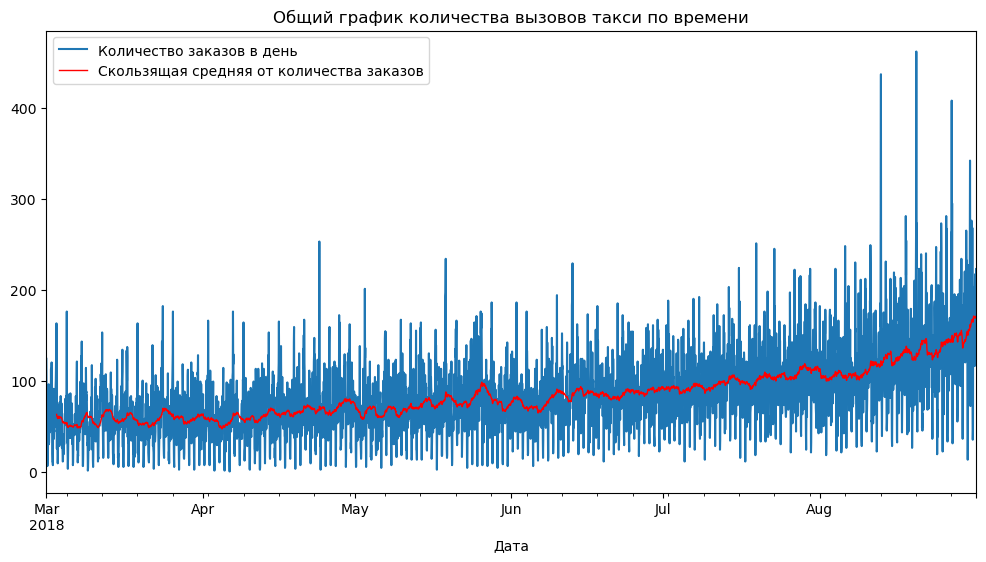

In [341]:
ax = taxi.plot(title='Общий график количества вызовов такси по времени', figsize=figsize)
taxi.rolling(50).mean().plot(ax=ax, color='red', linewidth=1);
ax.legend(['Количество заказов в день', 'Скользящая средняя от количества заказов']);
ax.set_xlabel('Дата');

### Выводы, подготовка данных
- Данные загружены из файла taxi.csv в датафрейм taxi с индексацией по колонке даты.
- В файле 26496 строк с данными по количеству заказов такси в каждые 10 минут за период с 2018-03-01 по 2018-08-31
- Проведено ресемплирование данных с аггрегацией почасовых заказов, получилось 4416 строк


## Анализ данных временного ряда

### Распределение данных и стандартные статистики

In [342]:
taxi.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

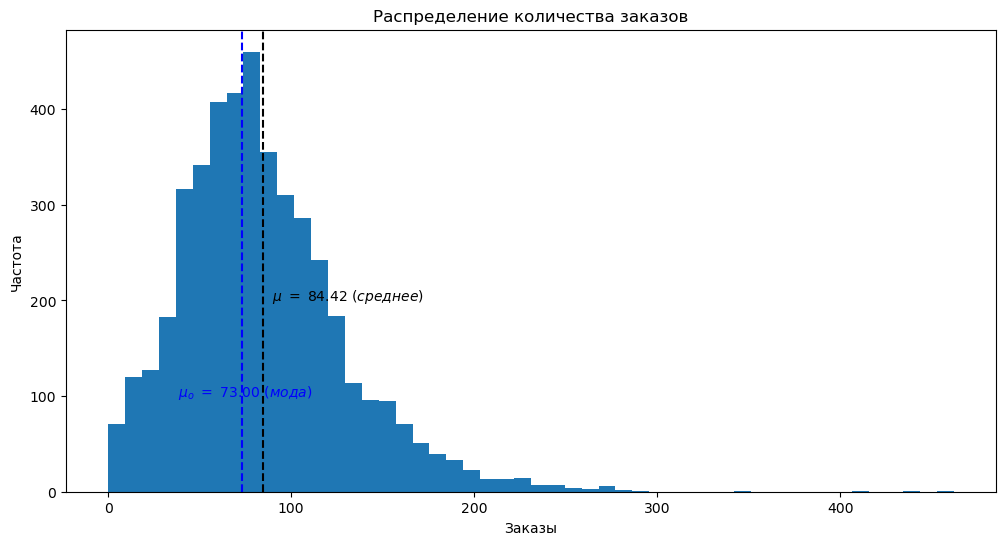

In [343]:
ax = taxi[target_col].plot.hist(bins=50, figsize=figsize);
mean = taxi[target_col].mean(); mode = taxi[target_col].mode()[0]
ax.axvline(mean, color='black', ls='--')
ax.axvline(mode, color='blue', ls='--')
ax.text(mean+5, 200, f'$\mu\ =\ {mean:.2f}\ (среднее)$')
ax.text(mode-35, 100, f'$\mu_o\ =\ {mode:.2f}\ (мода)$', color='blue'); 
ax.set(title='Распределение количества заказов', xlabel='Заказы', ylabel='Частота');

Данные имеют одномодальное правоасимметричное распределение (мода меньше среднего) с длинным правым хвостом, что говорит о том, что в данных имеются пиковые значения, существенно превышающие среднее.

Временной ряд нестационарный: среднее значение количества заказов со временем растет, также растет и дисперсия (std):

Среднее количество заказов и стандартное отклонение в первой половине ряда:

In [344]:
taxi.iloc[:taxi.shape[0]//2].agg(['mean', 'std'])

num_orders
mean   65.003170
std    32.899422

Среднее количество заказов и стандартное отклонение во второй половине ряда:

In [345]:
taxi.iloc[taxi.shape[0]//2:].agg(['mean', 'std'])

num_orders
mean  103.842391
std    47.098376

Иллюстрация нестационарности:

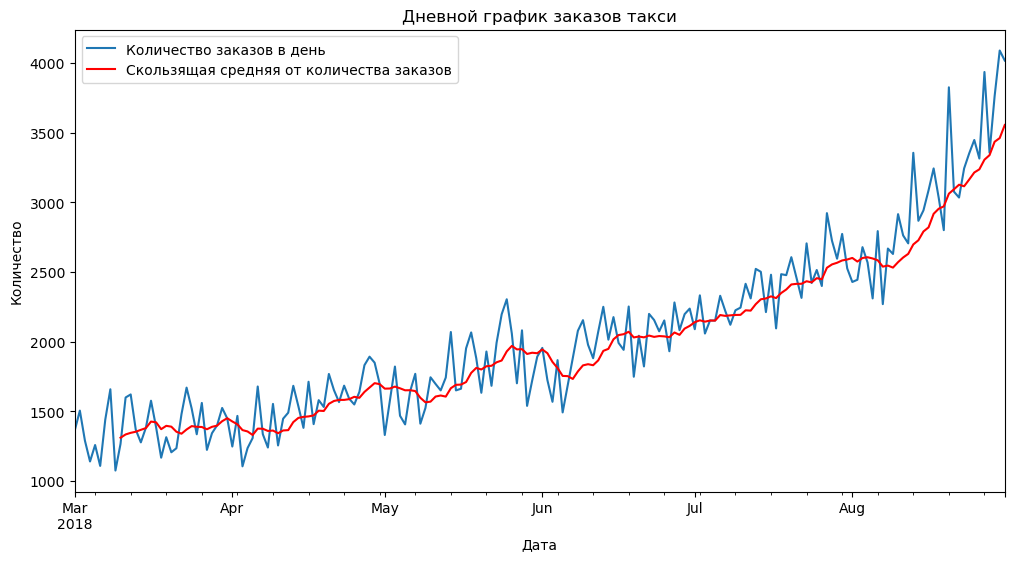

In [346]:
ax = taxi.resample('1d').sum().plot(figsize=figsize)
taxi.resample('1d').sum().rolling(10).mean().plot(ax=ax, color='red')
ax.set(title='Дневной график заказов такси', xlabel='Дата', ylabel='Количество')
ax.legend(['Количество заказов в день', 'Скользящая средняя от количества заказов']);

### Анализ сезонной декомпозиции ряда

Функция постройки графика декомпозиции ряда:

In [347]:
def decompose(data, period_days, plot=['Тренд', 'Сезонность', 'Остатки'], returning=False, mov_avg=0):
    
    # определение частотности ряда в типе timedelta и перевод периода (в днях) в период частоты ряда
    delta = data.iloc[:2].apply(lambda x: x.index[1] - x.index[0])[target_col]
    decomposed = seasonal_decompose(data, period=pd.to_timedelta(f'{period_days}d') // delta)
    
    dec = {'Тренд': decomposed.trend, 'Сезонность': decomposed.seasonal, 'Остатки': decomposed.resid}
    
    plt.figure(figsize=(figsize[0], figsize[1]*len(plot)))
    plt.subplots_adjust(hspace=0.3)
    
    for i, n in enumerate(plot): # в цикле динамически расширяется фигура для размещения графиков
        ax = plt.subplot(len(plot), 1, i+1)
        name = f' {n} (период окна декомпозиции: {period_days} дней)'
        dec[n].plot(title=name, ax=ax, xlabel='Дата', ylabel='Количество заказов')
        
        # если нужен график скользящей средней периода mov_avg
        if mov_avg > 0:
            dec[n].rolling(mov_avg).mean().plot(title=name, ax=ax, xlabel='Дата', ylabel='Количество заказов',
                                                color='red')
            
    # если нужно вернуть значения декомпозиции
    if returning:
        return dec['Тренд'], dec['Сезонность'], dec['Остатки']

#### Оценка трендовой компоненты ряда

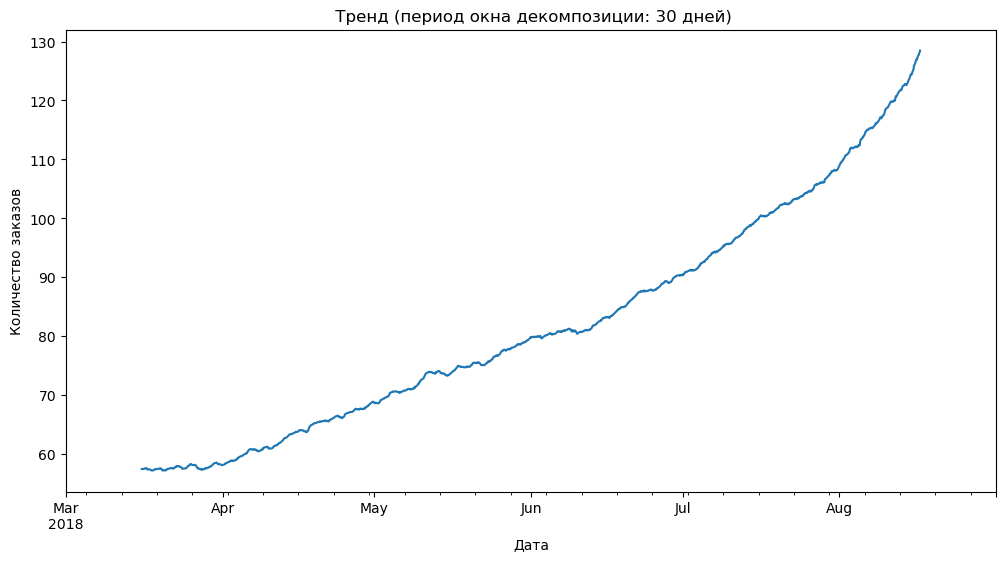

In [348]:
decompose(taxi, period_days=30, plot=['Тренд'])

Тренд явно различим. От 60 вызовов в начале ряда количество вызовов растет до 130.

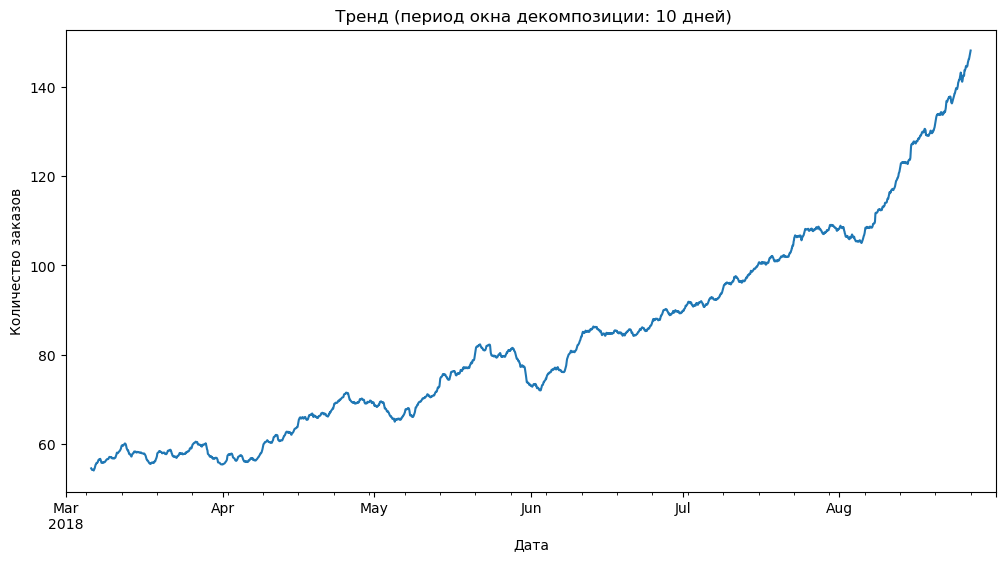

In [349]:
decompose(taxi, period_days=10, plot=['Тренд'])

В начале каждого месяца (кроме июля) наблюдаются провалы в количестве заказов.

При обучении модели для характеризации тренда могут пригодиться такой признак, как день года (`dt.dayofyear`).

#### Месячная сезонность

Пересемплирую данные из часов в дни, чтобы сезонность была различима:

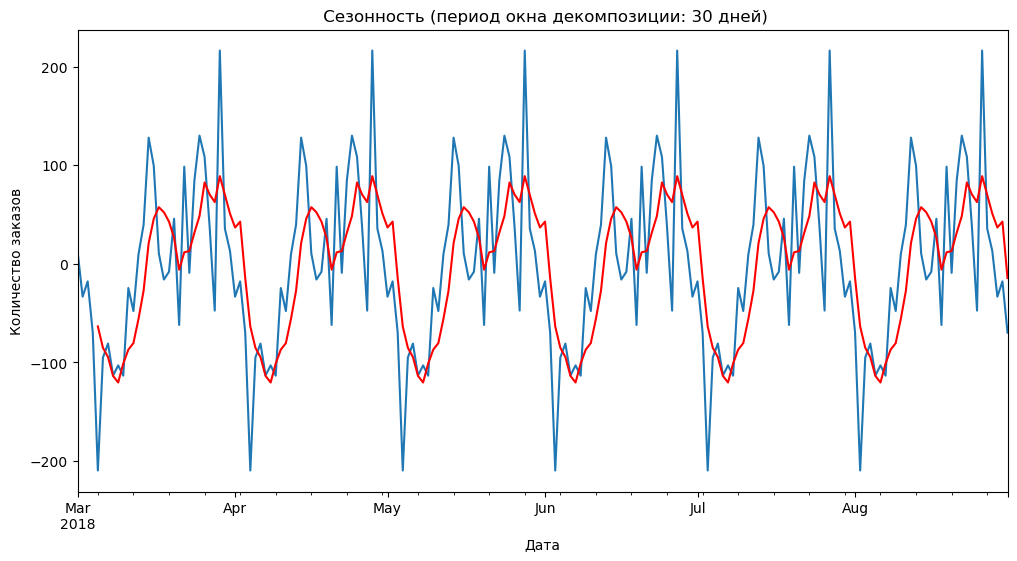

In [350]:
decompose(taxi.resample('1d').sum(), period_days=30, plot=['Сезонность'], mov_avg=5)

Начало каждого месяца сопровождается падением относительно линии тренда, после чего идет рост до последней недели месяца, затем падение ниже линии тренда, заканчиающееся в начале следующего месяца.

#### Недельная сезонность

Данные за первые 2 недели:

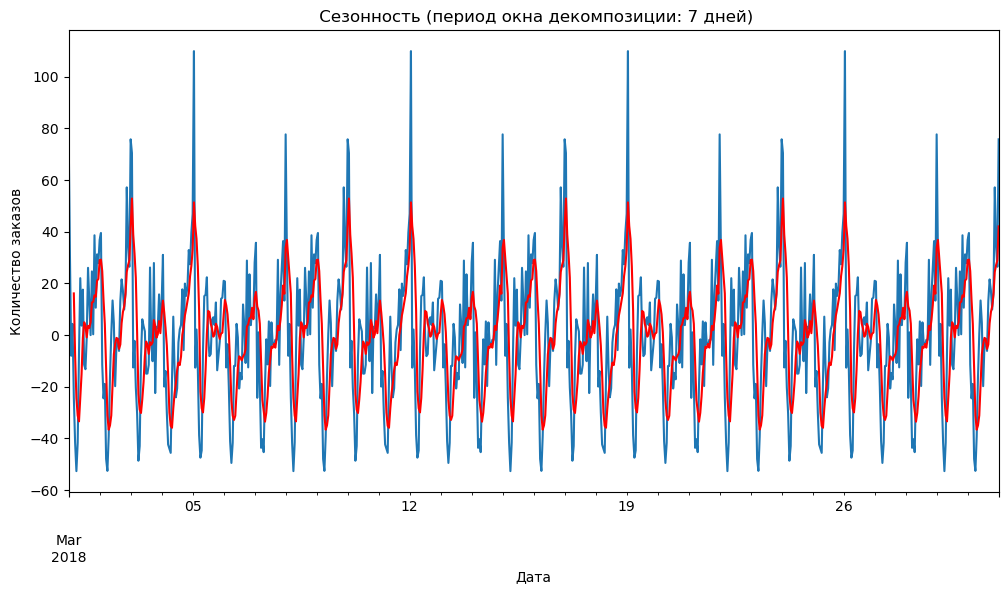

In [351]:
decompose(taxi[min_date:min_date+pd.to_timedelta(30, unit='d')], 7, plot=['Сезонность'], mov_avg=5)

In [352]:
taxi.loc['2018-03-05'].index.day_name()[0]

'Monday'

Последние 2 недели:

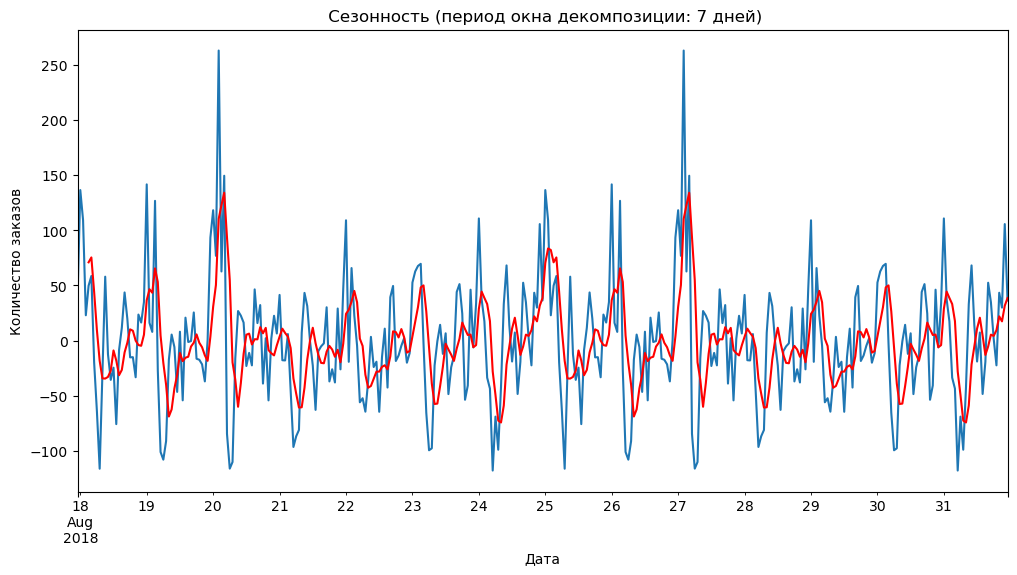

In [353]:
decompose(taxi[max_date-pd.to_timedelta(14, unit='d'):max_date], 7, plot=['Сезонность'], mov_avg=5)

In [354]:
taxi.loc['2018-08-20'].index.day_name()[0]

'Monday'

Недельное пиковое значение количества вызовов приходится на понедельник. Видна зависимость высоты внутридневных пиков от дня недели. Для моделей понадобится признак дня недели: (`dt.dayofweek`)

#### Дневная сезонность

Первые 2 дня:

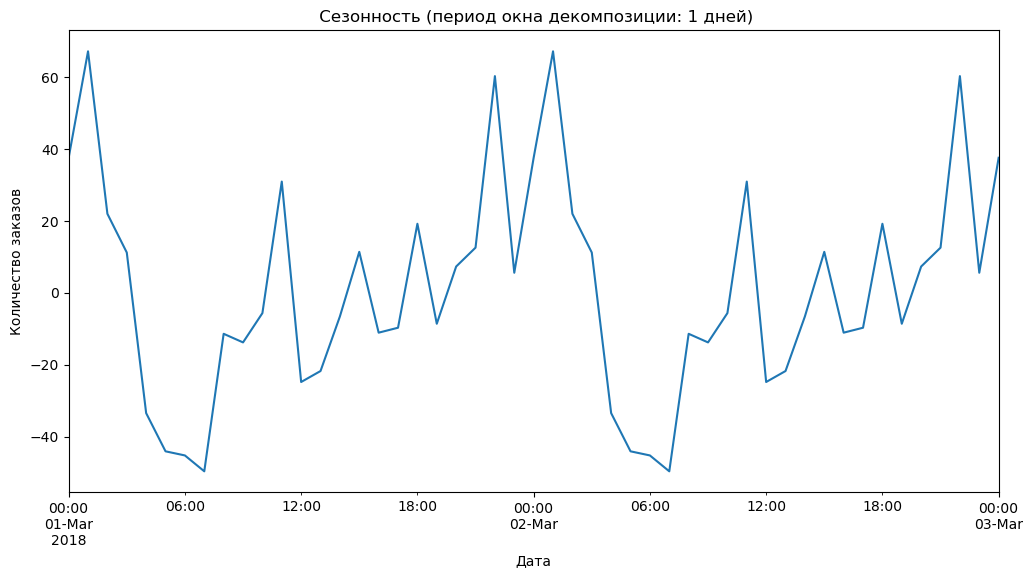

In [355]:
decompose(taxi[min_date:min_date+pd.to_timedelta(2, unit='d')], 1, plot=['Сезонность'])

Последние 2 дня:

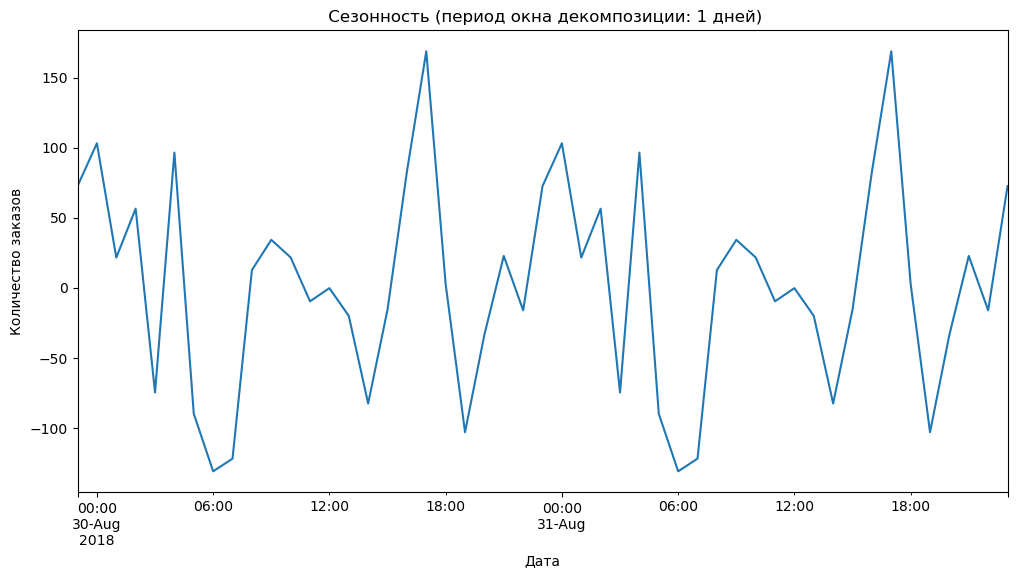

In [356]:
decompose(taxi[max_date-pd.to_timedelta(2, unit='d'):max_date], 1, plot=['Сезонность'])

Меньше всего заказов приходится на утренние часы около 6:00, больше всего - на вечерние часы. Для обучения моделей понадобится признак часа (`dt.hour`)

### Выводы, анализ данных временного ряда
- Исследуемый временной ряд не является стационарным
- При декомпозиции ряда, используя различные временные периоды, выявлена внутримесячная, внутринедельная и внутридневная сезонности
- На основе выявленных характеристик временного ряда предложены новые признаки:
    - харатеризуюище тренд: день в году (`dt.dayofyear`)
    - харктеризующие сезонность временного ряда: день недели (`dt.dayofweek`), час (`dt.hour`)

## Обучение моделей

Уменьшаю размер датафрейма:

In [357]:
taxi[target_col] = pd.to_numeric(taxi[target_col], downcast='integer')
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int16
dtypes: int16(1)
memory usage: 172.2 KB


Функции для обучения моделей и формирования признаков:

In [358]:
def make_features(data, max_lag, rolling_mean_size):
    '''Функция генерации новых признаков временного ряда'''
    data.loc[:, 'day_of_year'] = data.index.dayofyear.to_numpy().astype('int16')
    data.loc[:, 'day_of_week'] = data.index.dayofweek.to_numpy().astype('int8')
    data.loc[:, 'hour'] = data.index.hour.to_numpy().astype('int8')
    
    for lag in range(1, max_lag+1):
        data[f'lag_{lag}'] = data[target_col].shift(lag).interpolate().bfill().astype('int16')

    data['rolling_mean'] = data[target_col].shift().rolling(rolling_mean_size).mean().interpolate().bfill().astype('float32')

In [359]:

def finetune(model_name, parameters, features, target, verbose=3, jobs=-1, **kwargs):
    '''Фукнция подбора гиперпараметров
    На вход принимает класс модели, решетку гиперпараметров для поиска, признаки и целевой признак
    Возвращает лучшую из натренерованных моделей, её гиперпараметры и её луший результат по метрике RMSE
    '''
    cv = GridSearchCV(model_name(**kwargs), param_grid=parameters, scoring='neg_mean_squared_error',
                            cv=TimeSeriesSplit(n_splits=5), verbose=verbose, n_jobs=jobs)
    cv.fit(features, target)  
    
    return cv.best_estimator_, cv.best_params_, np.sqrt(-cv.best_score_)

def print_cv_results(params, rmse):
    '''Выводит результаты кросс-валидации на экран'''
    print()
    print(f'Лучшие параметры модели: {params}')
    print(f'(train, CV) лучшее RMSE: {rmse:.2f}')
    print()

Генерирую признаки (параметры задержки и периода сглаживания средней подобраны экспериментально):

In [361]:
params = {'learning_rate': [0.05449], 'max_bin': [40], 'num_leaves': [32]}
test_df = taxi.copy()
best_p = []
best_rmse = 9999

for lag in range(3, 30):
    for avg in range(7, 40):
        make_features(test_df, lag, avg)
        t_features = test_df.drop([target_col], axis=1)
        t_target = test_df[target_col]

        t_features_train, t_features_test, t_target_train, t_target_test = train_test_split(
            t_features, t_target, shuffle=False, test_size=0.1)
        test_df = taxi.copy()

        _, _, rmse = finetune(LGBMRegressor, params, t_features_train, t_target_train, verbose=0)

        if rmse < best_rmse:
            best_rmse = rmse
            best_p.append((lag, avg, best_rmse))
print(best_p)

[(3, 7, 24.196688282311555), (3, 8, 24.0252403101438)]


In [362]:
make_features(taxi, 3, 8)

In [293]:
taxi

num_orders  day_of_year  day_of_week  day  hour  lag_1  \
datetime                                                                      
2018-03-01 00:00:00         124           60            3    1     0    124   
2018-03-01 01:00:00          85           60            3    1     1    124   
2018-03-01 02:00:00          71           60            3    1     2     85   
2018-03-01 03:00:00          66           60            3    1     3     71   
2018-03-01 04:00:00          43           60            3    1     4     66   
...                         ...          ...          ...  ...   ...    ...   
2018-08-31 19:00:00         136          243            4   31    19    207   
2018-08-31 20:00:00         154          243            4   31    20    136   
2018-08-31 21:00:00         159          243            4   31    21    154   
2018-08-31 22:00:00         223          243            4   31    22    159   
2018-08-31 23:00:00         205          243            4   31    23    223   

                     lag_2  lag_3  rolling_mean  
datetime                                         
2018-03-01 00:00:00    124    124        52.750  
2018-03-01 01:00:00    124    124        52.750  
2018-03-01 02:00:00    124    124        52.750  
2018-03-01 03:00:00     85    124        52.750  
2018-03-01 04:00:00     71     85        52.750  
...                    ...    ...           ...  
2018-08-31 19:00:00    217    197       167.375  
2018-08-31 20:00:00    207    217       163.500  
2018-08-31 21:00:00    136    207       165.750  
2018-08-31 22:00:00    154    136       164.875  
2018-08-31 23:00:00    159    154       176.125  

[4416 rows x 9 columns]

Разделение выборки на обучающую и тестовую (10% на тестовую):

In [363]:
features = taxi.drop([target_col], axis=1)
target = taxi[target_col]

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False,
                                                                            test_size=0.1)


In [364]:
print(f'Размер тренировочной выборки: {features_train.shape}')
print(f'Размер тестовоый выборки: {features_test.shape}')

Размер тренировочной выборки: (3974, 7)
Размер тестовоый выборки: (442, 7)


### Линейная регрессия

In [365]:
%%time

params = {}
lr_best_model, lr_best_params, lr_best_rmse = finetune(LinearRegression, params, features_train, target_train)
print_cv_results(lr_best_params, lr_best_rmse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Лучшие параметры модели: {}
(train, CV) лучшее RMSE: 31.74

CPU times: user 6.98 ms, sys: 7.81 ms, total: 14.8 ms
Wall time: 132 ms


### Случайный лес

In [366]:
%%time 

params = {'max_depth': [20, 21],
          'n_estimators': [157, 158]}

rf_best_model, rf_best_params, rf_best_rmse = finetune(RandomForestRegressor, params,
                                                        features_train, target_train, random_state=42)
print_cv_results(rf_best_params, rf_best_rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Лучшие параметры модели: {'max_depth': 21, 'n_estimators': 157}
(train, CV) лучшее RMSE: 24.27

CPU times: user 1.92 s, sys: 67.3 ms, total: 1.99 s
Wall time: 10.5 s


### CatBoost

In [386]:
%%time

params = {
    'learning_rate': [0.0279, 0.028, 0.0281],
    'iterations': [1125, 1126, 1127],
    'l2_leaf_reg': [2]
    
}

cb_best_model, cb_best_params, cb_best_rmse = finetune(CatBoostRegressor, params,
                                       features_train, target_train, random_state=42)
print_cv_results(cb_best_params, cb_best_rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
1053:	learn: 11.1544764	total: 3.39s	remaining: 241ms
1054:	learn: 11.1492351	total: 3.39s	remaining: 238ms
1055:	learn: 11.1450321	total: 3.4s	remaining: 235ms
1056:	learn: 11.1378002	total: 3.4s	remaining: 231ms
1057:	learn: 11.1327880	total: 3.4s	remaining: 228ms
1058:	learn: 11.1300024	total: 3.4s	remaining: 225ms
1059:	learn: 11.1232509	total: 3.4s	remaining: 221ms
1060:	learn: 11.1212207	total: 3.4s	remaining: 218ms
1061:	learn: 11.1153068	total: 3.41s	remaining: 215ms
1062:	learn: 11.1086966	total: 3.41s	remaining: 212ms
1063:	learn: 11.0997421	total: 3.41s	remaining: 209ms
1064:	learn: 11.0934746	total: 3.42s	remaining: 205ms
1065:	learn: 11.0893915	total: 3.42s	remaining: 202ms
1066:	learn: 11.0838958	total: 3.42s	remaining: 199ms
1067:	learn: 11.0785048	total: 3.42s	remaining: 195ms
1068:	learn: 11.0726518	total: 3.42s	remaining: 192ms
1069:	learn: 11.0695561	total: 3.42s	remaining: 189ms
1070:	learn: 11.0673645	tota

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated a

1015:	learn: 14.2900266	total: 4.06s	remaining: 451ms
1016:	learn: 14.2833893	total: 4.06s	remaining: 447ms
1017:	learn: 14.2816426	total: 4.07s	remaining: 443ms
1018:	learn: 14.2753359	total: 4.07s	remaining: 439ms
1019:	learn: 14.2701773	total: 4.07s	remaining: 435ms
1020:	learn: 14.2654022	total: 4.07s	remaining: 431ms
1021:	learn: 14.2628775	total: 4.08s	remaining: 427ms
1022:	learn: 14.2567734	total: 4.08s	remaining: 422ms
1023:	learn: 14.2537470	total: 4.08s	remaining: 418ms
1024:	learn: 14.2478284	total: 4.08s	remaining: 414ms
1025:	learn: 14.2392777	total: 4.09s	remaining: 410ms
1026:	learn: 14.2359183	total: 4.09s	remaining: 406ms
1027:	learn: 14.2327398	total: 4.09s	remaining: 402ms
1028:	learn: 14.2225363	total: 4.09s	remaining: 398ms
1029:	learn: 14.2189792	total: 4.1s	remaining: 394ms
1030:	learn: 14.2162511	total: 4.11s	remaining: 390ms
1031:	learn: 14.2121496	total: 4.13s	remaining: 388ms
1032:	learn: 14.2100176	total: 4.15s	remaining: 385ms
1033:	learn: 14.2049337	total

37:	learn: 20.5159649	total: 183ms	remaining: 5.24s
38:	learn: 20.4364416	total: 185ms	remaining: 5.14s
39:	learn: 20.3034458	total: 186ms	remaining: 5.04s
40:	learn: 20.2244750	total: 187ms	remaining: 4.94s
41:	learn: 20.1365024	total: 188ms	remaining: 4.84s
42:	learn: 20.0229721	total: 189ms	remaining: 4.75s
43:	learn: 19.9011762	total: 190ms	remaining: 4.66s
44:	learn: 19.8365977	total: 191ms	remaining: 4.58s
45:	learn: 19.7316043	total: 192ms	remaining: 4.49s
46:	learn: 19.6245255	total: 193ms	remaining: 4.42s
47:	learn: 19.5421450	total: 193ms	remaining: 4.34s
48:	learn: 19.4693102	total: 194ms	remaining: 4.26s
49:	learn: 19.3649570	total: 195ms	remaining: 4.18s
50:	learn: 19.2624415	total: 195ms	remaining: 4.11s
51:	learn: 19.1793247	total: 196ms	remaining: 4.04s
52:	learn: 19.1250363	total: 197ms	remaining: 3.98s
53:	learn: 19.0406255	total: 197ms	remaining: 3.91s
54:	learn: 18.9621935	total: 198ms	remaining: 3.86s
55:	learn: 18.8858692	total: 199ms	remaining: 3.81s
56:	learn: 1

231:	learn: 16.0043492	total: 647ms	remaining: 2.49s
232:	learn: 15.9950955	total: 648ms	remaining: 2.48s
233:	learn: 15.9823698	total: 649ms	remaining: 2.47s
234:	learn: 15.9595946	total: 652ms	remaining: 2.47s
235:	learn: 15.9529776	total: 653ms	remaining: 2.46s
236:	learn: 15.9416646	total: 667ms	remaining: 2.5s
237:	learn: 15.9277099	total: 668ms	remaining: 2.49s
238:	learn: 15.9155567	total: 669ms	remaining: 2.48s
239:	learn: 15.9004456	total: 670ms	remaining: 2.47s
240:	learn: 15.8876594	total: 671ms	remaining: 2.46s
241:	learn: 15.8536069	total: 672ms	remaining: 2.45s
242:	learn: 15.8449109	total: 672ms	remaining: 2.44s
243:	learn: 15.8148370	total: 673ms	remaining: 2.43s
244:	learn: 15.8052127	total: 674ms	remaining: 2.42s
245:	learn: 15.7925104	total: 675ms	remaining: 2.41s
246:	learn: 15.7605090	total: 686ms	remaining: 2.44s
247:	learn: 15.7545477	total: 686ms	remaining: 2.43s
248:	learn: 15.7382219	total: 687ms	remaining: 2.42s
249:	learn: 15.7216103	total: 688ms	remaining: 

38:	learn: 24.3559017	total: 312ms	remaining: 8.68s
39:	learn: 24.2466958	total: 314ms	remaining: 8.5s
40:	learn: 24.1575396	total: 334ms	remaining: 8.83s
41:	learn: 24.0676863	total: 336ms	remaining: 8.66s
42:	learn: 23.9753457	total: 337ms	remaining: 8.48s
43:	learn: 23.8763043	total: 347ms	remaining: 8.52s
44:	learn: 23.7739389	total: 348ms	remaining: 8.36s
45:	learn: 23.6853278	total: 357ms	remaining: 8.38s
46:	learn: 23.5889001	total: 359ms	remaining: 8.23s
47:	learn: 23.4878948	total: 361ms	remaining: 8.09s
48:	learn: 23.4025034	total: 362ms	remaining: 7.95s
49:	learn: 23.3121836	total: 371ms	remaining: 7.98s
50:	learn: 23.2120592	total: 373ms	remaining: 7.85s
51:	learn: 23.1488490	total: 374ms	remaining: 7.72s
52:	learn: 23.0748295	total: 408ms	remaining: 8.26s
53:	learn: 23.0080499	total: 411ms	remaining: 8.15s
54:	learn: 22.9305980	total: 412ms	remaining: 8.02s
55:	learn: 22.8795678	total: 427ms	remaining: 8.15s
56:	learn: 22.8168974	total: 431ms	remaining: 8.07s
57:	learn: 22

121:	learn: 19.4775901	total: 680ms	remaining: 5.59s
122:	learn: 19.4528863	total: 692ms	remaining: 5.64s
123:	learn: 19.4454161	total: 695ms	remaining: 5.61s
124:	learn: 19.4248830	total: 696ms	remaining: 5.57s
125:	learn: 19.4143561	total: 699ms	remaining: 5.54s
126:	learn: 19.3898686	total: 701ms	remaining: 5.51s
127:	learn: 19.3769808	total: 702ms	remaining: 5.47s
128:	learn: 19.3523739	total: 704ms	remaining: 5.43s
129:	learn: 19.3267628	total: 705ms	remaining: 5.4s
130:	learn: 19.3087462	total: 707ms	remaining: 5.36s
131:	learn: 19.2934339	total: 708ms	remaining: 5.32s
132:	learn: 19.2849713	total: 709ms	remaining: 5.29s
133:	learn: 19.2566982	total: 711ms	remaining: 5.26s
134:	learn: 19.2457841	total: 712ms	remaining: 5.22s
135:	learn: 19.2233222	total: 713ms	remaining: 5.18s
136:	learn: 19.2010224	total: 714ms	remaining: 5.15s
137:	learn: 19.1636215	total: 715ms	remaining: 5.11s
138:	learn: 19.1520633	total: 716ms	remaining: 5.08s
139:	learn: 19.1387304	total: 717ms	remaining: 

194:	learn: 19.1311021	total: 1.11s	remaining: 5.31s
195:	learn: 19.1169817	total: 1.11s	remaining: 5.29s
196:	learn: 19.0885748	total: 1.12s	remaining: 5.26s
197:	learn: 19.0672823	total: 1.12s	remaining: 5.25s
198:	learn: 19.0446204	total: 1.12s	remaining: 5.23s
199:	learn: 19.0368724	total: 1.13s	remaining: 5.21s
200:	learn: 19.0126271	total: 1.14s	remaining: 5.25s
201:	learn: 19.0063177	total: 1.14s	remaining: 5.22s
202:	learn: 18.9906080	total: 1.14s	remaining: 5.19s
203:	learn: 18.9838299	total: 1.15s	remaining: 5.17s
204:	learn: 18.9691302	total: 1.15s	remaining: 5.15s
205:	learn: 18.9635996	total: 1.15s	remaining: 5.12s
206:	learn: 18.9461644	total: 1.15s	remaining: 5.11s
207:	learn: 18.9269834	total: 1.15s	remaining: 5.08s
208:	learn: 18.9069604	total: 1.16s	remaining: 5.07s
209:	learn: 18.8951378	total: 1.16s	remaining: 5.06s
210:	learn: 18.8831845	total: 1.17s	remaining: 5.05s
211:	learn: 18.8668204	total: 1.17s	remaining: 5.03s
212:	learn: 18.8584027	total: 1.17s	remaining:

714:	learn: 11.0051291	total: 1.72s	remaining: 988ms
715:	learn: 11.0006193	total: 1.72s	remaining: 984ms
716:	learn: 10.9997381	total: 1.72s	remaining: 981ms
717:	learn: 10.9969062	total: 1.72s	remaining: 978ms
718:	learn: 10.9835387	total: 1.73s	remaining: 974ms
719:	learn: 10.9744803	total: 1.73s	remaining: 971ms
720:	learn: 10.9675739	total: 1.73s	remaining: 968ms
721:	learn: 10.9623470	total: 1.73s	remaining: 964ms
722:	learn: 10.9595168	total: 1.73s	remaining: 961ms
723:	learn: 10.9530335	total: 1.73s	remaining: 958ms
724:	learn: 10.9413120	total: 1.73s	remaining: 955ms
725:	learn: 10.9340305	total: 1.73s	remaining: 951ms
726:	learn: 10.9281513	total: 1.73s	remaining: 948ms
727:	learn: 10.9241375	total: 1.73s	remaining: 945ms
728:	learn: 10.9202984	total: 1.73s	remaining: 941ms
729:	learn: 10.9119811	total: 1.73s	remaining: 938ms
730:	learn: 10.8994004	total: 1.73s	remaining: 935ms
731:	learn: 10.8946565	total: 1.74s	remaining: 932ms
732:	learn: 10.8926718	total: 1.74s	remaining:

849:	learn: 10.2153424	total: 1.83s	remaining: 594ms
850:	learn: 10.2118316	total: 1.84s	remaining: 591ms
851:	learn: 10.2063066	total: 1.84s	remaining: 589ms
852:	learn: 10.1978333	total: 1.84s	remaining: 586ms
853:	learn: 10.1946321	total: 1.84s	remaining: 583ms
854:	learn: 10.1899026	total: 1.84s	remaining: 581ms
855:	learn: 10.1862032	total: 1.84s	remaining: 578ms
856:	learn: 10.1753652	total: 1.84s	remaining: 576ms
857:	learn: 10.1675623	total: 1.84s	remaining: 573ms
858:	learn: 10.1596663	total: 1.84s	remaining: 571ms
859:	learn: 10.1537262	total: 1.84s	remaining: 568ms
860:	learn: 10.1431323	total: 1.84s	remaining: 566ms
861:	learn: 10.1427809	total: 1.84s	remaining: 563ms
862:	learn: 10.1328745	total: 1.84s	remaining: 560ms
863:	learn: 10.1297380	total: 1.85s	remaining: 558ms
864:	learn: 10.1261709	total: 1.85s	remaining: 555ms
865:	learn: 10.1164355	total: 1.85s	remaining: 553ms
866:	learn: 10.1108695	total: 1.85s	remaining: 550ms
867:	learn: 10.1033087	total: 1.85s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


972:	learn: 6.9645348	total: 1.96s	remaining: 307ms
973:	learn: 6.9540403	total: 1.96s	remaining: 304ms
974:	learn: 6.9457906	total: 1.96s	remaining: 302ms
975:	learn: 6.9381641	total: 1.97s	remaining: 300ms
976:	learn: 6.9316632	total: 1.97s	remaining: 298ms
977:	learn: 6.9297728	total: 1.97s	remaining: 296ms
978:	learn: 6.9237386	total: 1.97s	remaining: 294ms
979:	learn: 6.9163276	total: 1.97s	remaining: 291ms
980:	learn: 6.9047408	total: 1.97s	remaining: 289ms
981:	learn: 6.9013161	total: 1.98s	remaining: 289ms
982:	learn: 6.8995495	total: 1.98s	remaining: 287ms
983:	learn: 6.8931123	total: 1.99s	remaining: 285ms
984:	learn: 6.8911742	total: 1.99s	remaining: 282ms
985:	learn: 6.8892194	total: 1.99s	remaining: 280ms
986:	learn: 6.8870209	total: 2s	remaining: 280ms
987:	learn: 6.8826014	total: 2s	remaining: 277ms
988:	learn: 6.8793942	total: 2.02s	remaining: 278ms
989:	learn: 6.8736307	total: 2.02s	remaining: 276ms
990:	learn: 6.8703442	total: 2.03s	remaining: 274ms
991:	learn: 6.8642

430:	learn: 15.1386768	total: 2.16s	remaining: 3.47s
431:	learn: 15.1172884	total: 2.16s	remaining: 3.46s
432:	learn: 15.1019450	total: 2.16s	remaining: 3.45s
433:	learn: 15.0843816	total: 2.16s	remaining: 3.44s
434:	learn: 15.0807645	total: 2.16s	remaining: 3.43s
435:	learn: 15.0685399	total: 2.16s	remaining: 3.42s
436:	learn: 15.0613573	total: 2.16s	remaining: 3.41s
437:	learn: 15.0540161	total: 2.17s	remaining: 3.4s
438:	learn: 15.0518950	total: 2.17s	remaining: 3.39s
439:	learn: 15.0490231	total: 2.17s	remaining: 3.38s
440:	learn: 15.0351375	total: 2.17s	remaining: 3.37s
441:	learn: 15.0201636	total: 2.17s	remaining: 3.36s
442:	learn: 15.0018708	total: 2.19s	remaining: 3.37s
443:	learn: 14.9920818	total: 2.19s	remaining: 3.36s
444:	learn: 14.9744052	total: 2.21s	remaining: 3.38s
445:	learn: 14.9577051	total: 2.21s	remaining: 3.37s
446:	learn: 14.9421414	total: 2.22s	remaining: 3.36s
447:	learn: 14.9273153	total: 2.23s	remaining: 3.37s
448:	learn: 14.9117579	total: 2.24s	remaining: 

[CV 1/5] END iterations=1125, l2_leaf_reg=2, learning_rate=0.0279;, score=-501.120 total time=   2.5s
0:	learn: 29.3326961	total: 1.67ms	remaining: 1.88s
1:	learn: 28.9170229	total: 7.06ms	remaining: 3.97s
2:	learn: 28.5185368	total: 9.38ms	remaining: 3.51s
3:	learn: 28.1748473	total: 10.3ms	remaining: 2.89s
4:	learn: 27.8109384	total: 12.3ms	remaining: 2.75s
5:	learn: 27.5018944	total: 13.6ms	remaining: 2.53s
6:	learn: 27.1713055	total: 14.3ms	remaining: 2.29s
7:	learn: 26.8505485	total: 15ms	remaining: 2.09s
8:	learn: 26.5078109	total: 15.7ms	remaining: 1.95s
9:	learn: 26.1662906	total: 29.5ms	remaining: 3.29s
10:	learn: 25.8636615	total: 30.4ms	remaining: 3.08s
11:	learn: 25.5753102	total: 31ms	remaining: 2.88s
12:	learn: 25.3772630	total: 31.6ms	remaining: 2.7s
13:	learn: 25.1494495	total: 32.2ms	remaining: 2.56s
14:	learn: 24.8502652	total: 32.9ms	remaining: 2.43s
15:	learn: 24.5649885	total: 33.5ms	remaining: 2.32s
16:	learn: 24.2807097	total: 34.1ms	remaining: 2.23s
17:	learn: 2

154:	learn: 15.4975341	total: 480ms	remaining: 3s
155:	learn: 15.4754562	total: 499ms	remaining: 3.1s
156:	learn: 15.4520263	total: 504ms	remaining: 3.11s
157:	learn: 15.4405525	total: 511ms	remaining: 3.12s
158:	learn: 15.4203341	total: 518ms	remaining: 3.15s
159:	learn: 15.4015492	total: 519ms	remaining: 3.13s
160:	learn: 15.3671180	total: 520ms	remaining: 3.11s
161:	learn: 15.3348495	total: 531ms	remaining: 3.16s
162:	learn: 15.3162040	total: 532ms	remaining: 3.14s
163:	learn: 15.3004495	total: 541ms	remaining: 3.17s
164:	learn: 15.2822802	total: 542ms	remaining: 3.15s
165:	learn: 15.2658526	total: 551ms	remaining: 3.18s
166:	learn: 15.2538061	total: 551ms	remaining: 3.16s
167:	learn: 15.2420441	total: 552ms	remaining: 3.14s
168:	learn: 15.2292019	total: 556ms	remaining: 3.14s
169:	learn: 15.1988784	total: 557ms	remaining: 3.13s
170:	learn: 15.1777721	total: 557ms	remaining: 3.11s
171:	learn: 15.1542939	total: 558ms	remaining: 3.09s
172:	learn: 15.1326164	total: 564ms	remaining: 3.1

814:	learn: 14.0228380	total: 3.29s	remaining: 1.25s
815:	learn: 14.0165499	total: 3.29s	remaining: 1.25s
816:	learn: 14.0123135	total: 3.29s	remaining: 1.24s
817:	learn: 14.0078008	total: 3.29s	remaining: 1.24s
818:	learn: 14.0016778	total: 3.29s	remaining: 1.23s
819:	learn: 13.9959870	total: 3.3s	remaining: 1.23s
820:	learn: 13.9901070	total: 3.3s	remaining: 1.22s
821:	learn: 13.9839399	total: 3.3s	remaining: 1.22s
822:	learn: 13.9790735	total: 3.3s	remaining: 1.21s
823:	learn: 13.9712786	total: 3.31s	remaining: 1.21s
824:	learn: 13.9652833	total: 3.33s	remaining: 1.21s
825:	learn: 13.9583743	total: 3.33s	remaining: 1.21s
826:	learn: 13.9552263	total: 3.33s	remaining: 1.2s
827:	learn: 13.9509823	total: 3.34s	remaining: 1.2s
828:	learn: 13.9480317	total: 3.34s	remaining: 1.19s
829:	learn: 13.9416031	total: 3.34s	remaining: 1.19s
830:	learn: 13.9340572	total: 3.35s	remaining: 1.18s
831:	learn: 13.9325382	total: 3.35s	remaining: 1.18s
832:	learn: 13.9277664	total: 3.35s	remaining: 1.17s

308:	learn: 13.0425498	total: 1.05s	remaining: 2.76s
309:	learn: 13.0128001	total: 1.05s	remaining: 2.77s
310:	learn: 13.0080996	total: 1.06s	remaining: 2.77s
311:	learn: 12.9918701	total: 1.07s	remaining: 2.78s
312:	learn: 12.9892289	total: 1.07s	remaining: 2.78s
313:	learn: 12.9834704	total: 1.08s	remaining: 2.78s
314:	learn: 12.9771708	total: 1.09s	remaining: 2.81s
315:	learn: 12.9730278	total: 1.1s	remaining: 2.81s
316:	learn: 12.9578827	total: 1.1s	remaining: 2.8s
317:	learn: 12.9525477	total: 1.1s	remaining: 2.79s
318:	learn: 12.9390026	total: 1.1s	remaining: 2.78s
319:	learn: 12.9209360	total: 1.1s	remaining: 2.78s
320:	learn: 12.9066123	total: 1.1s	remaining: 2.77s
321:	learn: 12.9003845	total: 1.1s	remaining: 2.76s
322:	learn: 12.8956611	total: 1.11s	remaining: 2.76s
323:	learn: 12.8861040	total: 1.11s	remaining: 2.75s
324:	learn: 12.8743602	total: 1.11s	remaining: 2.74s
325:	learn: 12.8610482	total: 1.11s	remaining: 2.73s
326:	learn: 12.8539220	total: 1.11s	remaining: 2.72s
3

189:	learn: 19.9603813	total: 1.16s	remaining: 5.71s
190:	learn: 19.9503123	total: 1.17s	remaining: 5.71s
191:	learn: 19.9379477	total: 1.17s	remaining: 5.68s
192:	learn: 19.9174946	total: 1.17s	remaining: 5.66s
193:	learn: 19.8972874	total: 1.17s	remaining: 5.63s
194:	learn: 19.8817868	total: 1.17s	remaining: 5.6s
195:	learn: 19.8664206	total: 1.18s	remaining: 5.58s
196:	learn: 19.8497244	total: 1.18s	remaining: 5.55s
197:	learn: 19.8316230	total: 1.18s	remaining: 5.53s
198:	learn: 19.8200958	total: 1.18s	remaining: 5.51s
199:	learn: 19.8100232	total: 1.21s	remaining: 5.58s
200:	learn: 19.7936867	total: 1.22s	remaining: 5.6s
201:	learn: 19.7894547	total: 1.22s	remaining: 5.57s
202:	learn: 19.7711711	total: 1.22s	remaining: 5.55s
203:	learn: 19.7640578	total: 1.22s	remaining: 5.53s
204:	learn: 19.7551579	total: 1.23s	remaining: 5.5s
205:	learn: 19.7361133	total: 1.24s	remaining: 5.51s
206:	learn: 19.7230498	total: 1.25s	remaining: 5.53s
207:	learn: 19.7074703	total: 1.25s	remaining: 5.

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1048:	learn: 11.2712968	total: 4.48s	remaining: 325ms
1049:	learn: 11.2649579	total: 4.49s	remaining: 321ms
1050:	learn: 11.2634928	total: 4.49s	remaining: 316ms
1051:	learn: 11.2607889	total: 4.49s	remaining: 312ms
1052:	learn: 11.2530979	total: 4.49s	remaining: 307ms
1053:	learn: 11.2501456	total: 4.5s	remaining: 303ms
1054:	learn: 11.2475721	total: 4.5s	remaining: 298ms
1055:	learn: 11.2422227	total: 4.5s	remaining: 294ms
1056:	learn: 11.2368235	total: 4.5s	remaining: 290ms
1057:	learn: 11.2346757	total: 4.5s	remaining: 285ms
1058:	learn: 11.2312812	total: 4.51s	remaining: 281ms
1059:	learn: 11.2243740	total: 4.51s	remaining: 276ms
1060:	learn: 11.2215451	total: 4.51s	remaining: 272ms
1061:	learn: 11.2187941	total: 4.51s	remaining: 268ms
1062:	learn: 11.2116144	total: 4.52s	remaining: 263ms
1063:	learn: 11.2080087	total: 4.53s	remaining: 260ms
1064:	learn: 11.2050088	total: 4.53s	remaining: 255ms
1065:	learn: 11.2016424	total: 4.54s	remaining: 251ms
1066:	learn: 11.1998048	total: 4.

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


344:	learn: 18.1851027	total: 2.35s	remaining: 5.31s
345:	learn: 18.1778927	total: 2.37s	remaining: 5.34s
346:	learn: 18.1702527	total: 2.38s	remaining: 5.33s
347:	learn: 18.1577511	total: 2.38s	remaining: 5.31s
348:	learn: 18.1506885	total: 2.38s	remaining: 5.3s
349:	learn: 18.1445280	total: 2.38s	remaining: 5.28s
350:	learn: 18.1386681	total: 2.39s	remaining: 5.26s
351:	learn: 18.1320370	total: 2.4s	remaining: 5.28s
352:	learn: 18.1242144	total: 2.41s	remaining: 5.27s
353:	learn: 18.1160866	total: 2.42s	remaining: 5.26s
354:	learn: 18.1108609	total: 2.42s	remaining: 5.24s
355:	learn: 18.1007870	total: 2.42s	remaining: 5.23s
356:	learn: 18.0931050	total: 2.43s	remaining: 5.23s
357:	learn: 18.0840857	total: 2.43s	remaining: 5.22s
358:	learn: 18.0779370	total: 2.44s	remaining: 5.2s
359:	learn: 18.0687095	total: 2.45s	remaining: 5.21s
360:	learn: 18.0639010	total: 2.46s	remaining: 5.2s
361:	learn: 18.0535271	total: 2.46s	remaining: 5.19s
362:	learn: 18.0484296	total: 2.47s	remaining: 5.1

1120:	learn: 12.6410418	total: 5.08s	remaining: 18.1ms
1121:	learn: 12.6398887	total: 5.08s	remaining: 13.6ms
1122:	learn: 12.6336053	total: 5.09s	remaining: 9.06ms
1123:	learn: 12.6288670	total: 5.09s	remaining: 4.53ms
1124:	learn: 12.6271741	total: 5.1s	remaining: 0us
[CV 4/5] END iterations=1125, l2_leaf_reg=2, learning_rate=0.0279;, score=-559.636 total time=   5.4s
0:	learn: 31.5422983	total: 9.48ms	remaining: 10.7s
1:	learn: 31.1382386	total: 11ms	remaining: 6.16s
2:	learn: 30.7687450	total: 13.3ms	remaining: 4.97s
3:	learn: 30.4534369	total: 14.4ms	remaining: 4.04s
4:	learn: 30.1661635	total: 21ms	remaining: 4.7s
5:	learn: 29.8530398	total: 22.4ms	remaining: 4.18s
6:	learn: 29.5331877	total: 26.1ms	remaining: 4.17s
7:	learn: 29.2407212	total: 27.3ms	remaining: 3.81s
8:	learn: 28.9306455	total: 28.5ms	remaining: 3.53s
9:	learn: 28.6238286	total: 29.7ms	remaining: 3.31s
10:	learn: 28.3137750	total: 30.9ms	remaining: 3.13s
11:	learn: 28.0362921	total: 32ms	remaining: 2.97s
12:	lear

776:	learn: 8.3713892	total: 3.07s	remaining: 1.38s
777:	learn: 8.3595614	total: 3.07s	remaining: 1.37s
778:	learn: 8.3546956	total: 3.07s	remaining: 1.36s
779:	learn: 8.3436262	total: 3.07s	remaining: 1.36s
780:	learn: 8.3416834	total: 3.08s	remaining: 1.35s
781:	learn: 8.3280147	total: 3.08s	remaining: 1.35s
782:	learn: 8.3197667	total: 3.08s	remaining: 1.34s
783:	learn: 8.3126239	total: 3.08s	remaining: 1.34s
784:	learn: 8.3075458	total: 3.08s	remaining: 1.33s
785:	learn: 8.2960957	total: 3.08s	remaining: 1.33s
786:	learn: 8.2869306	total: 3.08s	remaining: 1.32s
787:	learn: 8.2812110	total: 3.11s	remaining: 1.33s
788:	learn: 8.2743728	total: 3.11s	remaining: 1.32s
789:	learn: 8.2681082	total: 3.11s	remaining: 1.32s
790:	learn: 8.2610161	total: 3.11s	remaining: 1.31s
791:	learn: 8.2576349	total: 3.11s	remaining: 1.31s
792:	learn: 8.2491298	total: 3.12s	remaining: 1.3s
793:	learn: 8.2424655	total: 3.12s	remaining: 1.3s
794:	learn: 8.2353830	total: 3.12s	remaining: 1.29s
795:	learn: 8.

499:	learn: 16.9256955	total: 2.97s	remaining: 3.71s
500:	learn: 16.9145910	total: 2.97s	remaining: 3.7s
501:	learn: 16.9051612	total: 2.98s	remaining: 3.7s
502:	learn: 16.9001923	total: 2.98s	remaining: 3.69s
503:	learn: 16.8898282	total: 2.98s	remaining: 3.68s
504:	learn: 16.8796295	total: 3s	remaining: 3.68s
505:	learn: 16.8755946	total: 3s	remaining: 3.67s
506:	learn: 16.8651801	total: 3.02s	remaining: 3.69s
507:	learn: 16.8561117	total: 3.04s	remaining: 3.7s
508:	learn: 16.8508038	total: 3.04s	remaining: 3.69s
509:	learn: 16.8446758	total: 3.05s	remaining: 3.67s
510:	learn: 16.8402427	total: 3.05s	remaining: 3.66s
511:	learn: 16.8368071	total: 3.05s	remaining: 3.65s
512:	learn: 16.8302653	total: 3.05s	remaining: 3.64s
513:	learn: 16.8242875	total: 3.06s	remaining: 3.64s
514:	learn: 16.8179022	total: 3.08s	remaining: 3.65s
515:	learn: 16.8031672	total: 3.09s	remaining: 3.65s
516:	learn: 16.7997261	total: 3.1s	remaining: 3.64s
517:	learn: 16.7940090	total: 3.1s	remaining: 3.63s
518:

540:	learn: 12.3305410	total: 1.26s	remaining: 1.36s
541:	learn: 12.3170551	total: 1.26s	remaining: 1.36s
542:	learn: 12.3038042	total: 1.27s	remaining: 1.36s
543:	learn: 12.2836688	total: 1.27s	remaining: 1.36s
544:	learn: 12.2716045	total: 1.28s	remaining: 1.36s
545:	learn: 12.2653662	total: 1.28s	remaining: 1.36s
546:	learn: 12.2503023	total: 1.28s	remaining: 1.36s
547:	learn: 12.2426451	total: 1.28s	remaining: 1.35s
548:	learn: 12.2302592	total: 1.29s	remaining: 1.35s
549:	learn: 12.2205024	total: 1.29s	remaining: 1.35s
550:	learn: 12.2119627	total: 1.29s	remaining: 1.34s
551:	learn: 12.2041869	total: 1.29s	remaining: 1.34s
552:	learn: 12.1956432	total: 1.29s	remaining: 1.34s
553:	learn: 12.1885684	total: 1.3s	remaining: 1.34s
554:	learn: 12.1857958	total: 1.3s	remaining: 1.33s
555:	learn: 12.1795716	total: 1.31s	remaining: 1.34s
556:	learn: 12.1769145	total: 1.32s	remaining: 1.34s
557:	learn: 12.1700414	total: 1.32s	remaining: 1.34s
558:	learn: 12.1586994	total: 1.32s	remaining: 1

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


695:	learn: 11.1189297	total: 1.69s	remaining: 1.04s
696:	learn: 11.1103428	total: 1.69s	remaining: 1.04s
697:	learn: 11.0983032	total: 1.69s	remaining: 1.04s
698:	learn: 11.0820592	total: 1.7s	remaining: 1.03s
699:	learn: 11.0723061	total: 1.7s	remaining: 1.03s
700:	learn: 11.0652405	total: 1.7s	remaining: 1.03s
701:	learn: 11.0633001	total: 1.7s	remaining: 1.02s
702:	learn: 11.0601668	total: 1.7s	remaining: 1.02s
703:	learn: 11.0517638	total: 1.7s	remaining: 1.02s
704:	learn: 11.0367818	total: 1.71s	remaining: 1.02s
705:	learn: 11.0320295	total: 1.71s	remaining: 1.01s
706:	learn: 11.0243692	total: 1.71s	remaining: 1.01s
707:	learn: 11.0195481	total: 1.71s	remaining: 1.01s
708:	learn: 11.0103875	total: 1.71s	remaining: 1s
709:	learn: 11.0006862	total: 1.71s	remaining: 1s
710:	learn: 10.9963610	total: 1.71s	remaining: 998ms
711:	learn: 10.9952001	total: 1.72s	remaining: 996ms
712:	learn: 10.9876649	total: 1.72s	remaining: 993ms
713:	learn: 10.9765937	total: 1.72s	remaining: 992ms
714:	

1090:	learn: 6.3125806	total: 3.94s	remaining: 123ms
1091:	learn: 6.3093716	total: 3.94s	remaining: 119ms
1092:	learn: 6.3001257	total: 3.94s	remaining: 115ms
1093:	learn: 6.2973586	total: 3.95s	remaining: 112ms
1094:	learn: 6.2902962	total: 3.95s	remaining: 108ms
1095:	learn: 6.2840039	total: 3.95s	remaining: 105ms
1096:	learn: 6.2799090	total: 3.95s	remaining: 101ms
1097:	learn: 6.2765896	total: 3.95s	remaining: 97.2ms
1098:	learn: 6.2713100	total: 3.95s	remaining: 93.5ms
1099:	learn: 6.2654731	total: 3.96s	remaining: 89.9ms
1100:	learn: 6.2621146	total: 3.96s	remaining: 86.4ms
1101:	learn: 6.2571199	total: 3.96s	remaining: 82.7ms
1102:	learn: 6.2503124	total: 3.96s	remaining: 79ms
1103:	learn: 6.2447465	total: 3.96s	remaining: 75.4ms
1104:	learn: 6.2393427	total: 3.96s	remaining: 71.8ms
1105:	learn: 6.2370135	total: 3.96s	remaining: 68.1ms
1106:	learn: 6.2336521	total: 3.97s	remaining: 64.5ms
1107:	learn: 6.2274109	total: 3.97s	remaining: 60.9ms
1108:	learn: 6.2183868	total: 3.97s	r

459:	learn: 14.8852938	total: 1.74s	remaining: 2.52s
460:	learn: 14.8786949	total: 1.74s	remaining: 2.51s
461:	learn: 14.8700513	total: 1.75s	remaining: 2.5s
462:	learn: 14.8587916	total: 1.75s	remaining: 2.5s
463:	learn: 14.8535782	total: 1.75s	remaining: 2.49s
464:	learn: 14.8473039	total: 1.75s	remaining: 2.49s
465:	learn: 14.8392601	total: 1.76s	remaining: 2.48s
466:	learn: 14.8294362	total: 1.76s	remaining: 2.48s
467:	learn: 14.8271856	total: 1.76s	remaining: 2.48s
468:	learn: 14.8231453	total: 1.78s	remaining: 2.49s
469:	learn: 14.8166726	total: 1.79s	remaining: 2.49s
470:	learn: 14.8090939	total: 1.79s	remaining: 2.48s
471:	learn: 14.8066901	total: 1.79s	remaining: 2.48s
472:	learn: 14.8031640	total: 1.79s	remaining: 2.47s
473:	learn: 14.7950823	total: 1.81s	remaining: 2.48s
474:	learn: 14.7889243	total: 1.81s	remaining: 2.48s
475:	learn: 14.7831653	total: 1.81s	remaining: 2.47s
476:	learn: 14.7746781	total: 1.81s	remaining: 2.46s
477:	learn: 14.7726391	total: 1.81s	remaining: 2

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1007:	learn: 9.2815030	total: 2.42s	remaining: 281ms
1008:	learn: 9.2775540	total: 2.42s	remaining: 279ms
1009:	learn: 9.2761674	total: 2.43s	remaining: 277ms
1010:	learn: 9.2707325	total: 2.43s	remaining: 274ms
1011:	learn: 9.2690057	total: 2.44s	remaining: 272ms
1012:	learn: 9.2593816	total: 2.44s	remaining: 270ms
1013:	learn: 9.2536530	total: 2.44s	remaining: 267ms
1014:	learn: 9.2527908	total: 2.44s	remaining: 265ms
1015:	learn: 9.2518972	total: 2.44s	remaining: 262ms
1016:	learn: 9.2441265	total: 2.45s	remaining: 260ms
1017:	learn: 9.2364605	total: 2.45s	remaining: 258ms
1018:	learn: 9.2343322	total: 2.45s	remaining: 255ms
1019:	learn: 9.2272499	total: 2.45s	remaining: 253ms
1020:	learn: 9.2195727	total: 2.46s	remaining: 250ms
1021:	learn: 9.2163089	total: 2.46s	remaining: 248ms
1022:	learn: 9.2105145	total: 2.46s	remaining: 245ms
1023:	learn: 9.2094755	total: 2.46s	remaining: 243ms
1024:	learn: 9.2019511	total: 2.47s	remaining: 241ms
1025:	learn: 9.1988077	total: 2.47s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1116:	learn: 13.9128853	total: 5.77s	remaining: 41.4ms
1117:	learn: 13.9083212	total: 5.78s	remaining: 36.2ms
1118:	learn: 13.9035467	total: 5.78s	remaining: 31ms
1119:	learn: 13.9022191	total: 5.78s	remaining: 25.8ms
1120:	learn: 13.8995590	total: 5.79s	remaining: 20.6ms
1121:	learn: 13.8961382	total: 5.79s	remaining: 15.5ms
1122:	learn: 13.8932113	total: 5.79s	remaining: 10.3ms
1123:	learn: 13.8888708	total: 5.79s	remaining: 5.15ms
1124:	learn: 13.8835768	total: 5.79s	remaining: 0us
[CV 5/5] END iterations=1125, l2_leaf_reg=2, learning_rate=0.0279;, score=-861.454 total time=   6.1s
0:	learn: 29.3312843	total: 5.22ms	remaining: 5.86s
1:	learn: 28.9141790	total: 6.18ms	remaining: 3.47s
2:	learn: 28.5143684	total: 6.96ms	remaining: 2.6s
3:	learn: 28.1695772	total: 7.58ms	remaining: 2.12s
4:	learn: 27.8045451	total: 8.2ms	remaining: 1.84s
5:	learn: 27.4945814	total: 12.9ms	remaining: 2.4s
6:	learn: 27.1630436	total: 13.5ms	remaining: 2.16s
7:	learn: 26.8414101	total: 14.3ms	remaining: 2

428:	learn: 16.5361072	total: 1.63s	remaining: 2.64s
429:	learn: 16.5278832	total: 1.63s	remaining: 2.64s
430:	learn: 16.5161708	total: 1.63s	remaining: 2.63s
431:	learn: 16.5090084	total: 1.64s	remaining: 2.63s
432:	learn: 16.5024398	total: 1.65s	remaining: 2.64s
433:	learn: 16.4889368	total: 1.65s	remaining: 2.63s
434:	learn: 16.4808856	total: 1.66s	remaining: 2.63s
435:	learn: 16.4695406	total: 1.67s	remaining: 2.64s
436:	learn: 16.4664161	total: 1.67s	remaining: 2.63s
437:	learn: 16.4628960	total: 1.68s	remaining: 2.63s
438:	learn: 16.4542771	total: 1.69s	remaining: 2.64s
439:	learn: 16.4422012	total: 1.69s	remaining: 2.63s
440:	learn: 16.4311504	total: 1.7s	remaining: 2.64s
441:	learn: 16.4262179	total: 1.71s	remaining: 2.63s
442:	learn: 16.4101898	total: 1.71s	remaining: 2.63s
443:	learn: 16.3985796	total: 1.71s	remaining: 2.63s
444:	learn: 16.3923620	total: 1.73s	remaining: 2.64s
445:	learn: 16.3863656	total: 1.73s	remaining: 2.63s
446:	learn: 16.3757983	total: 1.73s	remaining: 

769:	learn: 12.6360410	total: 3.12s	remaining: 1.44s
770:	learn: 12.6332489	total: 3.12s	remaining: 1.43s
771:	learn: 12.6263596	total: 3.12s	remaining: 1.43s
772:	learn: 12.6174315	total: 3.12s	remaining: 1.42s
773:	learn: 12.6114336	total: 3.13s	remaining: 1.42s
774:	learn: 12.6078952	total: 3.13s	remaining: 1.41s
775:	learn: 12.6014911	total: 3.13s	remaining: 1.41s
776:	learn: 12.5954959	total: 3.13s	remaining: 1.4s
777:	learn: 12.5902637	total: 3.13s	remaining: 1.4s
778:	learn: 12.5867994	total: 3.13s	remaining: 1.39s
779:	learn: 12.5805645	total: 3.14s	remaining: 1.39s
780:	learn: 12.5781460	total: 3.14s	remaining: 1.38s
781:	learn: 12.5697209	total: 3.15s	remaining: 1.38s
782:	learn: 12.5615170	total: 3.15s	remaining: 1.37s
783:	learn: 12.5583383	total: 3.15s	remaining: 1.37s
784:	learn: 12.5524329	total: 3.15s	remaining: 1.36s
785:	learn: 12.5519900	total: 3.15s	remaining: 1.36s
786:	learn: 12.5446463	total: 3.15s	remaining: 1.35s
787:	learn: 12.5336377	total: 3.16s	remaining: 1

300:	learn: 13.1052707	total: 759ms	remaining: 2.08s
301:	learn: 13.0850227	total: 764ms	remaining: 2.08s
302:	learn: 13.0780253	total: 773ms	remaining: 2.1s
303:	learn: 13.0713788	total: 774ms	remaining: 2.09s
304:	learn: 13.0587481	total: 795ms	remaining: 2.14s
305:	learn: 13.0523076	total: 801ms	remaining: 2.14s
306:	learn: 13.0490155	total: 807ms	remaining: 2.15s
307:	learn: 13.0344167	total: 834ms	remaining: 2.21s
308:	learn: 13.0154393	total: 835ms	remaining: 2.2s
309:	learn: 13.0064948	total: 836ms	remaining: 2.2s
310:	learn: 13.0017638	total: 837ms	remaining: 2.19s
311:	learn: 12.9911196	total: 851ms	remaining: 2.22s
312:	learn: 12.9831657	total: 854ms	remaining: 2.22s
313:	learn: 12.9592975	total: 856ms	remaining: 2.21s
314:	learn: 12.9504197	total: 857ms	remaining: 2.2s
315:	learn: 12.9430972	total: 858ms	remaining: 2.19s
316:	learn: 12.9357236	total: 859ms	remaining: 2.19s
317:	learn: 12.9290850	total: 859ms	remaining: 2.18s
318:	learn: 12.9197435	total: 872ms	remaining: 2.2

346:	learn: 18.2124092	total: 1.72s	remaining: 3.85s
347:	learn: 18.2016299	total: 1.73s	remaining: 3.85s
348:	learn: 18.1923529	total: 1.73s	remaining: 3.84s
349:	learn: 18.1874821	total: 1.75s	remaining: 3.88s
350:	learn: 18.1779612	total: 1.75s	remaining: 3.86s
351:	learn: 18.1686294	total: 1.75s	remaining: 3.85s
352:	learn: 18.1605684	total: 1.75s	remaining: 3.83s
353:	learn: 18.1555051	total: 1.76s	remaining: 3.83s
354:	learn: 18.1500471	total: 1.76s	remaining: 3.82s
355:	learn: 18.1389730	total: 1.78s	remaining: 3.84s
356:	learn: 18.1278119	total: 1.78s	remaining: 3.84s
357:	learn: 18.1083694	total: 1.79s	remaining: 3.83s
358:	learn: 18.1056681	total: 1.8s	remaining: 3.84s
359:	learn: 18.0970353	total: 1.81s	remaining: 3.84s
360:	learn: 18.0899337	total: 1.82s	remaining: 3.85s
361:	learn: 18.0803425	total: 1.83s	remaining: 3.87s
362:	learn: 18.0690867	total: 1.84s	remaining: 3.86s
363:	learn: 18.0597114	total: 1.85s	remaining: 3.88s
364:	learn: 18.0472034	total: 1.86s	remaining: 

737:	learn: 14.3713807	total: 2.71s	remaining: 1.42s
738:	learn: 14.3674499	total: 2.71s	remaining: 1.42s
739:	learn: 14.3594844	total: 2.71s	remaining: 1.41s
740:	learn: 14.3559822	total: 2.72s	remaining: 1.41s
741:	learn: 14.3526524	total: 2.72s	remaining: 1.4s
742:	learn: 14.3466838	total: 2.72s	remaining: 1.4s
743:	learn: 14.3400241	total: 2.72s	remaining: 1.39s
744:	learn: 14.3329272	total: 2.72s	remaining: 1.39s
745:	learn: 14.3271839	total: 2.72s	remaining: 1.38s
746:	learn: 14.3230020	total: 2.73s	remaining: 1.38s
747:	learn: 14.3163357	total: 2.73s	remaining: 1.38s
748:	learn: 14.3085235	total: 2.77s	remaining: 1.39s
749:	learn: 14.3030814	total: 2.77s	remaining: 1.38s
750:	learn: 14.2961721	total: 2.77s	remaining: 1.38s
751:	learn: 14.2935554	total: 2.78s	remaining: 1.38s
752:	learn: 14.2881326	total: 2.8s	remaining: 1.39s
753:	learn: 14.2812344	total: 2.84s	remaining: 1.4s
754:	learn: 14.2719553	total: 2.85s	remaining: 1.4s
755:	learn: 14.2679317	total: 2.85s	remaining: 1.39

768:	learn: 8.3843855	total: 1.74s	remaining: 804ms
769:	learn: 8.3802826	total: 1.74s	remaining: 801ms
770:	learn: 8.3722094	total: 1.74s	remaining: 800ms
771:	learn: 8.3619127	total: 1.74s	remaining: 797ms
772:	learn: 8.3483087	total: 1.74s	remaining: 794ms
773:	learn: 8.3431980	total: 1.75s	remaining: 792ms
774:	learn: 8.3350367	total: 1.75s	remaining: 789ms
775:	learn: 8.3295844	total: 1.75s	remaining: 787ms
776:	learn: 8.3197886	total: 1.75s	remaining: 784ms
777:	learn: 8.3182452	total: 1.75s	remaining: 782ms
778:	learn: 8.3124133	total: 1.75s	remaining: 779ms
779:	learn: 8.3087860	total: 1.75s	remaining: 776ms
780:	learn: 8.3033548	total: 1.76s	remaining: 774ms
781:	learn: 8.2959489	total: 1.76s	remaining: 771ms
782:	learn: 8.2871255	total: 1.76s	remaining: 768ms
783:	learn: 8.2788393	total: 1.76s	remaining: 765ms
784:	learn: 8.2744628	total: 1.76s	remaining: 762ms
785:	learn: 8.2643654	total: 1.76s	remaining: 761ms
786:	learn: 8.2500472	total: 1.76s	remaining: 758ms
787:	learn: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


892:	learn: 13.5524003	total: 3.66s	remaining: 951ms
893:	learn: 13.5511859	total: 3.67s	remaining: 949ms
894:	learn: 13.5484947	total: 3.67s	remaining: 944ms
895:	learn: 13.5425534	total: 3.67s	remaining: 939ms
896:	learn: 13.5386772	total: 3.67s	remaining: 934ms
897:	learn: 13.5367027	total: 3.68s	remaining: 930ms
898:	learn: 13.5324038	total: 3.68s	remaining: 925ms
899:	learn: 13.5273840	total: 3.68s	remaining: 921ms
900:	learn: 13.5232520	total: 3.68s	remaining: 916ms
901:	learn: 13.5197077	total: 3.73s	remaining: 923ms
902:	learn: 13.5096086	total: 3.74s	remaining: 920ms
903:	learn: 13.5045886	total: 3.78s	remaining: 924ms
904:	learn: 13.4961274	total: 3.79s	remaining: 920ms
905:	learn: 13.4899300	total: 3.79s	remaining: 916ms
906:	learn: 13.4867235	total: 3.81s	remaining: 916ms
907:	learn: 13.4816388	total: 3.81s	remaining: 912ms
908:	learn: 13.4773935	total: 3.82s	remaining: 907ms
909:	learn: 13.4700518	total: 3.83s	remaining: 905ms
910:	learn: 13.4593244	total: 3.83s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


656:	learn: 15.9948561	total: 2.77s	remaining: 1.98s
657:	learn: 15.9889334	total: 2.77s	remaining: 1.97s
658:	learn: 15.9802212	total: 2.78s	remaining: 1.97s
659:	learn: 15.9769348	total: 2.79s	remaining: 1.96s
660:	learn: 15.9671656	total: 2.79s	remaining: 1.96s
661:	learn: 15.9624611	total: 2.79s	remaining: 1.95s
662:	learn: 15.9531688	total: 2.8s	remaining: 1.95s
663:	learn: 15.9489901	total: 2.8s	remaining: 1.95s
664:	learn: 15.9442653	total: 2.81s	remaining: 1.94s
665:	learn: 15.9402949	total: 2.81s	remaining: 1.94s
666:	learn: 15.9355106	total: 2.81s	remaining: 1.93s
667:	learn: 15.9315862	total: 2.82s	remaining: 1.93s
668:	learn: 15.9234840	total: 2.82s	remaining: 1.92s
669:	learn: 15.9199114	total: 2.82s	remaining: 1.92s
670:	learn: 15.9156880	total: 2.84s	remaining: 1.92s
671:	learn: 15.9121019	total: 2.84s	remaining: 1.92s
672:	learn: 15.9053080	total: 2.84s	remaining: 1.91s
673:	learn: 15.8989675	total: 2.85s	remaining: 1.9s
674:	learn: 15.8960448	total: 2.85s	remaining: 1.

1046:	learn: 12.8873120	total: 4.26s	remaining: 318ms
1047:	learn: 12.8869822	total: 4.27s	remaining: 314ms
1048:	learn: 12.8820420	total: 4.27s	remaining: 310ms
1049:	learn: 12.8760203	total: 4.27s	remaining: 305ms
1050:	learn: 12.8754220	total: 4.29s	remaining: 302ms
1051:	learn: 12.8743120	total: 4.29s	remaining: 298ms
1052:	learn: 12.8701641	total: 4.29s	remaining: 293ms
1053:	learn: 12.8664755	total: 4.29s	remaining: 289ms
1054:	learn: 12.8656832	total: 4.29s	remaining: 285ms
1055:	learn: 12.8620985	total: 4.3s	remaining: 281ms
1056:	learn: 12.8575737	total: 4.3s	remaining: 276ms
1057:	learn: 12.8553683	total: 4.3s	remaining: 272ms
1058:	learn: 12.8531929	total: 4.31s	remaining: 268ms
1059:	learn: 12.8475753	total: 4.31s	remaining: 264ms
1060:	learn: 12.8419062	total: 4.31s	remaining: 260ms
1061:	learn: 12.8366563	total: 4.31s	remaining: 256ms
1062:	learn: 12.8300376	total: 4.31s	remaining: 251ms
1063:	learn: 12.8276339	total: 4.31s	remaining: 247ms
1064:	learn: 12.8242730	total: 

811:	learn: 15.1481026	total: 3.58s	remaining: 1.38s
812:	learn: 15.1439877	total: 3.58s	remaining: 1.37s
813:	learn: 15.1416503	total: 3.58s	remaining: 1.37s
814:	learn: 15.1363741	total: 3.59s	remaining: 1.36s
815:	learn: 15.1296436	total: 3.59s	remaining: 1.36s
816:	learn: 15.1254720	total: 3.61s	remaining: 1.36s
817:	learn: 15.1209440	total: 3.61s	remaining: 1.36s
818:	learn: 15.1184971	total: 3.63s	remaining: 1.36s
819:	learn: 15.1145887	total: 3.63s	remaining: 1.35s
820:	learn: 15.1093862	total: 3.64s	remaining: 1.35s
821:	learn: 15.1073623	total: 3.64s	remaining: 1.34s
822:	learn: 15.1011795	total: 3.64s	remaining: 1.34s
823:	learn: 15.0977850	total: 3.65s	remaining: 1.33s
824:	learn: 15.0944635	total: 3.65s	remaining: 1.33s
825:	learn: 15.0891481	total: 3.65s	remaining: 1.32s
826:	learn: 15.0831170	total: 3.66s	remaining: 1.32s
827:	learn: 15.0802788	total: 3.66s	remaining: 1.31s
828:	learn: 15.0779937	total: 3.66s	remaining: 1.31s
829:	learn: 15.0759736	total: 3.67s	remaining:

569:	learn: 11.9919310	total: 1.45s	remaining: 1.41s
570:	learn: 11.9768750	total: 1.45s	remaining: 1.4s
571:	learn: 11.9625592	total: 1.45s	remaining: 1.4s
572:	learn: 11.9588624	total: 1.45s	remaining: 1.4s
573:	learn: 11.9442212	total: 1.45s	remaining: 1.39s
574:	learn: 11.9359766	total: 1.45s	remaining: 1.39s
575:	learn: 11.9300028	total: 1.45s	remaining: 1.38s
576:	learn: 11.9237537	total: 1.45s	remaining: 1.38s
577:	learn: 11.9151558	total: 1.45s	remaining: 1.38s
578:	learn: 11.9004314	total: 1.46s	remaining: 1.37s
579:	learn: 11.8946334	total: 1.46s	remaining: 1.37s
580:	learn: 11.8888782	total: 1.46s	remaining: 1.36s
581:	learn: 11.8775929	total: 1.46s	remaining: 1.36s
582:	learn: 11.8629916	total: 1.46s	remaining: 1.36s
583:	learn: 11.8601933	total: 1.46s	remaining: 1.35s
584:	learn: 11.8474793	total: 1.46s	remaining: 1.35s
585:	learn: 11.8384817	total: 1.46s	remaining: 1.34s
586:	learn: 11.8267301	total: 1.46s	remaining: 1.34s
587:	learn: 11.8225211	total: 1.48s	remaining: 1.

966:	learn: 14.4788440	total: 4.22s	remaining: 690ms
967:	learn: 14.4766893	total: 4.23s	remaining: 686ms
968:	learn: 14.4739983	total: 4.23s	remaining: 681ms
969:	learn: 14.4685501	total: 4.23s	remaining: 676ms
970:	learn: 14.4654296	total: 4.24s	remaining: 672ms
971:	learn: 14.4613659	total: 4.24s	remaining: 667ms
972:	learn: 14.4575656	total: 4.24s	remaining: 663ms
973:	learn: 14.4549688	total: 4.24s	remaining: 658ms
974:	learn: 14.4507393	total: 4.24s	remaining: 653ms
975:	learn: 14.4462002	total: 4.24s	remaining: 648ms
976:	learn: 14.4405516	total: 4.25s	remaining: 643ms
977:	learn: 14.4391875	total: 4.25s	remaining: 638ms
978:	learn: 14.4334670	total: 4.25s	remaining: 634ms
979:	learn: 14.4314254	total: 4.25s	remaining: 629ms
980:	learn: 14.4263828	total: 4.25s	remaining: 624ms
981:	learn: 14.4246614	total: 4.25s	remaining: 620ms
982:	learn: 14.4208813	total: 4.26s	remaining: 615ms
983:	learn: 14.4146291	total: 4.27s	remaining: 612ms
984:	learn: 14.4134527	total: 4.27s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


420:	learn: 15.2180355	total: 1.44s	remaining: 2.41s
421:	learn: 15.2121186	total: 1.45s	remaining: 2.41s
422:	learn: 15.2030202	total: 1.45s	remaining: 2.4s
423:	learn: 15.1997215	total: 1.45s	remaining: 2.4s
424:	learn: 15.1972172	total: 1.45s	remaining: 2.39s
425:	learn: 15.1808062	total: 1.45s	remaining: 2.38s
426:	learn: 15.1718380	total: 1.46s	remaining: 2.38s
427:	learn: 15.1530945	total: 1.46s	remaining: 2.38s
428:	learn: 15.1385002	total: 1.47s	remaining: 2.38s
429:	learn: 15.1325221	total: 1.47s	remaining: 2.37s
430:	learn: 15.1260579	total: 1.47s	remaining: 2.37s
431:	learn: 15.1094401	total: 1.47s	remaining: 2.36s
432:	learn: 15.0971956	total: 1.47s	remaining: 2.35s
433:	learn: 15.0883210	total: 1.47s	remaining: 2.35s
434:	learn: 15.0829790	total: 1.48s	remaining: 2.34s
435:	learn: 15.0703737	total: 1.48s	remaining: 2.34s
436:	learn: 15.0632172	total: 1.48s	remaining: 2.34s
437:	learn: 15.0571021	total: 1.49s	remaining: 2.33s
438:	learn: 15.0513825	total: 1.49s	remaining: 2

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1118:	learn: 13.8642071	total: 5.16s	remaining: 27.6ms
1119:	learn: 13.8605030	total: 5.16s	remaining: 23ms
1120:	learn: 13.8556857	total: 5.16s	remaining: 18.4ms
1121:	learn: 13.8488161	total: 5.17s	remaining: 13.8ms
1122:	learn: 13.8437509	total: 5.19s	remaining: 9.25ms
1123:	learn: 13.8425153	total: 5.21s	remaining: 4.63ms
1124:	learn: 13.8393281	total: 5.21s	remaining: 0us
[CV 5/5] END iterations=1125, l2_leaf_reg=2, learning_rate=0.028;, score=-867.847 total time=   5.4s
0:	learn: 34.2897506	total: 7.46ms	remaining: 8.39s
1:	learn: 33.8342235	total: 12.4ms	remaining: 6.98s
2:	learn: 33.4156930	total: 13.7ms	remaining: 5.12s
3:	learn: 32.9910841	total: 22.2ms	remaining: 6.22s
4:	learn: 32.5744137	total: 33.6ms	remaining: 7.51s
5:	learn: 32.1776077	total: 35ms	remaining: 6.54s
6:	learn: 31.7990531	total: 38.5ms	remaining: 6.14s
7:	learn: 31.4334029	total: 42.2ms	remaining: 5.89s
8:	learn: 31.0768981	total: 51.8ms	remaining: 6.43s
9:	learn: 30.7515422	total: 59.6ms	remaining: 6.64s
1

1036:	learn: 9.1545836	total: 2.33s	remaining: 198ms
1037:	learn: 9.1523435	total: 2.34s	remaining: 196ms
1038:	learn: 9.1441637	total: 2.34s	remaining: 194ms
1039:	learn: 9.1367793	total: 2.34s	remaining: 191ms
1040:	learn: 9.1325908	total: 2.34s	remaining: 189ms
1041:	learn: 9.1274273	total: 2.34s	remaining: 187ms
1042:	learn: 9.1250060	total: 2.35s	remaining: 185ms
1043:	learn: 9.1224397	total: 2.35s	remaining: 182ms
1044:	learn: 9.1217224	total: 2.35s	remaining: 180ms
1045:	learn: 9.1190942	total: 2.35s	remaining: 178ms
1046:	learn: 9.1155727	total: 2.37s	remaining: 176ms
1047:	learn: 9.1093575	total: 2.38s	remaining: 175ms
1048:	learn: 9.1027761	total: 2.38s	remaining: 172ms
1049:	learn: 9.0961316	total: 2.4s	remaining: 172ms
1050:	learn: 9.0934855	total: 2.4s	remaining: 169ms
1051:	learn: 9.0886188	total: 2.41s	remaining: 167ms
1052:	learn: 9.0856770	total: 2.45s	remaining: 168ms
1053:	learn: 9.0798922	total: 2.47s	remaining: 166ms
1054:	learn: 9.0757818	total: 2.47s	remaining: 1

730:	learn: 12.8333582	total: 2.7s	remaining: 1.46s
731:	learn: 12.8224308	total: 2.72s	remaining: 1.46s
732:	learn: 12.8154774	total: 2.72s	remaining: 1.46s
733:	learn: 12.8084874	total: 2.73s	remaining: 1.45s
734:	learn: 12.8031944	total: 2.73s	remaining: 1.45s
735:	learn: 12.7973582	total: 2.73s	remaining: 1.44s
736:	learn: 12.7867621	total: 2.74s	remaining: 1.44s
737:	learn: 12.7819008	total: 2.74s	remaining: 1.44s
738:	learn: 12.7739312	total: 2.74s	remaining: 1.43s
739:	learn: 12.7646709	total: 2.74s	remaining: 1.43s
740:	learn: 12.7558827	total: 2.74s	remaining: 1.42s
741:	learn: 12.7532647	total: 2.75s	remaining: 1.42s
742:	learn: 12.7512391	total: 2.75s	remaining: 1.42s
743:	learn: 12.7429719	total: 2.76s	remaining: 1.41s
744:	learn: 12.7396442	total: 2.77s	remaining: 1.41s
745:	learn: 12.7336361	total: 2.77s	remaining: 1.41s
746:	learn: 12.7277341	total: 2.77s	remaining: 1.4s
747:	learn: 12.7239748	total: 2.78s	remaining: 1.4s
748:	learn: 12.7220186	total: 2.78s	remaining: 1.

538:	learn: 15.5399716	total: 2.59s	remaining: 2.82s
539:	learn: 15.5354945	total: 2.6s	remaining: 2.81s
540:	learn: 15.5254265	total: 2.62s	remaining: 2.83s
541:	learn: 15.5189790	total: 2.62s	remaining: 2.82s
542:	learn: 15.5095903	total: 2.63s	remaining: 2.82s
543:	learn: 15.5035091	total: 2.64s	remaining: 2.82s
544:	learn: 15.4930808	total: 2.64s	remaining: 2.81s
545:	learn: 15.4850893	total: 2.65s	remaining: 2.81s
546:	learn: 15.4809941	total: 2.65s	remaining: 2.8s
547:	learn: 15.4775273	total: 2.65s	remaining: 2.79s
548:	learn: 15.4714356	total: 2.65s	remaining: 2.78s
549:	learn: 15.4603902	total: 2.65s	remaining: 2.77s
550:	learn: 15.4560859	total: 2.65s	remaining: 2.76s
551:	learn: 15.4511093	total: 2.65s	remaining: 2.75s
552:	learn: 15.4441256	total: 2.66s	remaining: 2.75s
553:	learn: 15.4335434	total: 2.66s	remaining: 2.74s
554:	learn: 15.4222464	total: 2.67s	remaining: 2.74s
555:	learn: 15.4124408	total: 2.67s	remaining: 2.73s
556:	learn: 15.4036533	total: 2.67s	remaining: 2

373:	learn: 12.2564260	total: 1.2s	remaining: 2.4s
374:	learn: 12.2397074	total: 1.21s	remaining: 2.43s
375:	learn: 12.2276471	total: 1.22s	remaining: 2.42s
376:	learn: 12.2104333	total: 1.22s	remaining: 2.42s
377:	learn: 12.2064594	total: 1.22s	remaining: 2.41s
378:	learn: 12.1970773	total: 1.22s	remaining: 2.4s
379:	learn: 12.1851217	total: 1.22s	remaining: 2.4s
380:	learn: 12.1800137	total: 1.23s	remaining: 2.4s
381:	learn: 12.1740072	total: 1.23s	remaining: 2.39s
382:	learn: 12.1659511	total: 1.23s	remaining: 2.38s
383:	learn: 12.1486335	total: 1.23s	remaining: 2.38s
384:	learn: 12.1302348	total: 1.23s	remaining: 2.37s
385:	learn: 12.1124563	total: 1.23s	remaining: 2.36s
386:	learn: 12.0878353	total: 1.23s	remaining: 2.35s
387:	learn: 12.0692866	total: 1.23s	remaining: 2.34s
388:	learn: 12.0514830	total: 1.23s	remaining: 2.34s
389:	learn: 12.0495269	total: 1.23s	remaining: 2.33s
390:	learn: 12.0376770	total: 1.23s	remaining: 2.32s
391:	learn: 12.0323973	total: 1.24s	remaining: 2.33

693:	learn: 14.5148927	total: 3.59s	remaining: 2.23s
694:	learn: 14.5126082	total: 3.59s	remaining: 2.22s
695:	learn: 14.5039766	total: 3.59s	remaining: 2.21s
696:	learn: 14.4972155	total: 3.6s	remaining: 2.21s
697:	learn: 14.4873971	total: 3.6s	remaining: 2.2s
698:	learn: 14.4816888	total: 3.6s	remaining: 2.19s
699:	learn: 14.4767554	total: 3.6s	remaining: 2.19s
700:	learn: 14.4729938	total: 3.61s	remaining: 2.18s
701:	learn: 14.4676612	total: 3.61s	remaining: 2.18s
702:	learn: 14.4611659	total: 3.62s	remaining: 2.17s
703:	learn: 14.4569094	total: 3.62s	remaining: 2.16s
704:	learn: 14.4499105	total: 3.62s	remaining: 2.16s
705:	learn: 14.4459246	total: 3.63s	remaining: 2.15s
706:	learn: 14.4385603	total: 3.63s	remaining: 2.15s
707:	learn: 14.4359773	total: 3.63s	remaining: 2.14s
708:	learn: 14.4308291	total: 3.63s	remaining: 2.13s
709:	learn: 14.4275265	total: 3.63s	remaining: 2.12s
710:	learn: 14.4212524	total: 3.64s	remaining: 2.12s
711:	learn: 14.4179775	total: 3.64s	remaining: 2.11

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


684:	learn: 9.1320933	total: 1.88s	remaining: 1.21s
685:	learn: 9.1261037	total: 1.88s	remaining: 1.2s
686:	learn: 9.1140854	total: 1.88s	remaining: 1.2s
687:	learn: 9.1049617	total: 1.88s	remaining: 1.2s
688:	learn: 9.0963610	total: 1.88s	remaining: 1.19s
689:	learn: 9.0901869	total: 1.88s	remaining: 1.19s
690:	learn: 9.0841514	total: 1.88s	remaining: 1.18s
691:	learn: 9.0682395	total: 1.88s	remaining: 1.18s
692:	learn: 9.0602065	total: 1.88s	remaining: 1.18s
693:	learn: 9.0466857	total: 1.89s	remaining: 1.17s
694:	learn: 9.0371477	total: 1.89s	remaining: 1.17s
695:	learn: 9.0300568	total: 1.89s	remaining: 1.17s
696:	learn: 9.0155099	total: 1.89s	remaining: 1.16s
697:	learn: 9.0066296	total: 1.89s	remaining: 1.16s
698:	learn: 8.9921427	total: 1.89s	remaining: 1.15s
699:	learn: 8.9778094	total: 1.89s	remaining: 1.15s
700:	learn: 8.9635856	total: 1.89s	remaining: 1.15s
701:	learn: 8.9549663	total: 1.89s	remaining: 1.14s
702:	learn: 8.9514181	total: 1.89s	remaining: 1.14s
703:	learn: 8.9

848:	learn: 13.7115721	total: 4.25s	remaining: 1.38s
849:	learn: 13.7088439	total: 4.25s	remaining: 1.38s
850:	learn: 13.7044269	total: 4.25s	remaining: 1.37s
851:	learn: 13.6996983	total: 4.25s	remaining: 1.36s
852:	learn: 13.6983405	total: 4.26s	remaining: 1.36s
853:	learn: 13.6917417	total: 4.28s	remaining: 1.36s
854:	learn: 13.6907108	total: 4.28s	remaining: 1.35s
855:	learn: 13.6881587	total: 4.29s	remaining: 1.35s
856:	learn: 13.6797655	total: 4.29s	remaining: 1.34s
857:	learn: 13.6732354	total: 4.29s	remaining: 1.34s
858:	learn: 13.6664383	total: 4.29s	remaining: 1.33s
859:	learn: 13.6617334	total: 4.3s	remaining: 1.32s
860:	learn: 13.6584955	total: 4.31s	remaining: 1.32s
861:	learn: 13.6542346	total: 4.32s	remaining: 1.32s
862:	learn: 13.6524125	total: 4.33s	remaining: 1.31s
863:	learn: 13.6494700	total: 4.34s	remaining: 1.31s
864:	learn: 13.6429278	total: 4.34s	remaining: 1.3s
865:	learn: 13.6385091	total: 4.35s	remaining: 1.3s
866:	learn: 13.6333449	total: 4.35s	remaining: 1.

66:	learn: 19.9725596	total: 169ms	remaining: 2.66s
67:	learn: 19.9228277	total: 169ms	remaining: 2.63s
68:	learn: 19.8674661	total: 172ms	remaining: 2.64s
69:	learn: 19.8081215	total: 174ms	remaining: 2.62s
70:	learn: 19.7621119	total: 175ms	remaining: 2.59s
71:	learn: 19.7226208	total: 176ms	remaining: 2.57s
72:	learn: 19.6677400	total: 179ms	remaining: 2.58s
73:	learn: 19.6147527	total: 181ms	remaining: 2.58s
74:	learn: 19.5700792	total: 182ms	remaining: 2.56s
75:	learn: 19.5349842	total: 183ms	remaining: 2.53s
76:	learn: 19.4685218	total: 186ms	remaining: 2.53s
77:	learn: 19.4371146	total: 187ms	remaining: 2.51s
78:	learn: 19.4026932	total: 192ms	remaining: 2.54s
79:	learn: 19.3698499	total: 193ms	remaining: 2.52s
80:	learn: 19.3406480	total: 195ms	remaining: 2.51s
81:	learn: 19.3011985	total: 197ms	remaining: 2.5s
82:	learn: 19.2578556	total: 203ms	remaining: 2.55s
83:	learn: 19.2177764	total: 205ms	remaining: 2.54s
84:	learn: 19.1822915	total: 206ms	remaining: 2.52s
85:	learn: 19

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


221:	learn: 16.1540391	total: 725ms	remaining: 2.95s
222:	learn: 16.1417433	total: 736ms	remaining: 2.98s
223:	learn: 16.1276265	total: 737ms	remaining: 2.97s
224:	learn: 16.1155014	total: 738ms	remaining: 2.95s
225:	learn: 16.1049343	total: 742ms	remaining: 2.96s
226:	learn: 16.0805633	total: 743ms	remaining: 2.94s
227:	learn: 16.0593885	total: 747ms	remaining: 2.94s
228:	learn: 16.0531498	total: 748ms	remaining: 2.93s
229:	learn: 16.0279918	total: 749ms	remaining: 2.92s
230:	learn: 16.0148754	total: 751ms	remaining: 2.91s
231:	learn: 16.0043492	total: 752ms	remaining: 2.9s
232:	learn: 15.9950955	total: 757ms	remaining: 2.9s
233:	learn: 15.9823698	total: 759ms	remaining: 2.89s
234:	learn: 15.9595946	total: 762ms	remaining: 2.89s
235:	learn: 15.9529776	total: 764ms	remaining: 2.88s
236:	learn: 15.9416646	total: 766ms	remaining: 2.87s
237:	learn: 15.9277099	total: 767ms	remaining: 2.86s
238:	learn: 15.9155567	total: 768ms	remaining: 2.85s
239:	learn: 15.9004456	total: 772ms	remaining: 2

612:	learn: 16.1658747	total: 3.61s	remaining: 3.02s
613:	learn: 16.1597647	total: 3.63s	remaining: 3.02s
614:	learn: 16.1552015	total: 3.65s	remaining: 3.02s
615:	learn: 16.1507351	total: 3.65s	remaining: 3.01s
616:	learn: 16.1435659	total: 3.65s	remaining: 3s
617:	learn: 16.1336278	total: 3.67s	remaining: 3.01s
618:	learn: 16.1302202	total: 3.67s	remaining: 3s
619:	learn: 16.1207467	total: 3.67s	remaining: 2.99s
620:	learn: 16.1141532	total: 3.69s	remaining: 2.99s
621:	learn: 16.1084882	total: 3.69s	remaining: 2.98s
622:	learn: 16.1003945	total: 3.69s	remaining: 2.97s
623:	learn: 16.0973285	total: 3.71s	remaining: 2.98s
624:	learn: 16.0908386	total: 3.71s	remaining: 2.97s
625:	learn: 16.0795052	total: 3.72s	remaining: 2.96s
626:	learn: 16.0704541	total: 3.73s	remaining: 2.96s
627:	learn: 16.0693352	total: 3.74s	remaining: 2.96s
628:	learn: 16.0656933	total: 3.74s	remaining: 2.95s
629:	learn: 16.0636108	total: 3.75s	remaining: 2.94s
630:	learn: 16.0576240	total: 3.75s	remaining: 2.94s

531:	learn: 12.4084225	total: 1.44s	remaining: 1.6s
532:	learn: 12.4006421	total: 1.44s	remaining: 1.6s
533:	learn: 12.3922818	total: 1.44s	remaining: 1.6s
534:	learn: 12.3828506	total: 1.45s	remaining: 1.6s
535:	learn: 12.3795130	total: 1.45s	remaining: 1.6s
536:	learn: 12.3748837	total: 1.45s	remaining: 1.59s
537:	learn: 12.3655418	total: 1.45s	remaining: 1.59s
538:	learn: 12.3635851	total: 1.45s	remaining: 1.58s
539:	learn: 12.3514082	total: 1.46s	remaining: 1.58s
540:	learn: 12.3449199	total: 1.46s	remaining: 1.57s
541:	learn: 12.3359620	total: 1.46s	remaining: 1.57s
542:	learn: 12.3326210	total: 1.46s	remaining: 1.57s
543:	learn: 12.3160847	total: 1.47s	remaining: 1.57s
544:	learn: 12.3066226	total: 1.47s	remaining: 1.57s
545:	learn: 12.3016909	total: 1.48s	remaining: 1.57s
546:	learn: 12.2897838	total: 1.48s	remaining: 1.56s
547:	learn: 12.2808982	total: 1.48s	remaining: 1.56s
548:	learn: 12.2702430	total: 1.48s	remaining: 1.56s
549:	learn: 12.2600446	total: 1.48s	remaining: 1.55

184:	learn: 18.2534067	total: 531ms	remaining: 2.7s
185:	learn: 18.2326055	total: 534ms	remaining: 2.7s
186:	learn: 18.2228040	total: 542ms	remaining: 2.72s
187:	learn: 18.2116726	total: 544ms	remaining: 2.71s
188:	learn: 18.1946720	total: 547ms	remaining: 2.71s
189:	learn: 18.1694613	total: 548ms	remaining: 2.7s
190:	learn: 18.1595028	total: 549ms	remaining: 2.69s
191:	learn: 18.1407131	total: 551ms	remaining: 2.68s
192:	learn: 18.1337647	total: 553ms	remaining: 2.67s
193:	learn: 18.1080068	total: 558ms	remaining: 2.68s
194:	learn: 18.0909103	total: 560ms	remaining: 2.67s
195:	learn: 18.0707330	total: 561ms	remaining: 2.66s
196:	learn: 18.0340821	total: 562ms	remaining: 2.65s
197:	learn: 18.0136608	total: 564ms	remaining: 2.64s
198:	learn: 17.9876471	total: 565ms	remaining: 2.63s
199:	learn: 17.9797495	total: 566ms	remaining: 2.62s
200:	learn: 17.9590851	total: 567ms	remaining: 2.61s
201:	learn: 17.9484721	total: 569ms	remaining: 2.6s
202:	learn: 17.9138225	total: 574ms	remaining: 2.6

686:	learn: 11.2001371	total: 1.76s	remaining: 1.12s
687:	learn: 11.1893894	total: 1.76s	remaining: 1.12s
688:	learn: 11.1842442	total: 1.76s	remaining: 1.12s
689:	learn: 11.1837281	total: 1.76s	remaining: 1.11s
690:	learn: 11.1827786	total: 1.76s	remaining: 1.11s
691:	learn: 11.1694064	total: 1.76s	remaining: 1.11s
692:	learn: 11.1649640	total: 1.77s	remaining: 1.1s
693:	learn: 11.1537920	total: 1.77s	remaining: 1.1s
694:	learn: 11.1402344	total: 1.77s	remaining: 1.1s
695:	learn: 11.1329734	total: 1.78s	remaining: 1.1s
696:	learn: 11.1235520	total: 1.78s	remaining: 1.09s
697:	learn: 11.1157076	total: 1.78s	remaining: 1.09s
698:	learn: 11.1050406	total: 1.78s	remaining: 1.09s
699:	learn: 11.0995182	total: 1.78s	remaining: 1.09s
700:	learn: 11.0950409	total: 1.79s	remaining: 1.08s
701:	learn: 11.0941524	total: 1.79s	remaining: 1.08s
702:	learn: 11.0877060	total: 1.79s	remaining: 1.08s
703:	learn: 11.0848042	total: 1.79s	remaining: 1.07s
704:	learn: 11.0834307	total: 1.79s	remaining: 1.0

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


493:	learn: 14.5290329	total: 1.72s	remaining: 2.19s
494:	learn: 14.5156261	total: 1.72s	remaining: 2.19s
495:	learn: 14.5094441	total: 1.72s	remaining: 2.18s
496:	learn: 14.5037759	total: 1.72s	remaining: 2.18s
497:	learn: 14.4878885	total: 1.72s	remaining: 2.17s
498:	learn: 14.4752978	total: 1.73s	remaining: 2.17s
499:	learn: 14.4700872	total: 1.73s	remaining: 2.17s
500:	learn: 14.4569666	total: 1.73s	remaining: 2.16s
501:	learn: 14.4479111	total: 1.73s	remaining: 2.15s
502:	learn: 14.4437829	total: 1.75s	remaining: 2.16s
503:	learn: 14.4375611	total: 1.75s	remaining: 2.16s
504:	learn: 14.4301545	total: 1.75s	remaining: 2.15s
505:	learn: 14.4172408	total: 1.76s	remaining: 2.16s
506:	learn: 14.4107252	total: 1.76s	remaining: 2.15s
507:	learn: 14.3970831	total: 1.76s	remaining: 2.15s
508:	learn: 14.3891056	total: 1.76s	remaining: 2.14s
509:	learn: 14.3830824	total: 1.77s	remaining: 2.13s
510:	learn: 14.3699009	total: 1.77s	remaining: 2.13s
511:	learn: 14.3652604	total: 1.77s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1075:	learn: 14.0558791	total: 5.69s	remaining: 259ms
1076:	learn: 14.0497438	total: 5.7s	remaining: 254ms
1077:	learn: 14.0447596	total: 5.7s	remaining: 249ms
1078:	learn: 14.0399538	total: 5.71s	remaining: 243ms
1079:	learn: 14.0371261	total: 5.71s	remaining: 238ms
1080:	learn: 14.0358409	total: 5.71s	remaining: 232ms
1081:	learn: 14.0321048	total: 5.71s	remaining: 227ms
1082:	learn: 14.0263677	total: 5.71s	remaining: 222ms
1083:	learn: 14.0199613	total: 5.71s	remaining: 216ms
1084:	learn: 14.0143852	total: 5.71s	remaining: 211ms
1085:	learn: 14.0088590	total: 5.72s	remaining: 205ms
1086:	learn: 14.0021352	total: 5.73s	remaining: 200ms
1087:	learn: 13.9986347	total: 5.73s	remaining: 195ms
1088:	learn: 13.9960768	total: 5.73s	remaining: 189ms
1089:	learn: 13.9915685	total: 5.73s	remaining: 184ms
1090:	learn: 13.9841660	total: 5.74s	remaining: 179ms
1091:	learn: 13.9796071	total: 5.74s	remaining: 173ms
1092:	learn: 13.9734907	total: 5.75s	remaining: 168ms
1093:	learn: 13.9701604	total:

178:	learn: 15.0074580	total: 319ms	remaining: 1.69s
179:	learn: 14.9890235	total: 320ms	remaining: 1.68s
180:	learn: 14.9777206	total: 321ms	remaining: 1.68s
181:	learn: 14.9510583	total: 328ms	remaining: 1.7s
182:	learn: 14.9356867	total: 329ms	remaining: 1.7s
183:	learn: 14.9097075	total: 330ms	remaining: 1.69s
184:	learn: 14.9016018	total: 331ms	remaining: 1.68s
185:	learn: 14.8824049	total: 332ms	remaining: 1.68s
186:	learn: 14.8636599	total: 333ms	remaining: 1.67s
187:	learn: 14.8488662	total: 334ms	remaining: 1.66s
188:	learn: 14.8324408	total: 334ms	remaining: 1.66s
189:	learn: 14.8163722	total: 335ms	remaining: 1.65s
190:	learn: 14.8013815	total: 336ms	remaining: 1.64s
191:	learn: 14.7898796	total: 337ms	remaining: 1.64s
192:	learn: 14.7725682	total: 337ms	remaining: 1.63s
193:	learn: 14.7524150	total: 346ms	remaining: 1.66s
194:	learn: 14.7265207	total: 347ms	remaining: 1.66s
195:	learn: 14.7090414	total: 348ms	remaining: 1.65s
196:	learn: 14.6865794	total: 349ms	remaining: 1

332:	learn: 12.7843839	total: 627ms	remaining: 1.49s
333:	learn: 12.7763085	total: 628ms	remaining: 1.49s
334:	learn: 12.7610908	total: 632ms	remaining: 1.49s
335:	learn: 12.7483869	total: 634ms	remaining: 1.49s
336:	learn: 12.7429496	total: 635ms	remaining: 1.49s
337:	learn: 12.7282206	total: 636ms	remaining: 1.48s
338:	learn: 12.7170577	total: 656ms	remaining: 1.52s
339:	learn: 12.7089074	total: 657ms	remaining: 1.52s
340:	learn: 12.7026723	total: 677ms	remaining: 1.56s
341:	learn: 12.6839546	total: 686ms	remaining: 1.57s
342:	learn: 12.6789146	total: 688ms	remaining: 1.57s
343:	learn: 12.6716388	total: 689ms	remaining: 1.57s
344:	learn: 12.6601357	total: 690ms	remaining: 1.56s
345:	learn: 12.6407551	total: 692ms	remaining: 1.56s
346:	learn: 12.6279133	total: 715ms	remaining: 1.6s
347:	learn: 12.6235374	total: 716ms	remaining: 1.6s
348:	learn: 12.6081918	total: 717ms	remaining: 1.59s
349:	learn: 12.6008922	total: 718ms	remaining: 1.59s
350:	learn: 12.5779651	total: 719ms	remaining: 1

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


645:	learn: 15.0071126	total: 3.01s	remaining: 2.24s
646:	learn: 15.0030048	total: 3.02s	remaining: 2.23s
647:	learn: 14.9982484	total: 3.02s	remaining: 2.23s
648:	learn: 14.9902543	total: 3.02s	remaining: 2.22s
649:	learn: 14.9846726	total: 3.03s	remaining: 2.22s
650:	learn: 14.9746953	total: 3.03s	remaining: 2.21s
651:	learn: 14.9675635	total: 3.03s	remaining: 2.21s
652:	learn: 14.9580245	total: 3.04s	remaining: 2.2s
653:	learn: 14.9549169	total: 3.04s	remaining: 2.19s
654:	learn: 14.9478627	total: 3.05s	remaining: 2.19s
655:	learn: 14.9417152	total: 3.05s	remaining: 2.18s
656:	learn: 14.9366071	total: 3.05s	remaining: 2.18s
657:	learn: 14.9333725	total: 3.06s	remaining: 2.17s
658:	learn: 14.9272961	total: 3.06s	remaining: 2.17s
659:	learn: 14.9254482	total: 3.06s	remaining: 2.16s
660:	learn: 14.9174345	total: 3.06s	remaining: 2.15s
661:	learn: 14.9134971	total: 3.07s	remaining: 2.15s
662:	learn: 14.9024181	total: 3.07s	remaining: 2.14s
663:	learn: 14.8969020	total: 3.07s	remaining: 

1109:	learn: 11.0170655	total: 3.46s	remaining: 49.8ms
1110:	learn: 11.0122072	total: 3.46s	remaining: 46.7ms
1111:	learn: 11.0086419	total: 3.46s	remaining: 43.6ms
1112:	learn: 11.0079433	total: 3.46s	remaining: 40.5ms
1113:	learn: 11.0036136	total: 3.46s	remaining: 37.3ms
1114:	learn: 10.9995485	total: 3.47s	remaining: 34.2ms
1115:	learn: 10.9923984	total: 3.48s	remaining: 31.1ms
1116:	learn: 10.9863018	total: 3.48s	remaining: 28ms
1117:	learn: 10.9818415	total: 3.48s	remaining: 24.9ms
1118:	learn: 10.9781047	total: 3.48s	remaining: 21.8ms
1119:	learn: 10.9711907	total: 3.49s	remaining: 18.7ms
1120:	learn: 10.9680152	total: 3.49s	remaining: 15.6ms
1121:	learn: 10.9658683	total: 3.5s	remaining: 12.5ms
1122:	learn: 10.9550250	total: 3.53s	remaining: 9.43ms
1123:	learn: 10.9505530	total: 3.61s	remaining: 6.43ms
1124:	learn: 10.9485751	total: 3.62s	remaining: 3.21ms
1125:	learn: 10.9464041	total: 3.62s	remaining: 0us
[CV 3/5] END iterations=1126, l2_leaf_reg=2, learning_rate=0.0279;, sco

642:	learn: 9.5690003	total: 1.5s	remaining: 1.12s
643:	learn: 9.5595508	total: 1.5s	remaining: 1.12s
644:	learn: 9.5514585	total: 1.5s	remaining: 1.12s
645:	learn: 9.5424534	total: 1.5s	remaining: 1.11s
646:	learn: 9.5353047	total: 1.5s	remaining: 1.11s
647:	learn: 9.5291084	total: 1.5s	remaining: 1.11s
648:	learn: 9.5212154	total: 1.5s	remaining: 1.11s
649:	learn: 9.5141287	total: 1.51s	remaining: 1.1s
650:	learn: 9.5074850	total: 1.55s	remaining: 1.13s
651:	learn: 9.4944849	total: 1.57s	remaining: 1.14s
652:	learn: 9.4889073	total: 1.57s	remaining: 1.14s
653:	learn: 9.4759909	total: 1.57s	remaining: 1.13s
654:	learn: 9.4601654	total: 1.57s	remaining: 1.13s
655:	learn: 9.4530268	total: 1.59s	remaining: 1.14s
656:	learn: 9.4377222	total: 1.59s	remaining: 1.13s
657:	learn: 9.4329476	total: 1.63s	remaining: 1.16s
658:	learn: 9.4170670	total: 1.63s	remaining: 1.15s
659:	learn: 9.4112559	total: 1.63s	remaining: 1.15s
660:	learn: 9.4011097	total: 1.64s	remaining: 1.16s
661:	learn: 9.392143

800:	learn: 8.2012153	total: 2.05s	remaining: 830ms
801:	learn: 8.1903753	total: 2.05s	remaining: 828ms
802:	learn: 8.1808506	total: 2.05s	remaining: 826ms
803:	learn: 8.1753200	total: 2.05s	remaining: 823ms
804:	learn: 8.1683959	total: 2.06s	remaining: 822ms
805:	learn: 8.1611557	total: 2.06s	remaining: 819ms
806:	learn: 8.1451036	total: 2.06s	remaining: 815ms
807:	learn: 8.1369422	total: 2.06s	remaining: 812ms
808:	learn: 8.1349044	total: 2.06s	remaining: 809ms
809:	learn: 8.1228483	total: 2.06s	remaining: 806ms
810:	learn: 8.1079122	total: 2.06s	remaining: 802ms
811:	learn: 8.0990444	total: 2.07s	remaining: 799ms
812:	learn: 8.0918896	total: 2.07s	remaining: 796ms
813:	learn: 8.0829992	total: 2.07s	remaining: 793ms
814:	learn: 8.0750756	total: 2.07s	remaining: 790ms
815:	learn: 8.0730628	total: 2.07s	remaining: 787ms
816:	learn: 8.0693836	total: 2.07s	remaining: 784ms
817:	learn: 8.0599209	total: 2.07s	remaining: 781ms
818:	learn: 8.0555449	total: 2.07s	remaining: 777ms
819:	learn: 

957:	learn: 7.0708385	total: 2.45s	remaining: 429ms
958:	learn: 7.0603151	total: 2.45s	remaining: 427ms
959:	learn: 7.0573496	total: 2.45s	remaining: 424ms
960:	learn: 7.0525757	total: 2.45s	remaining: 421ms
961:	learn: 7.0482006	total: 2.45s	remaining: 418ms
962:	learn: 7.0442723	total: 2.46s	remaining: 416ms
963:	learn: 7.0396545	total: 2.46s	remaining: 413ms
964:	learn: 7.0383890	total: 2.46s	remaining: 411ms
965:	learn: 7.0307567	total: 2.46s	remaining: 408ms
966:	learn: 7.0286047	total: 2.47s	remaining: 407ms
967:	learn: 7.0198747	total: 2.48s	remaining: 405ms
968:	learn: 7.0110808	total: 2.48s	remaining: 402ms
969:	learn: 7.0040511	total: 2.49s	remaining: 400ms
970:	learn: 6.9991778	total: 2.53s	remaining: 405ms
971:	learn: 6.9897046	total: 2.54s	remaining: 402ms
972:	learn: 6.9781792	total: 2.54s	remaining: 399ms
973:	learn: 6.9735221	total: 2.54s	remaining: 397ms
974:	learn: 6.9647987	total: 2.54s	remaining: 394ms
975:	learn: 6.9601540	total: 2.54s	remaining: 391ms
976:	learn: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


446:	learn: 13.2551157	total: 1.16s	remaining: 1.76s
447:	learn: 13.2367757	total: 1.16s	remaining: 1.75s
448:	learn: 13.2303288	total: 1.16s	remaining: 1.75s
449:	learn: 13.2186264	total: 1.16s	remaining: 1.75s
450:	learn: 13.2050289	total: 1.17s	remaining: 1.75s
451:	learn: 13.1916767	total: 1.17s	remaining: 1.74s
452:	learn: 13.1766335	total: 1.17s	remaining: 1.74s
453:	learn: 13.1708164	total: 1.17s	remaining: 1.73s
454:	learn: 13.1596278	total: 1.17s	remaining: 1.73s
455:	learn: 13.1539533	total: 1.17s	remaining: 1.73s
456:	learn: 13.1433648	total: 1.18s	remaining: 1.72s
457:	learn: 13.1324095	total: 1.18s	remaining: 1.72s
458:	learn: 13.1136327	total: 1.18s	remaining: 1.71s
459:	learn: 13.1050062	total: 1.18s	remaining: 1.71s
460:	learn: 13.0938397	total: 1.19s	remaining: 1.71s
461:	learn: 13.0812512	total: 1.19s	remaining: 1.71s
462:	learn: 13.0674645	total: 1.19s	remaining: 1.71s
463:	learn: 13.0554210	total: 1.19s	remaining: 1.7s
464:	learn: 13.0423014	total: 1.2s	remaining: 1

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1112:	learn: 6.1866533	total: 2.87s	remaining: 33.6ms
1113:	learn: 6.1794528	total: 2.88s	remaining: 31ms
1114:	learn: 6.1745098	total: 2.88s	remaining: 28.4ms
1115:	learn: 6.1657238	total: 2.88s	remaining: 25.8ms
1116:	learn: 6.1624912	total: 2.88s	remaining: 23.2ms
1117:	learn: 6.1575362	total: 2.88s	remaining: 20.6ms
1118:	learn: 6.1536548	total: 2.88s	remaining: 18ms
1119:	learn: 6.1433557	total: 2.88s	remaining: 15.4ms
1120:	learn: 6.1376703	total: 2.88s	remaining: 12.9ms
1121:	learn: 6.1328336	total: 2.88s	remaining: 10.3ms
1122:	learn: 6.1308754	total: 2.88s	remaining: 7.7ms
1123:	learn: 6.1251406	total: 2.88s	remaining: 5.13ms
1124:	learn: 6.1131946	total: 2.89s	remaining: 2.57ms
1125:	learn: 6.1098728	total: 2.89s	remaining: 0us
[CV 1/5] END iterations=1126, l2_leaf_reg=2, learning_rate=0.028;, score=-489.692 total time=   3.1s
0:	learn: 31.5422983	total: 1.84ms	remaining: 2.07s
1:	learn: 31.1382386	total: 3ms	remaining: 1.69s
2:	learn: 30.7687450	total: 4.68ms	remaining: 1.75

722:	learn: 15.6238845	total: 3.46s	remaining: 1.93s
723:	learn: 15.6194939	total: 3.46s	remaining: 1.92s
724:	learn: 15.6166356	total: 3.46s	remaining: 1.91s
725:	learn: 15.6130252	total: 3.46s	remaining: 1.91s
726:	learn: 15.6091161	total: 3.46s	remaining: 1.9s
727:	learn: 15.6041397	total: 3.46s	remaining: 1.89s
728:	learn: 15.5957630	total: 3.46s	remaining: 1.89s
729:	learn: 15.5914665	total: 3.47s	remaining: 1.88s
730:	learn: 15.5852236	total: 3.48s	remaining: 1.88s
731:	learn: 15.5813591	total: 3.48s	remaining: 1.88s
732:	learn: 15.5752878	total: 3.49s	remaining: 1.87s
733:	learn: 15.5711008	total: 3.49s	remaining: 1.86s
734:	learn: 15.5663605	total: 3.49s	remaining: 1.86s
735:	learn: 15.5599560	total: 3.49s	remaining: 1.85s
736:	learn: 15.5541904	total: 3.5s	remaining: 1.85s
737:	learn: 15.5508354	total: 3.5s	remaining: 1.84s
738:	learn: 15.5462902	total: 3.51s	remaining: 1.84s
739:	learn: 15.5432977	total: 3.51s	remaining: 1.83s
740:	learn: 15.5373473	total: 3.51s	remaining: 1.

294:	learn: 16.6226473	total: 868ms	remaining: 2.44s
295:	learn: 16.6126443	total: 869ms	remaining: 2.44s
296:	learn: 16.5981338	total: 870ms	remaining: 2.43s
297:	learn: 16.5739716	total: 871ms	remaining: 2.42s
298:	learn: 16.5647124	total: 873ms	remaining: 2.41s
299:	learn: 16.5406199	total: 874ms	remaining: 2.4s
300:	learn: 16.5332890	total: 875ms	remaining: 2.4s
301:	learn: 16.5252744	total: 875ms	remaining: 2.39s
302:	learn: 16.5161381	total: 876ms	remaining: 2.38s
303:	learn: 16.5118472	total: 877ms	remaining: 2.37s
304:	learn: 16.4949075	total: 880ms	remaining: 2.37s
305:	learn: 16.4758559	total: 881ms	remaining: 2.36s
306:	learn: 16.4601303	total: 882ms	remaining: 2.35s
307:	learn: 16.4423583	total: 883ms	remaining: 2.34s
308:	learn: 16.4371476	total: 884ms	remaining: 2.34s
309:	learn: 16.4292773	total: 885ms	remaining: 2.33s
310:	learn: 16.4221930	total: 886ms	remaining: 2.32s
311:	learn: 16.4184172	total: 887ms	remaining: 2.31s
312:	learn: 16.4123252	total: 888ms	remaining: 2

911:	learn: 9.7831950	total: 2.59s	remaining: 608ms
912:	learn: 9.7749024	total: 2.59s	remaining: 604ms
913:	learn: 9.7720400	total: 2.59s	remaining: 601ms
914:	learn: 9.7641323	total: 2.59s	remaining: 598ms
915:	learn: 9.7603482	total: 2.59s	remaining: 595ms
916:	learn: 9.7582428	total: 2.6s	remaining: 592ms
917:	learn: 9.7538578	total: 2.6s	remaining: 589ms
918:	learn: 9.7491825	total: 2.6s	remaining: 586ms
919:	learn: 9.7438637	total: 2.6s	remaining: 583ms
920:	learn: 9.7413120	total: 2.6s	remaining: 579ms
921:	learn: 9.7360133	total: 2.6s	remaining: 576ms
922:	learn: 9.7295280	total: 2.6s	remaining: 573ms
923:	learn: 9.7248789	total: 2.62s	remaining: 573ms
924:	learn: 9.7213505	total: 2.62s	remaining: 570ms
925:	learn: 9.7142422	total: 2.63s	remaining: 569ms
926:	learn: 9.7044995	total: 2.63s	remaining: 565ms
927:	learn: 9.7011777	total: 2.63s	remaining: 562ms
928:	learn: 9.6975021	total: 2.64s	remaining: 559ms
929:	learn: 9.6913117	total: 2.65s	remaining: 559ms
930:	learn: 9.68504

449:	learn: 14.9778917	total: 1.46s	remaining: 2.2s
450:	learn: 14.9748821	total: 1.46s	remaining: 2.19s
451:	learn: 14.9651730	total: 1.47s	remaining: 2.19s
452:	learn: 14.9563282	total: 1.47s	remaining: 2.18s
453:	learn: 14.9428081	total: 1.47s	remaining: 2.17s
454:	learn: 14.9341464	total: 1.47s	remaining: 2.17s
455:	learn: 14.9162558	total: 1.47s	remaining: 2.16s
456:	learn: 14.9067740	total: 1.47s	remaining: 2.16s
457:	learn: 14.9016717	total: 1.48s	remaining: 2.15s
458:	learn: 14.8927919	total: 1.48s	remaining: 2.15s
459:	learn: 14.8852938	total: 1.48s	remaining: 2.14s
460:	learn: 14.8786949	total: 1.48s	remaining: 2.13s
461:	learn: 14.8700513	total: 1.48s	remaining: 2.13s
462:	learn: 14.8587916	total: 1.48s	remaining: 2.12s
463:	learn: 14.8535782	total: 1.49s	remaining: 2.12s
464:	learn: 14.8473039	total: 1.49s	remaining: 2.12s
465:	learn: 14.8392601	total: 1.49s	remaining: 2.11s
466:	learn: 14.8294362	total: 1.49s	remaining: 2.11s
467:	learn: 14.8271856	total: 1.49s	remaining: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1067:	learn: 8.9974095	total: 3.46s	remaining: 188ms
1068:	learn: 8.9897215	total: 3.46s	remaining: 185ms
1069:	learn: 8.9865015	total: 3.46s	remaining: 181ms
1070:	learn: 8.9797285	total: 3.48s	remaining: 179ms
1071:	learn: 8.9740876	total: 3.48s	remaining: 176ms
1072:	learn: 8.9666402	total: 3.5s	remaining: 173ms
1073:	learn: 8.9609478	total: 3.51s	remaining: 170ms
1074:	learn: 8.9558135	total: 3.51s	remaining: 167ms
1075:	learn: 8.9525357	total: 3.51s	remaining: 163ms
1076:	learn: 8.9456644	total: 3.51s	remaining: 160ms
1077:	learn: 8.9439467	total: 3.53s	remaining: 157ms
1078:	learn: 8.9359843	total: 3.54s	remaining: 154ms
1079:	learn: 8.9283625	total: 3.55s	remaining: 151ms
1080:	learn: 8.9256771	total: 3.55s	remaining: 148ms
1081:	learn: 8.9185650	total: 3.55s	remaining: 144ms
1082:	learn: 8.9144167	total: 3.56s	remaining: 141ms
1083:	learn: 8.9084047	total: 3.56s	remaining: 138ms
1084:	learn: 8.9066484	total: 3.6s	remaining: 136ms
1085:	learn: 8.9042033	total: 3.61s	remaining: 1

604:	learn: 13.7287234	total: 2.15s	remaining: 1.85s
605:	learn: 13.7178235	total: 2.16s	remaining: 1.86s
606:	learn: 13.7120230	total: 2.16s	remaining: 1.85s
607:	learn: 13.6977971	total: 2.16s	remaining: 1.84s
608:	learn: 13.6899771	total: 2.19s	remaining: 1.86s
609:	learn: 13.6772095	total: 2.19s	remaining: 1.85s
610:	learn: 13.6745167	total: 2.19s	remaining: 1.84s
611:	learn: 13.6656458	total: 2.19s	remaining: 1.84s
612:	learn: 13.6534922	total: 2.19s	remaining: 1.84s
613:	learn: 13.6431038	total: 2.23s	remaining: 1.86s
614:	learn: 13.6364339	total: 2.23s	remaining: 1.85s
615:	learn: 13.6277090	total: 2.23s	remaining: 1.85s
616:	learn: 13.6163408	total: 2.23s	remaining: 1.84s
617:	learn: 13.6036945	total: 2.24s	remaining: 1.84s
618:	learn: 13.5956690	total: 2.24s	remaining: 1.83s
619:	learn: 13.5941284	total: 2.24s	remaining: 1.83s
620:	learn: 13.5936606	total: 2.24s	remaining: 1.82s
621:	learn: 13.5823846	total: 2.24s	remaining: 1.82s
622:	learn: 13.5765440	total: 2.25s	remaining:

759:	learn: 12.6848911	total: 2.99s	remaining: 1.44s
760:	learn: 12.6830109	total: 2.99s	remaining: 1.44s
761:	learn: 12.6734343	total: 3s	remaining: 1.43s
762:	learn: 12.6683519	total: 3s	remaining: 1.43s
763:	learn: 12.6629225	total: 3.02s	remaining: 1.43s
764:	learn: 12.6597864	total: 3.02s	remaining: 1.42s
765:	learn: 12.6541438	total: 3.02s	remaining: 1.42s
766:	learn: 12.6535040	total: 3.03s	remaining: 1.42s
767:	learn: 12.6486326	total: 3.03s	remaining: 1.41s
768:	learn: 12.6431032	total: 3.04s	remaining: 1.41s
769:	learn: 12.6360410	total: 3.04s	remaining: 1.41s
770:	learn: 12.6332489	total: 3.04s	remaining: 1.4s
771:	learn: 12.6263596	total: 3.04s	remaining: 1.4s
772:	learn: 12.6174315	total: 3.04s	remaining: 1.39s
773:	learn: 12.6114336	total: 3.05s	remaining: 1.39s
774:	learn: 12.6078952	total: 3.05s	remaining: 1.38s
775:	learn: 12.6014911	total: 3.05s	remaining: 1.38s
776:	learn: 12.5954959	total: 3.05s	remaining: 1.37s
777:	learn: 12.5902637	total: 3.06s	remaining: 1.37s
7

212:	learn: 14.4235227	total: 954ms	remaining: 4.09s
213:	learn: 14.3999018	total: 960ms	remaining: 4.09s
214:	learn: 14.3801781	total: 977ms	remaining: 4.14s
215:	learn: 14.3787672	total: 1.01s	remaining: 4.25s
216:	learn: 14.3635649	total: 1.01s	remaining: 4.23s
217:	learn: 14.3500949	total: 1.01s	remaining: 4.21s
218:	learn: 14.3405684	total: 1.02s	remaining: 4.22s
219:	learn: 14.3173313	total: 1.02s	remaining: 4.2s
220:	learn: 14.2941989	total: 1.03s	remaining: 4.24s
221:	learn: 14.2804688	total: 1.05s	remaining: 4.28s
222:	learn: 14.2569063	total: 1.05s	remaining: 4.26s
223:	learn: 14.2437307	total: 1.06s	remaining: 4.26s
224:	learn: 14.2334590	total: 1.06s	remaining: 4.24s
225:	learn: 14.2249426	total: 1.06s	remaining: 4.22s
226:	learn: 14.2205806	total: 1.08s	remaining: 4.3s
227:	learn: 14.2039533	total: 1.09s	remaining: 4.28s
228:	learn: 14.1765477	total: 1.09s	remaining: 4.26s
229:	learn: 14.1688299	total: 1.09s	remaining: 4.26s
230:	learn: 14.1520497	total: 1.1s	remaining: 4.

367:	learn: 12.3740205	total: 1.58s	remaining: 3.27s
368:	learn: 12.3703130	total: 1.59s	remaining: 3.25s
369:	learn: 12.3662736	total: 1.59s	remaining: 3.25s
370:	learn: 12.3588410	total: 1.59s	remaining: 3.23s
371:	learn: 12.3490581	total: 1.59s	remaining: 3.22s
372:	learn: 12.3384287	total: 1.59s	remaining: 3.21s
373:	learn: 12.3191001	total: 1.59s	remaining: 3.2s
374:	learn: 12.3076243	total: 1.62s	remaining: 3.25s
375:	learn: 12.2821590	total: 1.63s	remaining: 3.25s
376:	learn: 12.2794986	total: 1.64s	remaining: 3.25s
377:	learn: 12.2724234	total: 1.64s	remaining: 3.25s
378:	learn: 12.2706046	total: 1.64s	remaining: 3.23s
379:	learn: 12.2556994	total: 1.64s	remaining: 3.22s
380:	learn: 12.2380079	total: 1.64s	remaining: 3.21s
381:	learn: 12.2366639	total: 1.65s	remaining: 3.21s
382:	learn: 12.2198828	total: 1.65s	remaining: 3.2s
383:	learn: 12.2008230	total: 1.65s	remaining: 3.2s
384:	learn: 12.1921957	total: 1.66s	remaining: 3.19s
385:	learn: 12.1716288	total: 1.66s	remaining: 3.

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


250:	learn: 19.1624445	total: 1.87s	remaining: 6.52s
251:	learn: 19.1522783	total: 1.89s	remaining: 6.55s
252:	learn: 19.1440537	total: 1.89s	remaining: 6.53s
253:	learn: 19.1357005	total: 1.89s	remaining: 6.5s
254:	learn: 19.1279080	total: 1.9s	remaining: 6.47s
255:	learn: 19.1215081	total: 1.9s	remaining: 6.45s
256:	learn: 19.1087168	total: 1.9s	remaining: 6.43s
257:	learn: 19.0986647	total: 1.94s	remaining: 6.52s
258:	learn: 19.0783059	total: 1.94s	remaining: 6.5s
259:	learn: 19.0685677	total: 1.95s	remaining: 6.5s
260:	learn: 19.0622246	total: 1.96s	remaining: 6.51s
261:	learn: 19.0451273	total: 1.97s	remaining: 6.48s
262:	learn: 19.0317171	total: 1.98s	remaining: 6.5s
263:	learn: 19.0113377	total: 1.99s	remaining: 6.49s
264:	learn: 19.0021337	total: 1.99s	remaining: 6.46s
265:	learn: 18.9914670	total: 1.99s	remaining: 6.43s
266:	learn: 18.9858450	total: 1.99s	remaining: 6.42s
267:	learn: 18.9786786	total: 2.02s	remaining: 6.46s
268:	learn: 18.9735216	total: 2.02s	remaining: 6.43s


755:	learn: 14.2679317	total: 4.17s	remaining: 2.04s
756:	learn: 14.2609714	total: 4.18s	remaining: 2.04s
757:	learn: 14.2543184	total: 4.18s	remaining: 2.03s
758:	learn: 14.2446566	total: 4.18s	remaining: 2.02s
759:	learn: 14.2383064	total: 4.2s	remaining: 2.02s
760:	learn: 14.2340867	total: 4.2s	remaining: 2.02s
761:	learn: 14.2234002	total: 4.21s	remaining: 2.01s
762:	learn: 14.2185411	total: 4.21s	remaining: 2s
763:	learn: 14.2132928	total: 4.22s	remaining: 2s
764:	learn: 14.2022121	total: 4.22s	remaining: 1.99s
765:	learn: 14.1991878	total: 4.23s	remaining: 1.99s
766:	learn: 14.1916806	total: 4.23s	remaining: 1.98s
767:	learn: 14.1894933	total: 4.24s	remaining: 1.98s
768:	learn: 14.1814804	total: 4.25s	remaining: 1.97s
769:	learn: 14.1759942	total: 4.25s	remaining: 1.97s
770:	learn: 14.1715158	total: 4.25s	remaining: 1.96s
771:	learn: 14.1670288	total: 4.26s	remaining: 1.96s
772:	learn: 14.1585806	total: 4.27s	remaining: 1.95s
773:	learn: 14.1539274	total: 4.29s	remaining: 1.95s
7

249:	learn: 15.7253006	total: 1.02s	remaining: 3.57s
250:	learn: 15.7037159	total: 1.02s	remaining: 3.56s
251:	learn: 15.6883246	total: 1.02s	remaining: 3.54s
252:	learn: 15.6760744	total: 1.02s	remaining: 3.53s
253:	learn: 15.6615029	total: 1.03s	remaining: 3.52s
254:	learn: 15.6422591	total: 1.03s	remaining: 3.51s
255:	learn: 15.6192022	total: 1.03s	remaining: 3.51s
256:	learn: 15.5957171	total: 1.03s	remaining: 3.5s
257:	learn: 15.5883198	total: 1.04s	remaining: 3.49s
258:	learn: 15.5792793	total: 1.04s	remaining: 3.48s
259:	learn: 15.5719503	total: 1.04s	remaining: 3.47s
260:	learn: 15.5567047	total: 1.04s	remaining: 3.46s
261:	learn: 15.5342502	total: 1.05s	remaining: 3.46s
262:	learn: 15.5006157	total: 1.05s	remaining: 3.44s
263:	learn: 15.4910161	total: 1.05s	remaining: 3.44s
264:	learn: 15.4688430	total: 1.06s	remaining: 3.43s
265:	learn: 15.4590852	total: 1.06s	remaining: 3.42s
266:	learn: 15.4511392	total: 1.06s	remaining: 3.4s
267:	learn: 15.4362669	total: 1.06s	remaining: 3

578:	learn: 16.4334430	total: 3.76s	remaining: 3.55s
579:	learn: 16.4268862	total: 3.76s	remaining: 3.54s
580:	learn: 16.4208544	total: 3.77s	remaining: 3.53s
581:	learn: 16.4146370	total: 3.77s	remaining: 3.52s
582:	learn: 16.4079451	total: 3.77s	remaining: 3.51s
583:	learn: 16.4029326	total: 3.77s	remaining: 3.5s
584:	learn: 16.3888376	total: 3.77s	remaining: 3.49s
585:	learn: 16.3840119	total: 3.78s	remaining: 3.48s
586:	learn: 16.3801603	total: 3.79s	remaining: 3.48s
587:	learn: 16.3758486	total: 3.79s	remaining: 3.47s
588:	learn: 16.3721961	total: 3.79s	remaining: 3.46s
589:	learn: 16.3641549	total: 3.79s	remaining: 3.45s
590:	learn: 16.3559390	total: 3.79s	remaining: 3.44s
591:	learn: 16.3521750	total: 3.82s	remaining: 3.45s
592:	learn: 16.3488070	total: 3.82s	remaining: 3.44s
593:	learn: 16.3446995	total: 3.83s	remaining: 3.42s
594:	learn: 16.3420025	total: 3.83s	remaining: 3.42s
595:	learn: 16.3368442	total: 3.83s	remaining: 3.41s
596:	learn: 16.3273934	total: 3.83s	remaining: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


994:	learn: 6.8234222	total: 4.15s	remaining: 546ms
995:	learn: 6.8151715	total: 4.15s	remaining: 541ms
996:	learn: 6.8084457	total: 4.15s	remaining: 537ms
997:	learn: 6.8021699	total: 4.15s	remaining: 532ms
998:	learn: 6.7955732	total: 4.15s	remaining: 528ms
999:	learn: 6.7886511	total: 4.15s	remaining: 523ms
1000:	learn: 6.7850639	total: 4.15s	remaining: 519ms
1001:	learn: 6.7782044	total: 4.15s	remaining: 514ms
1002:	learn: 6.7725452	total: 4.15s	remaining: 509ms
1003:	learn: 6.7655432	total: 4.16s	remaining: 505ms
1004:	learn: 6.7586056	total: 4.16s	remaining: 500ms
1005:	learn: 6.7507762	total: 4.16s	remaining: 496ms
1006:	learn: 6.7400698	total: 4.16s	remaining: 491ms
1007:	learn: 6.7311726	total: 4.16s	remaining: 487ms
1008:	learn: 6.7271416	total: 4.16s	remaining: 482ms
1009:	learn: 6.7189296	total: 4.16s	remaining: 478ms
1010:	learn: 6.7154287	total: 4.16s	remaining: 473ms
1011:	learn: 6.7060393	total: 4.16s	remaining: 469ms
1012:	learn: 6.6995239	total: 4.16s	remaining: 465ms

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


715:	learn: 15.6633846	total: 4.27s	remaining: 2.44s
716:	learn: 15.6610626	total: 4.27s	remaining: 2.44s
717:	learn: 15.6541752	total: 4.27s	remaining: 2.43s
718:	learn: 15.6447955	total: 4.28s	remaining: 2.42s
719:	learn: 15.6396237	total: 4.29s	remaining: 2.42s
720:	learn: 15.6352247	total: 4.34s	remaining: 2.44s
721:	learn: 15.6312494	total: 4.35s	remaining: 2.43s
722:	learn: 15.6271850	total: 4.35s	remaining: 2.42s
723:	learn: 15.6200307	total: 4.36s	remaining: 2.42s
724:	learn: 15.6131712	total: 4.36s	remaining: 2.41s
725:	learn: 15.6100265	total: 4.36s	remaining: 2.4s
726:	learn: 15.6021598	total: 4.36s	remaining: 2.39s
727:	learn: 15.5962351	total: 4.37s	remaining: 2.39s
728:	learn: 15.5903478	total: 4.37s	remaining: 2.38s
729:	learn: 15.5855725	total: 4.38s	remaining: 2.37s
730:	learn: 15.5782358	total: 4.38s	remaining: 2.37s
731:	learn: 15.5756708	total: 4.39s	remaining: 2.36s
732:	learn: 15.5728756	total: 4.39s	remaining: 2.36s
733:	learn: 15.5655819	total: 4.4s	remaining: 2

20:	learn: 25.9957410	total: 133ms	remaining: 6.99s
21:	learn: 25.8043190	total: 148ms	remaining: 7.44s
22:	learn: 25.6482778	total: 151ms	remaining: 7.25s
23:	learn: 25.4649527	total: 155ms	remaining: 7.12s
24:	learn: 25.2736735	total: 157ms	remaining: 6.89s
25:	learn: 25.0925559	total: 158ms	remaining: 6.67s
26:	learn: 24.9299055	total: 158ms	remaining: 6.45s
27:	learn: 24.7948275	total: 160ms	remaining: 6.26s
28:	learn: 24.6734656	total: 162ms	remaining: 6.13s
29:	learn: 24.5330172	total: 167ms	remaining: 6.12s
30:	learn: 24.4039326	total: 174ms	remaining: 6.14s
31:	learn: 24.2753052	total: 193ms	remaining: 6.6s
32:	learn: 24.1462658	total: 215ms	remaining: 7.12s
33:	learn: 24.0276314	total: 249ms	remaining: 7.99s
34:	learn: 23.9045954	total: 250ms	remaining: 7.79s
35:	learn: 23.7663842	total: 251ms	remaining: 7.59s
36:	learn: 23.6714630	total: 254ms	remaining: 7.47s
37:	learn: 23.5408770	total: 255ms	remaining: 7.31s
38:	learn: 23.4678638	total: 257ms	remaining: 7.15s
39:	learn: 23

1063:	learn: 12.8276339	total: 6.19s	remaining: 361ms
1064:	learn: 12.8242730	total: 6.2s	remaining: 355ms
1065:	learn: 12.8216857	total: 6.2s	remaining: 349ms
1066:	learn: 12.8186537	total: 6.22s	remaining: 344ms
1067:	learn: 12.8136998	total: 6.23s	remaining: 338ms
1068:	learn: 12.8083457	total: 6.28s	remaining: 335ms
1069:	learn: 12.8048487	total: 6.28s	remaining: 329ms
1070:	learn: 12.7961762	total: 6.29s	remaining: 323ms
1071:	learn: 12.7953484	total: 6.29s	remaining: 317ms
1072:	learn: 12.7894230	total: 6.3s	remaining: 311ms
1073:	learn: 12.7887903	total: 6.3s	remaining: 305ms
1074:	learn: 12.7813614	total: 6.3s	remaining: 299ms
1075:	learn: 12.7754593	total: 6.31s	remaining: 293ms
1076:	learn: 12.7698725	total: 6.31s	remaining: 287ms
1077:	learn: 12.7624716	total: 6.36s	remaining: 283ms
1078:	learn: 12.7562989	total: 6.36s	remaining: 277ms
1079:	learn: 12.7547221	total: 6.37s	remaining: 271ms
1080:	learn: 12.7521800	total: 6.37s	remaining: 265ms
1081:	learn: 12.7488420	total: 6.

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


176:	learn: 18.2601430	total: 655ms	remaining: 3.51s
177:	learn: 18.2525869	total: 656ms	remaining: 3.49s
178:	learn: 18.2369616	total: 657ms	remaining: 3.48s
179:	learn: 18.2279807	total: 661ms	remaining: 3.47s
180:	learn: 18.2101826	total: 663ms	remaining: 3.46s
181:	learn: 18.1968544	total: 666ms	remaining: 3.45s
182:	learn: 18.1846920	total: 667ms	remaining: 3.44s
183:	learn: 18.1624649	total: 672ms	remaining: 3.44s
184:	learn: 18.1424529	total: 672ms	remaining: 3.42s
185:	learn: 18.1327364	total: 676ms	remaining: 3.42s
186:	learn: 18.1225887	total: 678ms	remaining: 3.4s
187:	learn: 18.1112550	total: 680ms	remaining: 3.39s
188:	learn: 18.0935715	total: 681ms	remaining: 3.38s
189:	learn: 18.0735979	total: 682ms	remaining: 3.36s
190:	learn: 18.0656320	total: 683ms	remaining: 3.34s
191:	learn: 18.0476931	total: 684ms	remaining: 3.33s
192:	learn: 18.0404566	total: 685ms	remaining: 3.31s
193:	learn: 18.0156293	total: 686ms	remaining: 3.29s
194:	learn: 17.9987542	total: 687ms	remaining: 

90:	learn: 21.2063599	total: 623ms	remaining: 7.08s
91:	learn: 21.1717821	total: 627ms	remaining: 7.05s
92:	learn: 21.1503603	total: 629ms	remaining: 6.98s
93:	learn: 21.1250548	total: 631ms	remaining: 6.93s
94:	learn: 21.1033829	total: 633ms	remaining: 6.87s
95:	learn: 21.0596541	total: 634ms	remaining: 6.81s
96:	learn: 21.0236606	total: 638ms	remaining: 6.77s
97:	learn: 20.9950696	total: 640ms	remaining: 6.71s
98:	learn: 20.9605935	total: 641ms	remaining: 6.65s
99:	learn: 20.9273039	total: 645ms	remaining: 6.61s
100:	learn: 20.9035490	total: 655ms	remaining: 6.65s
101:	learn: 20.8821651	total: 659ms	remaining: 6.61s
102:	learn: 20.8387651	total: 661ms	remaining: 6.57s
103:	learn: 20.8066216	total: 663ms	remaining: 6.51s
104:	learn: 20.7850295	total: 664ms	remaining: 6.46s
105:	learn: 20.7555753	total: 665ms	remaining: 6.4s
106:	learn: 20.7418659	total: 666ms	remaining: 6.34s
107:	learn: 20.7213476	total: 667ms	remaining: 6.29s
108:	learn: 20.7020350	total: 668ms	remaining: 6.23s
109:

245:	learn: 18.4052561	total: 1.17s	remaining: 4.19s
246:	learn: 18.3965177	total: 1.17s	remaining: 4.17s
247:	learn: 18.3818771	total: 1.18s	remaining: 4.16s
248:	learn: 18.3688481	total: 1.18s	remaining: 4.16s
249:	learn: 18.3474379	total: 1.19s	remaining: 4.17s
250:	learn: 18.3405623	total: 1.2s	remaining: 4.18s
251:	learn: 18.3347070	total: 1.2s	remaining: 4.17s
252:	learn: 18.3230406	total: 1.2s	remaining: 4.16s
253:	learn: 18.3070585	total: 1.21s	remaining: 4.14s
254:	learn: 18.2992131	total: 1.21s	remaining: 4.13s
255:	learn: 18.2928781	total: 1.21s	remaining: 4.12s
256:	learn: 18.2682367	total: 1.21s	remaining: 4.11s
257:	learn: 18.2428306	total: 1.22s	remaining: 4.09s
258:	learn: 18.2282424	total: 1.22s	remaining: 4.08s
259:	learn: 18.2176913	total: 1.22s	remaining: 4.07s
260:	learn: 18.2075757	total: 1.23s	remaining: 4.06s
261:	learn: 18.1959945	total: 1.23s	remaining: 4.05s
262:	learn: 18.1848545	total: 1.23s	remaining: 4.04s
263:	learn: 18.1683940	total: 1.23s	remaining: 4.

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


486:	learn: 14.6470031	total: 1.65s	remaining: 2.16s
487:	learn: 14.6340352	total: 1.65s	remaining: 2.16s
488:	learn: 14.6306910	total: 1.65s	remaining: 2.15s
489:	learn: 14.6178915	total: 1.65s	remaining: 2.15s
490:	learn: 14.6035320	total: 1.66s	remaining: 2.14s
491:	learn: 14.5945765	total: 1.66s	remaining: 2.13s
492:	learn: 14.5859667	total: 1.66s	remaining: 2.13s
493:	learn: 14.5830948	total: 1.67s	remaining: 2.13s
494:	learn: 14.5782141	total: 1.67s	remaining: 2.13s
495:	learn: 14.5731708	total: 1.67s	remaining: 2.12s
496:	learn: 14.5656213	total: 1.67s	remaining: 2.11s
497:	learn: 14.5499845	total: 1.67s	remaining: 2.11s
498:	learn: 14.5400905	total: 1.67s	remaining: 2.1s
499:	learn: 14.5284619	total: 1.68s	remaining: 2.1s
500:	learn: 14.5215270	total: 1.68s	remaining: 2.09s
501:	learn: 14.5110457	total: 1.68s	remaining: 2.09s
502:	learn: 14.5015887	total: 1.68s	remaining: 2.08s
503:	learn: 14.4949478	total: 1.68s	remaining: 2.08s
504:	learn: 14.4803002	total: 1.69s	remaining: 2

49:	learn: 19.3649570	total: 123ms	remaining: 2.65s
50:	learn: 19.2624415	total: 125ms	remaining: 2.63s
51:	learn: 19.1793247	total: 126ms	remaining: 2.61s
52:	learn: 19.1250363	total: 127ms	remaining: 2.58s
53:	learn: 19.0406255	total: 129ms	remaining: 2.56s
54:	learn: 18.9621935	total: 129ms	remaining: 2.52s
55:	learn: 18.8858692	total: 134ms	remaining: 2.57s
56:	learn: 18.8120726	total: 136ms	remaining: 2.55s
57:	learn: 18.7398771	total: 137ms	remaining: 2.52s
58:	learn: 18.6499041	total: 138ms	remaining: 2.51s
59:	learn: 18.5780571	total: 139ms	remaining: 2.48s
60:	learn: 18.5298438	total: 142ms	remaining: 2.49s
61:	learn: 18.4503086	total: 144ms	remaining: 2.47s
62:	learn: 18.3794752	total: 146ms	remaining: 2.46s
63:	learn: 18.3237412	total: 147ms	remaining: 2.44s
64:	learn: 18.2540548	total: 148ms	remaining: 2.42s
65:	learn: 18.1947641	total: 151ms	remaining: 2.42s
66:	learn: 18.1299232	total: 154ms	remaining: 2.44s
67:	learn: 18.0725039	total: 159ms	remaining: 2.47s
68:	learn: 1

796:	learn: 12.4296880	total: 2.67s	remaining: 1.1s
797:	learn: 12.4216247	total: 2.67s	remaining: 1.1s
798:	learn: 12.4123855	total: 2.67s	remaining: 1.09s
799:	learn: 12.4115234	total: 2.67s	remaining: 1.09s
800:	learn: 12.4027863	total: 2.67s	remaining: 1.08s
801:	learn: 12.3920818	total: 2.67s	remaining: 1.08s
802:	learn: 12.3891788	total: 2.68s	remaining: 1.08s
803:	learn: 12.3857852	total: 2.68s	remaining: 1.07s
804:	learn: 12.3756732	total: 2.68s	remaining: 1.07s
805:	learn: 12.3730916	total: 2.68s	remaining: 1.06s
806:	learn: 12.3698953	total: 2.69s	remaining: 1.06s
807:	learn: 12.3623339	total: 2.69s	remaining: 1.06s
808:	learn: 12.3529612	total: 2.69s	remaining: 1.05s
809:	learn: 12.3471313	total: 2.69s	remaining: 1.05s
810:	learn: 12.3401603	total: 2.7s	remaining: 1.05s
811:	learn: 12.3395171	total: 2.7s	remaining: 1.04s
812:	learn: 12.3313247	total: 2.7s	remaining: 1.04s
813:	learn: 12.3259639	total: 2.7s	remaining: 1.04s
814:	learn: 12.3226450	total: 2.71s	remaining: 1.03s

363:	learn: 17.9696901	total: 1.47s	remaining: 3.07s
364:	learn: 17.9610739	total: 1.47s	remaining: 3.07s
365:	learn: 17.9501420	total: 1.48s	remaining: 3.07s
366:	learn: 17.9437169	total: 1.5s	remaining: 3.1s
367:	learn: 17.9361232	total: 1.5s	remaining: 3.1s
368:	learn: 17.9299850	total: 1.5s	remaining: 3.09s
369:	learn: 17.9189920	total: 1.52s	remaining: 3.11s
370:	learn: 17.9123101	total: 1.52s	remaining: 3.1s
371:	learn: 17.8991598	total: 1.52s	remaining: 3.09s
372:	learn: 17.8865329	total: 1.55s	remaining: 3.13s
373:	learn: 17.8805826	total: 1.55s	remaining: 3.13s
374:	learn: 17.8720145	total: 1.56s	remaining: 3.12s
375:	learn: 17.8635174	total: 1.56s	remaining: 3.11s
376:	learn: 17.8583286	total: 1.57s	remaining: 3.11s
377:	learn: 17.8492773	total: 1.57s	remaining: 3.1s
378:	learn: 17.8399503	total: 1.57s	remaining: 3.09s
379:	learn: 17.8294983	total: 1.57s	remaining: 3.08s
380:	learn: 17.8224410	total: 1.57s	remaining: 3.07s
381:	learn: 17.8095530	total: 1.57s	remaining: 3.06s


513:	learn: 10.8503683	total: 1.5s	remaining: 1.79s
514:	learn: 10.8464393	total: 1.51s	remaining: 1.79s
515:	learn: 10.8399649	total: 1.51s	remaining: 1.79s
516:	learn: 10.8209427	total: 1.51s	remaining: 1.78s
517:	learn: 10.8052407	total: 1.51s	remaining: 1.78s
518:	learn: 10.8034024	total: 1.51s	remaining: 1.77s
519:	learn: 10.7941954	total: 1.51s	remaining: 1.76s
520:	learn: 10.7802622	total: 1.51s	remaining: 1.76s
521:	learn: 10.7708746	total: 1.51s	remaining: 1.75s
522:	learn: 10.7695750	total: 1.51s	remaining: 1.75s
523:	learn: 10.7643755	total: 1.51s	remaining: 1.74s
524:	learn: 10.7469376	total: 1.52s	remaining: 1.75s
525:	learn: 10.7378577	total: 1.52s	remaining: 1.74s
526:	learn: 10.7220638	total: 1.52s	remaining: 1.74s
527:	learn: 10.7096811	total: 1.53s	remaining: 1.73s
528:	learn: 10.7016190	total: 1.53s	remaining: 1.73s
529:	learn: 10.6984846	total: 1.53s	remaining: 1.72s
530:	learn: 10.6792846	total: 1.53s	remaining: 1.72s
531:	learn: 10.6743211	total: 1.53s	remaining: 

969:	learn: 11.5496461	total: 3.21s	remaining: 516ms
970:	learn: 11.5452394	total: 3.21s	remaining: 512ms
971:	learn: 11.5389377	total: 3.21s	remaining: 509ms
972:	learn: 11.5298987	total: 3.21s	remaining: 505ms
973:	learn: 11.5254326	total: 3.23s	remaining: 504ms
974:	learn: 11.5213976	total: 3.23s	remaining: 501ms
975:	learn: 11.5139112	total: 3.23s	remaining: 497ms
976:	learn: 11.5107124	total: 3.24s	remaining: 494ms
977:	learn: 11.5062450	total: 3.25s	remaining: 491ms
978:	learn: 11.5019686	total: 3.25s	remaining: 487ms
979:	learn: 11.4925131	total: 3.25s	remaining: 485ms
980:	learn: 11.4874361	total: 3.26s	remaining: 482ms
981:	learn: 11.4856627	total: 3.26s	remaining: 478ms
982:	learn: 11.4800766	total: 3.27s	remaining: 475ms
983:	learn: 11.4782232	total: 3.27s	remaining: 472ms
984:	learn: 11.4711145	total: 3.27s	remaining: 468ms
985:	learn: 11.4630068	total: 3.28s	remaining: 466ms
986:	learn: 11.4587879	total: 3.28s	remaining: 462ms
987:	learn: 11.4551740	total: 3.29s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


518:	learn: 16.7905142	total: 2.19s	remaining: 2.56s
519:	learn: 16.7872745	total: 2.2s	remaining: 2.57s
520:	learn: 16.7794984	total: 2.21s	remaining: 2.56s
521:	learn: 16.7703530	total: 2.22s	remaining: 2.57s
522:	learn: 16.7656042	total: 2.23s	remaining: 2.57s
523:	learn: 16.7566502	total: 2.23s	remaining: 2.56s
524:	learn: 16.7477832	total: 2.24s	remaining: 2.56s
525:	learn: 16.7383957	total: 2.24s	remaining: 2.56s
526:	learn: 16.7284649	total: 2.25s	remaining: 2.55s
527:	learn: 16.7224950	total: 2.25s	remaining: 2.54s
528:	learn: 16.7177536	total: 2.27s	remaining: 2.56s
529:	learn: 16.7118529	total: 2.27s	remaining: 2.55s
530:	learn: 16.7058143	total: 2.28s	remaining: 2.56s
531:	learn: 16.6986748	total: 2.29s	remaining: 2.55s
532:	learn: 16.6892142	total: 2.29s	remaining: 2.55s
533:	learn: 16.6794068	total: 2.3s	remaining: 2.55s
534:	learn: 16.6736588	total: 2.3s	remaining: 2.54s
535:	learn: 16.6652798	total: 2.31s	remaining: 2.54s
536:	learn: 16.6565578	total: 2.31s	remaining: 2.

865:	learn: 13.6385091	total: 3.62s	remaining: 1.09s
866:	learn: 13.6333449	total: 3.63s	remaining: 1.08s
867:	learn: 13.6294505	total: 3.65s	remaining: 1.08s
868:	learn: 13.6274963	total: 3.65s	remaining: 1.08s
869:	learn: 13.6237760	total: 3.65s	remaining: 1.07s
870:	learn: 13.6204999	total: 3.66s	remaining: 1.07s
871:	learn: 13.6132269	total: 3.66s	remaining: 1.07s
872:	learn: 13.6065535	total: 3.66s	remaining: 1.06s
873:	learn: 13.6051750	total: 3.66s	remaining: 1.06s
874:	learn: 13.6029381	total: 3.66s	remaining: 1.05s
875:	learn: 13.6007293	total: 3.67s	remaining: 1.05s
876:	learn: 13.5929815	total: 3.67s	remaining: 1.04s
877:	learn: 13.5857243	total: 3.67s	remaining: 1.04s
878:	learn: 13.5847757	total: 3.67s	remaining: 1.03s
879:	learn: 13.5796834	total: 3.67s	remaining: 1.03s
880:	learn: 13.5746502	total: 3.68s	remaining: 1.02s
881:	learn: 13.5708286	total: 3.7s	remaining: 1.02s
882:	learn: 13.5668013	total: 3.7s	remaining: 1.02s
883:	learn: 13.5645964	total: 3.71s	remaining: 1

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


130:	learn: 17.7947961	total: 294ms	remaining: 2.24s
131:	learn: 17.7778477	total: 302ms	remaining: 2.27s
132:	learn: 17.7564411	total: 303ms	remaining: 2.26s
133:	learn: 17.7377708	total: 304ms	remaining: 2.25s
134:	learn: 17.7288604	total: 310ms	remaining: 2.28s
135:	learn: 17.6973753	total: 313ms	remaining: 2.28s
136:	learn: 17.6794384	total: 314ms	remaining: 2.27s
137:	learn: 17.6570238	total: 321ms	remaining: 2.3s
138:	learn: 17.6335873	total: 322ms	remaining: 2.29s
139:	learn: 17.6062219	total: 324ms	remaining: 2.28s
140:	learn: 17.5739092	total: 326ms	remaining: 2.28s
141:	learn: 17.5604191	total: 328ms	remaining: 2.27s
142:	learn: 17.5219230	total: 329ms	remaining: 2.27s
143:	learn: 17.5026931	total: 354ms	remaining: 2.41s
144:	learn: 17.4798495	total: 356ms	remaining: 2.41s
145:	learn: 17.4606673	total: 365ms	remaining: 2.45s
146:	learn: 17.4458152	total: 367ms	remaining: 2.44s
147:	learn: 17.4309678	total: 369ms	remaining: 2.44s
148:	learn: 17.4077587	total: 370ms	remaining: 

828:	learn: 15.0475246	total: 4.1s	remaining: 1.47s
829:	learn: 15.0426063	total: 4.11s	remaining: 1.47s
830:	learn: 15.0357819	total: 4.11s	remaining: 1.46s
831:	learn: 15.0292690	total: 4.12s	remaining: 1.45s
832:	learn: 15.0263400	total: 4.18s	remaining: 1.47s
833:	learn: 15.0215881	total: 4.18s	remaining: 1.46s
834:	learn: 15.0193539	total: 4.2s	remaining: 1.46s
835:	learn: 15.0147586	total: 4.21s	remaining: 1.46s
836:	learn: 15.0110133	total: 4.21s	remaining: 1.45s
837:	learn: 15.0075169	total: 4.22s	remaining: 1.45s
838:	learn: 15.0050713	total: 4.22s	remaining: 1.44s
839:	learn: 14.9984353	total: 4.22s	remaining: 1.44s
840:	learn: 14.9954272	total: 4.23s	remaining: 1.43s
841:	learn: 14.9933856	total: 4.23s	remaining: 1.43s
842:	learn: 14.9908411	total: 4.23s	remaining: 1.42s
843:	learn: 14.9889981	total: 4.23s	remaining: 1.41s
844:	learn: 14.9843135	total: 4.25s	remaining: 1.41s
845:	learn: 14.9804653	total: 4.26s	remaining: 1.41s
846:	learn: 14.9747783	total: 4.3s	remaining: 1.

10:	learn: 29.4351014	total: 25.7ms	remaining: 2.6s
11:	learn: 29.1578638	total: 33.2ms	remaining: 3.09s
12:	learn: 28.8894023	total: 34.7ms	remaining: 2.97s
13:	learn: 28.5933480	total: 36.2ms	remaining: 2.88s
14:	learn: 28.3765769	total: 37.1ms	remaining: 2.75s
15:	learn: 28.1556052	total: 38.3ms	remaining: 2.66s
16:	learn: 27.8995615	total: 39.4ms	remaining: 2.57s
17:	learn: 27.6585315	total: 51.7ms	remaining: 3.19s
18:	learn: 27.4435680	total: 59.4ms	remaining: 3.46s
19:	learn: 27.2104948	total: 63.3ms	remaining: 3.5s
20:	learn: 27.0161048	total: 64.8ms	remaining: 3.42s
21:	learn: 26.8029757	total: 67.8ms	remaining: 3.4s
22:	learn: 26.5918455	total: 69ms	remaining: 3.31s
23:	learn: 26.3862235	total: 70.7ms	remaining: 3.25s
24:	learn: 26.2091208	total: 71.9ms	remaining: 3.17s
25:	learn: 26.0223699	total: 73.1ms	remaining: 3.09s
26:	learn: 25.8457615	total: 79.4ms	remaining: 3.23s
27:	learn: 25.6818452	total: 84ms	remaining: 3.29s
28:	learn: 25.5499939	total: 86.7ms	remaining: 3.28s


/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


982:	learn: 14.3954654	total: 4.79s	remaining: 697ms
983:	learn: 14.3902401	total: 4.79s	remaining: 692ms
984:	learn: 14.3892433	total: 4.8s	remaining: 687ms
985:	learn: 14.3851250	total: 4.8s	remaining: 682ms
986:	learn: 14.3844599	total: 4.81s	remaining: 677ms
987:	learn: 14.3769219	total: 4.81s	remaining: 672ms
988:	learn: 14.3717124	total: 4.81s	remaining: 667ms
989:	learn: 14.3671354	total: 4.82s	remaining: 662ms
990:	learn: 14.3657410	total: 4.82s	remaining: 657ms
991:	learn: 14.3626690	total: 4.83s	remaining: 652ms
992:	learn: 14.3593097	total: 4.83s	remaining: 646ms
993:	learn: 14.3576345	total: 4.83s	remaining: 641ms
994:	learn: 14.3559678	total: 4.83s	remaining: 636ms
995:	learn: 14.3553626	total: 4.84s	remaining: 631ms
996:	learn: 14.3497574	total: 4.84s	remaining: 626ms
997:	learn: 14.3457792	total: 4.84s	remaining: 621ms
998:	learn: 14.3401452	total: 4.85s	remaining: 616ms
999:	learn: 14.3395621	total: 4.95s	remaining: 624ms
1000:	learn: 14.3364097	total: 5s	remaining: 625

439:	learn: 13.2856578	total: 2.48s	remaining: 3.87s
440:	learn: 13.2792510	total: 2.48s	remaining: 3.86s
441:	learn: 13.2671174	total: 2.48s	remaining: 3.84s
442:	learn: 13.2629455	total: 2.48s	remaining: 3.83s
443:	learn: 13.2527977	total: 2.49s	remaining: 3.83s
444:	learn: 13.2416865	total: 2.49s	remaining: 3.82s
445:	learn: 13.2355462	total: 2.49s	remaining: 3.81s
446:	learn: 13.2246480	total: 2.49s	remaining: 3.79s
447:	learn: 13.2140908	total: 2.5s	remaining: 3.78s
448:	learn: 13.2087925	total: 2.5s	remaining: 3.77s
449:	learn: 13.2030568	total: 2.5s	remaining: 3.76s
450:	learn: 13.1937873	total: 2.5s	remaining: 3.75s
451:	learn: 13.1830347	total: 2.51s	remaining: 3.75s
452:	learn: 13.1687813	total: 2.51s	remaining: 3.74s
453:	learn: 13.1507145	total: 2.53s	remaining: 3.75s
454:	learn: 13.1388288	total: 2.54s	remaining: 3.75s
455:	learn: 13.1316581	total: 2.55s	remaining: 3.75s
456:	learn: 13.1200294	total: 2.55s	remaining: 3.74s
457:	learn: 13.1109050	total: 2.55s	remaining: 3.7

241:	learn: 18.4634694	total: 1.38s	remaining: 5.04s
242:	learn: 18.4452498	total: 1.4s	remaining: 5.09s
243:	learn: 18.4312481	total: 1.41s	remaining: 5.08s
244:	learn: 18.4148684	total: 1.41s	remaining: 5.06s
245:	learn: 18.4085151	total: 1.45s	remaining: 5.19s
246:	learn: 18.3985416	total: 1.45s	remaining: 5.17s
247:	learn: 18.3861085	total: 1.47s	remaining: 5.21s
248:	learn: 18.3765995	total: 1.47s	remaining: 5.2s
249:	learn: 18.3615191	total: 1.48s	remaining: 5.2s
250:	learn: 18.3533042	total: 1.48s	remaining: 5.17s
251:	learn: 18.3442475	total: 1.48s	remaining: 5.15s
252:	learn: 18.3373412	total: 1.49s	remaining: 5.14s
253:	learn: 18.3281193	total: 1.52s	remaining: 5.22s
254:	learn: 18.3192276	total: 1.52s	remaining: 5.2s
255:	learn: 18.3074068	total: 1.52s	remaining: 5.18s
256:	learn: 18.2850737	total: 1.53s	remaining: 5.2s
257:	learn: 18.2690960	total: 1.54s	remaining: 5.19s
258:	learn: 18.2531215	total: 1.54s	remaining: 5.17s
259:	learn: 18.2393361	total: 1.54s	remaining: 5.15

6:	learn: 31.8177695	total: 20.7ms	remaining: 3.31s
7:	learn: 31.4540145	total: 21.9ms	remaining: 3.06s
8:	learn: 31.0992494	total: 23.4ms	remaining: 2.9s
9:	learn: 30.7754231	total: 25.4ms	remaining: 2.84s
10:	learn: 30.4587288	total: 27.4ms	remaining: 2.78s
11:	learn: 30.1334700	total: 29.5ms	remaining: 2.74s
12:	learn: 29.8203404	total: 35.2ms	remaining: 3.01s
13:	learn: 29.5264730	total: 37.5ms	remaining: 2.98s
14:	learn: 29.2942843	total: 40.5ms	remaining: 3s
15:	learn: 29.0436375	total: 45.4ms	remaining: 3.15s
16:	learn: 28.8040074	total: 49.6ms	remaining: 3.24s
17:	learn: 28.5605900	total: 52ms	remaining: 3.2s
18:	learn: 28.3390373	total: 54.1ms	remaining: 3.15s
19:	learn: 28.1273842	total: 56.7ms	remaining: 3.14s
20:	learn: 27.9001426	total: 67.7ms	remaining: 3.56s
21:	learn: 27.6811112	total: 88.6ms	remaining: 4.45s
22:	learn: 27.4728298	total: 103ms	remaining: 4.92s
23:	learn: 27.2639881	total: 106ms	remaining: 4.85s
24:	learn: 27.0627463	total: 108ms	remaining: 4.75s
25:	lea

510:	learn: 14.3699009	total: 2.27s	remaining: 2.73s
511:	learn: 14.3652604	total: 2.27s	remaining: 2.73s
512:	learn: 14.3602673	total: 2.27s	remaining: 2.72s
513:	learn: 14.3532524	total: 2.3s	remaining: 2.74s
514:	learn: 14.3452922	total: 2.3s	remaining: 2.74s
515:	learn: 14.3358934	total: 2.31s	remaining: 2.73s
516:	learn: 14.3319793	total: 2.32s	remaining: 2.73s
517:	learn: 14.3258143	total: 2.34s	remaining: 2.75s
518:	learn: 14.3151037	total: 2.34s	remaining: 2.75s
519:	learn: 14.3096959	total: 2.34s	remaining: 2.74s
520:	learn: 14.3050632	total: 2.35s	remaining: 2.74s
521:	learn: 14.3029833	total: 2.36s	remaining: 2.73s
522:	learn: 14.2987990	total: 2.36s	remaining: 2.73s
523:	learn: 14.2870843	total: 2.36s	remaining: 2.72s
524:	learn: 14.2790667	total: 2.37s	remaining: 2.71s
525:	learn: 14.2668104	total: 2.37s	remaining: 2.71s
526:	learn: 14.2613689	total: 2.37s	remaining: 2.7s
527:	learn: 14.2565767	total: 2.39s	remaining: 2.71s
528:	learn: 14.2527851	total: 2.39s	remaining: 2.

665:	learn: 13.2937552	total: 2.82s	remaining: 1.95s
666:	learn: 13.2885727	total: 2.82s	remaining: 1.94s
667:	learn: 13.2834581	total: 2.82s	remaining: 1.94s
668:	learn: 13.2830668	total: 2.83s	remaining: 1.94s
669:	learn: 13.2794579	total: 2.83s	remaining: 1.93s
670:	learn: 13.2707436	total: 2.83s	remaining: 1.92s
671:	learn: 13.2628967	total: 2.84s	remaining: 1.92s
672:	learn: 13.2548092	total: 2.84s	remaining: 1.92s
673:	learn: 13.2453234	total: 2.84s	remaining: 1.91s
674:	learn: 13.2326100	total: 2.85s	remaining: 1.91s
675:	learn: 13.2285656	total: 2.85s	remaining: 1.9s
676:	learn: 13.2193640	total: 2.85s	remaining: 1.89s
677:	learn: 13.2094901	total: 2.85s	remaining: 1.89s
678:	learn: 13.2032776	total: 2.85s	remaining: 1.88s
679:	learn: 13.1981166	total: 2.85s	remaining: 1.88s
680:	learn: 13.1939170	total: 2.86s	remaining: 1.87s
681:	learn: 13.1816760	total: 2.86s	remaining: 1.86s
682:	learn: 13.1745126	total: 2.86s	remaining: 1.86s
683:	learn: 13.1691672	total: 2.87s	remaining: 

162:	learn: 20.3404225	total: 1.04s	remaining: 6.13s
163:	learn: 20.3258039	total: 1.08s	remaining: 6.34s
164:	learn: 20.3086965	total: 1.09s	remaining: 6.34s
165:	learn: 20.2970067	total: 1.09s	remaining: 6.31s
166:	learn: 20.2825234	total: 1.09s	remaining: 6.28s
167:	learn: 20.2718095	total: 1.11s	remaining: 6.32s
168:	learn: 20.2670171	total: 1.11s	remaining: 6.29s
169:	learn: 20.2545607	total: 1.11s	remaining: 6.26s
170:	learn: 20.2280094	total: 1.11s	remaining: 6.24s
171:	learn: 20.2122434	total: 1.12s	remaining: 6.22s
172:	learn: 20.1999260	total: 1.12s	remaining: 6.19s
173:	learn: 20.1788616	total: 1.12s	remaining: 6.16s
174:	learn: 20.1653853	total: 1.13s	remaining: 6.12s
175:	learn: 20.1525690	total: 1.19s	remaining: 6.41s
176:	learn: 20.1357482	total: 1.21s	remaining: 6.5s
177:	learn: 20.1176240	total: 1.22s	remaining: 6.48s
178:	learn: 20.1068836	total: 1.25s	remaining: 6.62s
179:	learn: 20.0954886	total: 1.26s	remaining: 6.62s
180:	learn: 20.0838376	total: 1.28s	remaining: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1060:	learn: 9.1114823	total: 4.89s	remaining: 304ms
1061:	learn: 9.1076664	total: 4.89s	remaining: 300ms
1062:	learn: 9.1038062	total: 4.9s	remaining: 295ms
1063:	learn: 9.0977325	total: 4.9s	remaining: 290ms
1064:	learn: 9.0936803	total: 4.9s	remaining: 285ms
1065:	learn: 9.0901180	total: 4.9s	remaining: 280ms
1066:	learn: 9.0867803	total: 4.9s	remaining: 276ms
1067:	learn: 9.0800698	total: 4.9s	remaining: 271ms
1068:	learn: 9.0765407	total: 4.9s	remaining: 266ms
1069:	learn: 9.0720033	total: 4.9s	remaining: 261ms
1070:	learn: 9.0664560	total: 4.91s	remaining: 256ms
1071:	learn: 9.0611008	total: 4.91s	remaining: 252ms
1072:	learn: 9.0556295	total: 4.91s	remaining: 247ms
1073:	learn: 9.0507149	total: 4.91s	remaining: 242ms
1074:	learn: 9.0450578	total: 4.91s	remaining: 237ms
1075:	learn: 9.0367108	total: 4.91s	remaining: 233ms
1076:	learn: 9.0321415	total: 4.91s	remaining: 228ms
1077:	learn: 9.0271229	total: 4.92s	remaining: 224ms
1078:	learn: 9.0203045	total: 4.92s	remaining: 219ms
1

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


631:	learn: 15.0839251	total: 3.35s	remaining: 2.62s
632:	learn: 15.0799822	total: 3.35s	remaining: 2.61s
633:	learn: 15.0759214	total: 3.35s	remaining: 2.6s
634:	learn: 15.0686246	total: 3.38s	remaining: 2.62s
635:	learn: 15.0646376	total: 3.38s	remaining: 2.61s
636:	learn: 15.0586040	total: 3.38s	remaining: 2.6s
637:	learn: 15.0509928	total: 3.39s	remaining: 2.6s
638:	learn: 15.0461824	total: 3.39s	remaining: 2.59s
639:	learn: 15.0377584	total: 3.39s	remaining: 2.58s
640:	learn: 15.0273186	total: 3.42s	remaining: 2.59s
641:	learn: 15.0241076	total: 3.43s	remaining: 2.59s
642:	learn: 15.0208418	total: 3.43s	remaining: 2.58s
643:	learn: 15.0178508	total: 3.43s	remaining: 2.58s
644:	learn: 15.0141104	total: 3.44s	remaining: 2.57s
645:	learn: 15.0071126	total: 3.46s	remaining: 2.58s
646:	learn: 15.0030048	total: 3.47s	remaining: 2.57s
647:	learn: 14.9982484	total: 3.47s	remaining: 2.56s
648:	learn: 14.9902543	total: 3.47s	remaining: 2.56s
649:	learn: 14.9846726	total: 3.47s	remaining: 2.

241:	learn: 13.9342987	total: 876ms	remaining: 3.2s
242:	learn: 13.9146022	total: 877ms	remaining: 3.19s
243:	learn: 13.8969017	total: 878ms	remaining: 3.18s
244:	learn: 13.8865776	total: 917ms	remaining: 3.3s
245:	learn: 13.8769938	total: 923ms	remaining: 3.31s
246:	learn: 13.8642326	total: 924ms	remaining: 3.29s
247:	learn: 13.8497439	total: 937ms	remaining: 3.32s
248:	learn: 13.8319536	total: 938ms	remaining: 3.31s
249:	learn: 13.8056199	total: 939ms	remaining: 3.29s
250:	learn: 13.7857427	total: 940ms	remaining: 3.28s
251:	learn: 13.7782041	total: 941ms	remaining: 3.27s
252:	learn: 13.7675852	total: 942ms	remaining: 3.25s
253:	learn: 13.7580282	total: 960ms	remaining: 3.3s
254:	learn: 13.7357415	total: 976ms	remaining: 3.34s
255:	learn: 13.7241263	total: 978ms	remaining: 3.33s
256:	learn: 13.7110536	total: 1s	remaining: 3.39s
257:	learn: 13.6993644	total: 1s	remaining: 3.38s
258:	learn: 13.6760363	total: 1s	remaining: 3.36s
259:	learn: 13.6668148	total: 1s	remaining: 3.35s
260:	lea

414:	learn: 11.9056839	total: 1.54s	remaining: 2.63s
415:	learn: 11.8969368	total: 1.54s	remaining: 2.63s
416:	learn: 11.8903656	total: 1.54s	remaining: 2.62s
417:	learn: 11.8857513	total: 1.54s	remaining: 2.62s
418:	learn: 11.8581752	total: 1.54s	remaining: 2.61s
419:	learn: 11.8471472	total: 1.54s	remaining: 2.6s
420:	learn: 11.8387780	total: 1.55s	remaining: 2.6s
421:	learn: 11.8335686	total: 1.55s	remaining: 2.59s
422:	learn: 11.8153413	total: 1.55s	remaining: 2.58s
423:	learn: 11.7984042	total: 1.55s	remaining: 2.57s
424:	learn: 11.7893391	total: 1.57s	remaining: 2.6s
425:	learn: 11.7738583	total: 1.57s	remaining: 2.59s
426:	learn: 11.7694678	total: 1.57s	remaining: 2.58s
427:	learn: 11.7561763	total: 1.58s	remaining: 2.57s
428:	learn: 11.7464517	total: 1.58s	remaining: 2.57s
429:	learn: 11.7314063	total: 1.58s	remaining: 2.56s
430:	learn: 11.7262296	total: 1.58s	remaining: 2.55s
431:	learn: 11.7174013	total: 1.58s	remaining: 2.54s
432:	learn: 11.7160794	total: 1.58s	remaining: 2.

307:	learn: 14.8524211	total: 1.56s	remaining: 4.15s
308:	learn: 14.8420082	total: 1.56s	remaining: 4.14s
309:	learn: 14.8291142	total: 1.58s	remaining: 4.16s
310:	learn: 14.8176067	total: 1.58s	remaining: 4.14s
311:	learn: 14.8057418	total: 1.58s	remaining: 4.12s
312:	learn: 14.7940450	total: 1.59s	remaining: 4.13s
313:	learn: 14.7754669	total: 1.59s	remaining: 4.11s
314:	learn: 14.7605763	total: 1.59s	remaining: 4.1s
315:	learn: 14.7508212	total: 1.59s	remaining: 4.08s
316:	learn: 14.7425146	total: 1.59s	remaining: 4.07s
317:	learn: 14.7242785	total: 1.59s	remaining: 4.05s
318:	learn: 14.7135607	total: 1.59s	remaining: 4.03s
319:	learn: 14.6994198	total: 1.61s	remaining: 4.05s
320:	learn: 14.6936252	total: 1.61s	remaining: 4.04s
321:	learn: 14.6679584	total: 1.61s	remaining: 4.03s
322:	learn: 14.6608340	total: 1.61s	remaining: 4.01s
323:	learn: 14.6442666	total: 1.62s	remaining: 4.01s
324:	learn: 14.6247412	total: 1.62s	remaining: 4s
325:	learn: 14.6171092	total: 1.62s	remaining: 3.9

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1094:	learn: 12.7497839	total: 5.79s	remaining: 169ms
1095:	learn: 12.7481931	total: 5.79s	remaining: 164ms
1096:	learn: 12.7449778	total: 5.8s	remaining: 159ms
1097:	learn: 12.7440296	total: 5.8s	remaining: 153ms
1098:	learn: 12.7372725	total: 5.8s	remaining: 148ms
1099:	learn: 12.7323465	total: 5.8s	remaining: 142ms
1100:	learn: 12.7281413	total: 5.8s	remaining: 137ms
1101:	learn: 12.7236201	total: 5.81s	remaining: 132ms
1102:	learn: 12.7187548	total: 5.82s	remaining: 127ms
1103:	learn: 12.7163741	total: 5.82s	remaining: 121ms
1104:	learn: 12.7156045	total: 5.83s	remaining: 116ms
1105:	learn: 12.7137156	total: 5.84s	remaining: 111ms
1106:	learn: 12.7074724	total: 5.84s	remaining: 105ms
1107:	learn: 12.7038575	total: 5.84s	remaining: 100ms
1108:	learn: 12.6996449	total: 5.84s	remaining: 94.8ms
1109:	learn: 12.6950075	total: 5.85s	remaining: 89.5ms
1110:	learn: 12.6879946	total: 5.85s	remaining: 84.3ms
1111:	learn: 12.6832504	total: 5.86s	remaining: 79ms
1112:	learn: 12.6830165	total: 

120:	learn: 19.4436342	total: 369ms	remaining: 3.06s
121:	learn: 19.4208534	total: 370ms	remaining: 3.04s
122:	learn: 19.4111834	total: 371ms	remaining: 3.03s
123:	learn: 19.4024448	total: 372ms	remaining: 3.01s
124:	learn: 19.3903603	total: 373ms	remaining: 2.99s
125:	learn: 19.3628216	total: 374ms	remaining: 2.97s
126:	learn: 19.3383825	total: 376ms	remaining: 2.96s
127:	learn: 19.3046570	total: 377ms	remaining: 2.94s
128:	learn: 19.2801522	total: 379ms	remaining: 2.93s
129:	learn: 19.2465734	total: 380ms	remaining: 2.91s
130:	learn: 19.2399027	total: 384ms	remaining: 2.92s
131:	learn: 19.2026512	total: 385ms	remaining: 2.9s
132:	learn: 19.1878216	total: 386ms	remaining: 2.89s
133:	learn: 19.1685254	total: 388ms	remaining: 2.87s
134:	learn: 19.1574163	total: 389ms	remaining: 2.86s
135:	learn: 19.1379175	total: 391ms	remaining: 2.85s
136:	learn: 19.1160097	total: 392ms	remaining: 2.83s
137:	learn: 19.0795920	total: 393ms	remaining: 2.81s
138:	learn: 19.0535770	total: 394ms	remaining: 

274:	learn: 16.8689764	total: 799ms	remaining: 2.48s
275:	learn: 16.8587208	total: 800ms	remaining: 2.46s
276:	learn: 16.8403963	total: 801ms	remaining: 2.46s
277:	learn: 16.8344159	total: 801ms	remaining: 2.45s
278:	learn: 16.8216889	total: 803ms	remaining: 2.44s
279:	learn: 16.8078360	total: 804ms	remaining: 2.43s
280:	learn: 16.7989189	total: 806ms	remaining: 2.43s
281:	learn: 16.7837224	total: 816ms	remaining: 2.44s
282:	learn: 16.7693831	total: 818ms	remaining: 2.44s
283:	learn: 16.7623171	total: 820ms	remaining: 2.43s
284:	learn: 16.7472512	total: 824ms	remaining: 2.43s
285:	learn: 16.7347258	total: 827ms	remaining: 2.43s
286:	learn: 16.7188827	total: 829ms	remaining: 2.43s
287:	learn: 16.6899631	total: 831ms	remaining: 2.42s
288:	learn: 16.6788119	total: 832ms	remaining: 2.41s
289:	learn: 16.6653346	total: 834ms	remaining: 2.41s
290:	learn: 16.6547619	total: 837ms	remaining: 2.4s
291:	learn: 16.6462870	total: 868ms	remaining: 2.48s
292:	learn: 16.6399032	total: 876ms	remaining: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


937:	learn: 14.6245361	total: 6.01s	remaining: 1.21s
938:	learn: 14.6221507	total: 6.01s	remaining: 1.2s
939:	learn: 14.6170662	total: 6.02s	remaining: 1.2s
940:	learn: 14.6122677	total: 6.02s	remaining: 1.19s
941:	learn: 14.6097138	total: 6.02s	remaining: 1.18s
942:	learn: 14.6049856	total: 6.03s	remaining: 1.18s
943:	learn: 14.6036033	total: 6.03s	remaining: 1.17s
944:	learn: 14.5989473	total: 6.03s	remaining: 1.16s
945:	learn: 14.5987196	total: 6.03s	remaining: 1.15s
946:	learn: 14.5918421	total: 6.04s	remaining: 1.15s
947:	learn: 14.5906258	total: 6.04s	remaining: 1.14s
948:	learn: 14.5883645	total: 6.04s	remaining: 1.13s
949:	learn: 14.5824052	total: 6.05s	remaining: 1.13s
950:	learn: 14.5804853	total: 6.05s	remaining: 1.12s
951:	learn: 14.5773201	total: 6.06s	remaining: 1.11s
952:	learn: 14.5757126	total: 6.06s	remaining: 1.11s
953:	learn: 14.5726048	total: 6.06s	remaining: 1.1s
954:	learn: 14.5670132	total: 6.06s	remaining: 1.09s
955:	learn: 14.5642537	total: 6.07s	remaining: 1.

429:	learn: 15.1606121	total: 1.55s	remaining: 2.52s
430:	learn: 15.1535966	total: 1.59s	remaining: 2.57s
431:	learn: 15.1463033	total: 1.6s	remaining: 2.57s
432:	learn: 15.1357056	total: 1.6s	remaining: 2.56s
433:	learn: 15.1333445	total: 1.61s	remaining: 2.57s
434:	learn: 15.1181887	total: 1.61s	remaining: 2.56s
435:	learn: 15.1050943	total: 1.61s	remaining: 2.55s
436:	learn: 15.0948024	total: 1.61s	remaining: 2.55s
437:	learn: 15.0749561	total: 1.62s	remaining: 2.54s
438:	learn: 15.0695142	total: 1.62s	remaining: 2.54s
439:	learn: 15.0656053	total: 1.62s	remaining: 2.53s
440:	learn: 15.0509637	total: 1.62s	remaining: 2.53s
441:	learn: 15.0429270	total: 1.63s	remaining: 2.53s
442:	learn: 15.0299824	total: 1.64s	remaining: 2.53s
443:	learn: 15.0235507	total: 1.64s	remaining: 2.52s
444:	learn: 15.0172722	total: 1.64s	remaining: 2.51s
445:	learn: 15.0056794	total: 1.64s	remaining: 2.51s
446:	learn: 14.9977190	total: 1.65s	remaining: 2.51s
447:	learn: 14.9886567	total: 1.65s	remaining: 2

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1084:	learn: 8.9066484	total: 4.12s	remaining: 160ms
1085:	learn: 8.9042033	total: 4.12s	remaining: 156ms
1086:	learn: 8.8965062	total: 4.13s	remaining: 152ms
1087:	learn: 8.8920701	total: 4.13s	remaining: 148ms
1088:	learn: 8.8885614	total: 4.14s	remaining: 144ms
1089:	learn: 8.8845740	total: 4.14s	remaining: 141ms
1090:	learn: 8.8816459	total: 4.14s	remaining: 137ms
1091:	learn: 8.8725051	total: 4.14s	remaining: 133ms
1092:	learn: 8.8687743	total: 4.15s	remaining: 129ms
1093:	learn: 8.8669376	total: 4.15s	remaining: 125ms
1094:	learn: 8.8627014	total: 4.15s	remaining: 121ms
1095:	learn: 8.8609337	total: 4.15s	remaining: 117ms
1096:	learn: 8.8583680	total: 4.16s	remaining: 114ms
1097:	learn: 8.8503477	total: 4.16s	remaining: 110ms
1098:	learn: 8.8469089	total: 4.16s	remaining: 106ms
1099:	learn: 8.8439153	total: 4.17s	remaining: 102ms
1100:	learn: 8.8373171	total: 4.17s	remaining: 98.4ms
1101:	learn: 8.8367273	total: 4.17s	remaining: 94.6ms
1102:	learn: 8.8330074	total: 4.17s	remainin

110:	learn: 16.5394618	total: 190ms	remaining: 1.74s
111:	learn: 16.4982734	total: 194ms	remaining: 1.75s
112:	learn: 16.4749304	total: 197ms	remaining: 1.76s
113:	learn: 16.4463611	total: 199ms	remaining: 1.76s
114:	learn: 16.4162377	total: 199ms	remaining: 1.75s
115:	learn: 16.3838851	total: 201ms	remaining: 1.75s
116:	learn: 16.3542472	total: 203ms	remaining: 1.75s
117:	learn: 16.3385865	total: 205ms	remaining: 1.75s
118:	learn: 16.3282554	total: 205ms	remaining: 1.74s
119:	learn: 16.2970163	total: 206ms	remaining: 1.73s
120:	learn: 16.2779306	total: 213ms	remaining: 1.77s
121:	learn: 16.2488047	total: 214ms	remaining: 1.76s
122:	learn: 16.2212084	total: 225ms	remaining: 1.83s
123:	learn: 16.2011788	total: 227ms	remaining: 1.84s
124:	learn: 16.1800699	total: 229ms	remaining: 1.83s
125:	learn: 16.1589001	total: 229ms	remaining: 1.82s
126:	learn: 16.1336650	total: 232ms	remaining: 1.83s
127:	learn: 16.1175379	total: 234ms	remaining: 1.82s
128:	learn: 16.0867235	total: 235ms	remaining:

739:	learn: 12.8034569	total: 2.54s	remaining: 1.33s
740:	learn: 12.7985609	total: 2.54s	remaining: 1.32s
741:	learn: 12.7916041	total: 2.54s	remaining: 1.32s
742:	learn: 12.7830696	total: 2.54s	remaining: 1.31s
743:	learn: 12.7760527	total: 2.55s	remaining: 1.31s
744:	learn: 12.7731633	total: 2.55s	remaining: 1.31s
745:	learn: 12.7662277	total: 2.55s	remaining: 1.3s
746:	learn: 12.7640694	total: 2.56s	remaining: 1.3s
747:	learn: 12.7535250	total: 2.56s	remaining: 1.3s
748:	learn: 12.7492163	total: 2.57s	remaining: 1.29s
749:	learn: 12.7448767	total: 2.57s	remaining: 1.29s
750:	learn: 12.7381367	total: 2.57s	remaining: 1.29s
751:	learn: 12.7355186	total: 2.58s	remaining: 1.29s
752:	learn: 12.7330637	total: 2.58s	remaining: 1.28s
753:	learn: 12.7223773	total: 2.59s	remaining: 1.28s
754:	learn: 12.7194603	total: 2.59s	remaining: 1.27s
755:	learn: 12.7165808	total: 2.59s	remaining: 1.27s
756:	learn: 12.7066563	total: 2.59s	remaining: 1.27s
757:	learn: 12.6962432	total: 2.59s	remaining: 1.

419:	learn: 11.7191673	total: 1.02s	remaining: 1.72s
420:	learn: 11.7044324	total: 1.02s	remaining: 1.72s
421:	learn: 11.6913502	total: 1.02s	remaining: 1.71s
422:	learn: 11.6737404	total: 1.02s	remaining: 1.71s
423:	learn: 11.6634193	total: 1.03s	remaining: 1.7s
424:	learn: 11.6485607	total: 1.03s	remaining: 1.7s
425:	learn: 11.6336397	total: 1.03s	remaining: 1.7s
426:	learn: 11.6263407	total: 1.03s	remaining: 1.69s
427:	learn: 11.6227235	total: 1.03s	remaining: 1.69s
428:	learn: 11.6071844	total: 1.03s	remaining: 1.68s
429:	learn: 11.6022313	total: 1.03s	remaining: 1.68s
430:	learn: 11.5934899	total: 1.03s	remaining: 1.67s
431:	learn: 11.5853857	total: 1.03s	remaining: 1.67s
432:	learn: 11.5655565	total: 1.04s	remaining: 1.66s
433:	learn: 11.5556721	total: 1.04s	remaining: 1.66s
434:	learn: 11.5329640	total: 1.04s	remaining: 1.65s
435:	learn: 11.5247602	total: 1.04s	remaining: 1.65s
436:	learn: 11.5092989	total: 1.04s	remaining: 1.64s
437:	learn: 11.5046172	total: 1.04s	remaining: 1.

574:	learn: 10.1086468	total: 1.28s	remaining: 1.23s
575:	learn: 10.0992981	total: 1.28s	remaining: 1.23s
576:	learn: 10.0903336	total: 1.28s	remaining: 1.22s
577:	learn: 10.0870521	total: 1.28s	remaining: 1.22s
578:	learn: 10.0746529	total: 1.28s	remaining: 1.22s
579:	learn: 10.0667970	total: 1.29s	remaining: 1.21s
580:	learn: 10.0484098	total: 1.29s	remaining: 1.21s
581:	learn: 10.0357958	total: 1.29s	remaining: 1.21s
582:	learn: 10.0326454	total: 1.29s	remaining: 1.2s
583:	learn: 10.0244752	total: 1.29s	remaining: 1.2s
584:	learn: 10.0208620	total: 1.29s	remaining: 1.2s
585:	learn: 10.0105113	total: 1.29s	remaining: 1.19s
586:	learn: 9.9984310	total: 1.29s	remaining: 1.19s
587:	learn: 9.9834120	total: 1.29s	remaining: 1.19s
588:	learn: 9.9709156	total: 1.29s	remaining: 1.18s
589:	learn: 9.9588551	total: 1.3s	remaining: 1.18s
590:	learn: 9.9475313	total: 1.3s	remaining: 1.18s
591:	learn: 9.9392417	total: 1.3s	remaining: 1.17s
592:	learn: 9.9358489	total: 1.3s	remaining: 1.17s
593:	le

270:	learn: 18.9608793	total: 871ms	remaining: 2.75s
271:	learn: 18.9562595	total: 873ms	remaining: 2.74s
272:	learn: 18.9457648	total: 876ms	remaining: 2.74s
273:	learn: 18.9347467	total: 880ms	remaining: 2.74s
274:	learn: 18.9251258	total: 885ms	remaining: 2.74s
275:	learn: 18.9078951	total: 888ms	remaining: 2.74s
276:	learn: 18.8866727	total: 891ms	remaining: 2.73s
277:	learn: 18.8782317	total: 893ms	remaining: 2.73s
278:	learn: 18.8686323	total: 896ms	remaining: 2.72s
279:	learn: 18.8534490	total: 897ms	remaining: 2.71s
280:	learn: 18.8380538	total: 900ms	remaining: 2.71s
281:	learn: 18.8226282	total: 904ms	remaining: 2.71s
282:	learn: 18.8117882	total: 916ms	remaining: 2.73s
283:	learn: 18.8071875	total: 917ms	remaining: 2.72s
284:	learn: 18.7997035	total: 921ms	remaining: 2.72s
285:	learn: 18.7935995	total: 922ms	remaining: 2.71s
286:	learn: 18.7771381	total: 939ms	remaining: 2.75s
287:	learn: 18.7590182	total: 974ms	remaining: 2.84s
288:	learn: 18.7541751	total: 981ms	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1048:	learn: 11.2115244	total: 3.52s	remaining: 262ms
1049:	learn: 11.2094988	total: 3.53s	remaining: 259ms
1050:	learn: 11.2042695	total: 3.53s	remaining: 255ms
1051:	learn: 11.2016242	total: 3.53s	remaining: 252ms
1052:	learn: 11.1985445	total: 3.53s	remaining: 248ms
1053:	learn: 11.1965914	total: 3.53s	remaining: 245ms
1054:	learn: 11.1894576	total: 3.54s	remaining: 241ms
1055:	learn: 11.1873400	total: 3.54s	remaining: 238ms
1056:	learn: 11.1847722	total: 3.54s	remaining: 234ms
1057:	learn: 11.1811711	total: 3.54s	remaining: 231ms
1058:	learn: 11.1795758	total: 3.54s	remaining: 227ms
1059:	learn: 11.1731118	total: 3.54s	remaining: 224ms
1060:	learn: 11.1696163	total: 3.55s	remaining: 221ms
1061:	learn: 11.1651206	total: 3.55s	remaining: 217ms
1062:	learn: 11.1612154	total: 3.55s	remaining: 214ms
1063:	learn: 11.1554721	total: 3.56s	remaining: 211ms
1064:	learn: 11.1512360	total: 3.56s	remaining: 207ms
1065:	learn: 11.1424094	total: 3.57s	remaining: 204ms
1066:	learn: 11.1351938	tota

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


73:	learn: 19.6248077	total: 264ms	remaining: 3.75s
74:	learn: 19.5800063	total: 265ms	remaining: 3.71s
75:	learn: 19.5450678	total: 283ms	remaining: 3.92s
76:	learn: 19.5196273	total: 298ms	remaining: 4.07s
77:	learn: 19.4894711	total: 301ms	remaining: 4.05s
78:	learn: 19.4513882	total: 303ms	remaining: 4.01s
79:	learn: 19.4194881	total: 335ms	remaining: 4.38s
80:	learn: 19.3945214	total: 343ms	remaining: 4.43s
81:	learn: 19.3544536	total: 355ms	remaining: 4.53s
82:	learn: 19.3202076	total: 358ms	remaining: 4.5s
83:	learn: 19.2853701	total: 359ms	remaining: 4.45s
84:	learn: 19.2493050	total: 360ms	remaining: 4.41s
85:	learn: 19.2151002	total: 379ms	remaining: 4.58s
86:	learn: 19.1935012	total: 381ms	remaining: 4.55s
87:	learn: 19.1636573	total: 383ms	remaining: 4.53s
88:	learn: 19.1114682	total: 395ms	remaining: 4.61s
89:	learn: 19.0821551	total: 400ms	remaining: 4.6s
90:	learn: 19.0369903	total: 404ms	remaining: 4.6s
91:	learn: 18.9939981	total: 409ms	remaining: 4.6s
92:	learn: 18.97

1045:	learn: 6.5151607	total: 2.21s	remaining: 171ms
1046:	learn: 6.5090367	total: 2.21s	remaining: 169ms
1047:	learn: 6.5008005	total: 2.21s	remaining: 167ms
1048:	learn: 6.4948302	total: 2.21s	remaining: 164ms
1049:	learn: 6.4936732	total: 2.21s	remaining: 162ms
1050:	learn: 6.4828818	total: 2.21s	remaining: 160ms
1051:	learn: 6.4775538	total: 2.21s	remaining: 158ms
1052:	learn: 6.4711276	total: 2.21s	remaining: 156ms
1053:	learn: 6.4622408	total: 2.21s	remaining: 153ms
1054:	learn: 6.4514420	total: 2.22s	remaining: 151ms
1055:	learn: 6.4434393	total: 2.22s	remaining: 149ms
1056:	learn: 6.4353473	total: 2.22s	remaining: 147ms
1057:	learn: 6.4290151	total: 2.22s	remaining: 145ms
1058:	learn: 6.4235930	total: 2.22s	remaining: 143ms
1059:	learn: 6.4164374	total: 2.23s	remaining: 141ms
1060:	learn: 6.4111654	total: 2.24s	remaining: 139ms
1061:	learn: 6.4021393	total: 2.24s	remaining: 137ms
1062:	learn: 6.3961789	total: 2.26s	remaining: 136ms
1063:	learn: 6.3915712	total: 2.26s	remaining:

71:	learn: 21.0020802	total: 327ms	remaining: 4.79s
72:	learn: 20.9598051	total: 335ms	remaining: 4.83s
73:	learn: 20.9179886	total: 339ms	remaining: 4.82s
74:	learn: 20.8787892	total: 342ms	remaining: 4.8s
75:	learn: 20.8456520	total: 345ms	remaining: 4.76s
76:	learn: 20.7824518	total: 353ms	remaining: 4.82s
77:	learn: 20.7285662	total: 355ms	remaining: 4.77s
78:	learn: 20.6911520	total: 361ms	remaining: 4.79s
79:	learn: 20.6463154	total: 366ms	remaining: 4.78s
80:	learn: 20.5990385	total: 368ms	remaining: 4.75s
81:	learn: 20.5466160	total: 370ms	remaining: 4.71s
82:	learn: 20.4897815	total: 377ms	remaining: 4.74s
83:	learn: 20.4521725	total: 385ms	remaining: 4.78s
84:	learn: 20.4140986	total: 389ms	remaining: 4.77s
85:	learn: 20.3784609	total: 391ms	remaining: 4.74s
86:	learn: 20.3471855	total: 400ms	remaining: 4.79s
87:	learn: 20.3149889	total: 403ms	remaining: 4.76s
88:	learn: 20.2656127	total: 405ms	remaining: 4.72s
89:	learn: 20.2394946	total: 406ms	remaining: 4.67s
90:	learn: 20

824:	learn: 13.8878197	total: 3.48s	remaining: 1.27s
825:	learn: 13.8803009	total: 3.48s	remaining: 1.27s
826:	learn: 13.8779895	total: 3.48s	remaining: 1.26s
827:	learn: 13.8727388	total: 3.49s	remaining: 1.26s
828:	learn: 13.8710009	total: 3.49s	remaining: 1.25s
829:	learn: 13.8653624	total: 3.5s	remaining: 1.25s
830:	learn: 13.8631569	total: 3.54s	remaining: 1.26s
831:	learn: 13.8590097	total: 3.55s	remaining: 1.26s
832:	learn: 13.8504814	total: 3.55s	remaining: 1.25s
833:	learn: 13.8476515	total: 3.56s	remaining: 1.25s
834:	learn: 13.8410325	total: 3.58s	remaining: 1.25s
835:	learn: 13.8369802	total: 3.58s	remaining: 1.25s
836:	learn: 13.8323969	total: 3.58s	remaining: 1.24s
837:	learn: 13.8285717	total: 3.59s	remaining: 1.24s
838:	learn: 13.8195669	total: 3.59s	remaining: 1.23s
839:	learn: 13.8168020	total: 3.61s	remaining: 1.23s
840:	learn: 13.8082600	total: 3.62s	remaining: 1.23s
841:	learn: 13.7987415	total: 3.62s	remaining: 1.22s
842:	learn: 13.7951620	total: 3.63s	remaining: 

538:	learn: 12.2349769	total: 1.82s	remaining: 1.99s
539:	learn: 12.2258733	total: 1.82s	remaining: 1.98s
540:	learn: 12.2171631	total: 1.83s	remaining: 1.98s
541:	learn: 12.2020312	total: 1.83s	remaining: 1.98s
542:	learn: 12.1936107	total: 1.83s	remaining: 1.97s
543:	learn: 12.1909404	total: 1.84s	remaining: 1.97s
544:	learn: 12.1814239	total: 1.84s	remaining: 1.96s
545:	learn: 12.1753412	total: 1.85s	remaining: 1.97s
546:	learn: 12.1680632	total: 1.85s	remaining: 1.96s
547:	learn: 12.1575929	total: 1.85s	remaining: 1.96s
548:	learn: 12.1543557	total: 1.85s	remaining: 1.95s
549:	learn: 12.1482832	total: 1.86s	remaining: 1.95s
550:	learn: 12.1413019	total: 1.86s	remaining: 1.95s
551:	learn: 12.1326221	total: 1.86s	remaining: 1.94s
552:	learn: 12.1266876	total: 1.86s	remaining: 1.93s
553:	learn: 12.1218455	total: 1.86s	remaining: 1.93s
554:	learn: 12.1194831	total: 1.86s	remaining: 1.92s
555:	learn: 12.1037644	total: 1.87s	remaining: 1.92s
556:	learn: 12.1010646	total: 1.87s	remaining:

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


979:	learn: 13.1534249	total: 4.16s	remaining: 625ms
980:	learn: 13.1493627	total: 4.17s	remaining: 621ms
981:	learn: 13.1486525	total: 4.17s	remaining: 616ms
982:	learn: 13.1436337	total: 4.18s	remaining: 612ms
983:	learn: 13.1416948	total: 4.18s	remaining: 608ms
984:	learn: 13.1382353	total: 4.18s	remaining: 603ms
985:	learn: 13.1312310	total: 4.2s	remaining: 600ms
986:	learn: 13.1295525	total: 4.2s	remaining: 595ms
987:	learn: 13.1246743	total: 4.2s	remaining: 591ms
988:	learn: 13.1181419	total: 4.2s	remaining: 586ms
989:	learn: 13.1114956	total: 4.2s	remaining: 582ms
990:	learn: 13.1041953	total: 4.21s	remaining: 577ms
991:	learn: 13.1014615	total: 4.21s	remaining: 574ms
992:	learn: 13.0979266	total: 4.22s	remaining: 569ms
993:	learn: 13.0907625	total: 4.22s	remaining: 564ms
994:	learn: 13.0881774	total: 4.22s	remaining: 560ms
995:	learn: 13.0813369	total: 4.22s	remaining: 555ms
996:	learn: 13.0748974	total: 4.22s	remaining: 551ms
997:	learn: 13.0688038	total: 4.23s	remaining: 547m

381:	learn: 15.5958724	total: 1.39s	remaining: 2.72s
382:	learn: 15.5921075	total: 1.41s	remaining: 2.74s
383:	learn: 15.5851889	total: 1.41s	remaining: 2.73s
384:	learn: 15.5714594	total: 1.41s	remaining: 2.72s
385:	learn: 15.5669472	total: 1.42s	remaining: 2.72s
386:	learn: 15.5600946	total: 1.42s	remaining: 2.71s
387:	learn: 15.5535980	total: 1.42s	remaining: 2.71s
388:	learn: 15.5462600	total: 1.42s	remaining: 2.7s
389:	learn: 15.5307999	total: 1.42s	remaining: 2.69s
390:	learn: 15.5237648	total: 1.43s	remaining: 2.69s
391:	learn: 15.5142995	total: 1.43s	remaining: 2.69s
392:	learn: 15.4921540	total: 1.44s	remaining: 2.69s
393:	learn: 15.4881790	total: 1.44s	remaining: 2.68s
394:	learn: 15.4728168	total: 1.44s	remaining: 2.67s
395:	learn: 15.4625952	total: 1.45s	remaining: 2.68s
396:	learn: 15.4444110	total: 1.46s	remaining: 2.69s
397:	learn: 15.4268008	total: 1.46s	remaining: 2.68s
398:	learn: 15.4155768	total: 1.46s	remaining: 2.67s
399:	learn: 15.4012829	total: 1.47s	remaining: 

/home/panther/anaconda3/lib/python3.9/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


1044:	learn: 14.1625864	total: 4.74s	remaining: 372ms
1045:	learn: 14.1596164	total: 4.74s	remaining: 367ms
1046:	learn: 14.1564287	total: 4.75s	remaining: 363ms
1047:	learn: 14.1510745	total: 4.75s	remaining: 358ms
1048:	learn: 14.1497136	total: 4.75s	remaining: 353ms
1049:	learn: 14.1470150	total: 4.75s	remaining: 348ms
1050:	learn: 14.1433470	total: 4.75s	remaining: 344ms
1051:	learn: 14.1390196	total: 4.75s	remaining: 339ms
1052:	learn: 14.1347760	total: 4.75s	remaining: 334ms
1053:	learn: 14.1326717	total: 4.76s	remaining: 330ms
1054:	learn: 14.1277195	total: 4.76s	remaining: 325ms
1055:	learn: 14.1241938	total: 4.76s	remaining: 320ms
1056:	learn: 14.1199022	total: 4.76s	remaining: 315ms
1057:	learn: 14.1143534	total: 4.77s	remaining: 311ms
1058:	learn: 14.1055078	total: 4.77s	remaining: 306ms
1059:	learn: 14.1027891	total: 4.77s	remaining: 301ms
1060:	learn: 14.0961137	total: 4.77s	remaining: 297ms
1061:	learn: 14.0936400	total: 4.77s	remaining: 292ms
1062:	learn: 14.0898737	tota

224:	learn: 19.4592888	total: 724ms	remaining: 2.9s
225:	learn: 19.4506195	total: 727ms	remaining: 2.9s
226:	learn: 19.4343035	total: 730ms	remaining: 2.9s
227:	learn: 19.4254361	total: 732ms	remaining: 2.88s
228:	learn: 19.4114826	total: 733ms	remaining: 2.87s
229:	learn: 19.4017009	total: 734ms	remaining: 2.86s
230:	learn: 19.3885503	total: 735ms	remaining: 2.85s
231:	learn: 19.3760700	total: 736ms	remaining: 2.84s
232:	learn: 19.3677813	total: 738ms	remaining: 2.83s
233:	learn: 19.3567401	total: 739ms	remaining: 2.82s
234:	learn: 19.3375433	total: 741ms	remaining: 2.81s
235:	learn: 19.3320391	total: 742ms	remaining: 2.8s
236:	learn: 19.3232964	total: 743ms	remaining: 2.79s
237:	learn: 19.3136323	total: 745ms	remaining: 2.78s
238:	learn: 19.3072246	total: 746ms	remaining: 2.77s
239:	learn: 19.2888446	total: 748ms	remaining: 2.76s
240:	learn: 19.2797694	total: 749ms	remaining: 2.75s
241:	learn: 19.2706225	total: 751ms	remaining: 2.74s
242:	learn: 19.2625798	total: 752ms	remaining: 2.7

313:	learn: 17.6128536	total: 1.65s	remaining: 4.26s
314:	learn: 17.5913459	total: 1.65s	remaining: 4.25s
315:	learn: 17.5821016	total: 1.65s	remaining: 4.24s
316:	learn: 17.5592821	total: 1.68s	remaining: 4.3s
317:	learn: 17.5507473	total: 1.69s	remaining: 4.29s
318:	learn: 17.5413898	total: 1.69s	remaining: 4.29s
319:	learn: 17.5306503	total: 1.72s	remaining: 4.34s
320:	learn: 17.5220943	total: 1.74s	remaining: 4.36s
321:	learn: 17.5145921	total: 1.76s	remaining: 4.39s
322:	learn: 17.5022369	total: 1.76s	remaining: 4.38s
323:	learn: 17.4973192	total: 1.77s	remaining: 4.39s
324:	learn: 17.4907514	total: 1.77s	remaining: 4.37s
325:	learn: 17.4810622	total: 1.77s	remaining: 4.36s
326:	learn: 17.4729537	total: 1.78s	remaining: 4.36s
327:	learn: 17.4564792	total: 1.78s	remaining: 4.34s
328:	learn: 17.4417049	total: 1.79s	remaining: 4.34s
329:	learn: 17.4202981	total: 1.79s	remaining: 4.33s
330:	learn: 17.4150113	total: 1.79s	remaining: 4.31s
331:	learn: 17.4103023	total: 1.8s	remaining: 4

468:	learn: 16.1169913	total: 2.34s	remaining: 3.28s
469:	learn: 16.1088221	total: 2.34s	remaining: 3.27s
470:	learn: 16.1053070	total: 2.34s	remaining: 3.26s
471:	learn: 16.0947237	total: 2.35s	remaining: 3.26s
472:	learn: 16.0870512	total: 2.35s	remaining: 3.25s
473:	learn: 16.0825517	total: 2.35s	remaining: 3.24s
474:	learn: 16.0751005	total: 2.35s	remaining: 3.23s
475:	learn: 16.0687938	total: 2.35s	remaining: 3.22s
476:	learn: 16.0601688	total: 2.36s	remaining: 3.21s
477:	learn: 16.0489523	total: 2.36s	remaining: 3.2s
478:	learn: 16.0456785	total: 2.36s	remaining: 3.2s
479:	learn: 16.0310518	total: 2.37s	remaining: 3.2s
480:	learn: 16.0248651	total: 2.38s	remaining: 3.19s
481:	learn: 16.0136096	total: 2.38s	remaining: 3.19s
482:	learn: 16.0085544	total: 2.38s	remaining: 3.18s
483:	learn: 15.9972883	total: 2.4s	remaining: 3.18s
484:	learn: 15.9904638	total: 2.4s	remaining: 3.17s
485:	learn: 15.9874392	total: 2.4s	remaining: 3.17s
486:	learn: 15.9811256	total: 2.4s	remaining: 3.16s


689:	learn: 15.7360034	total: 2.21s	remaining: 1.4s
690:	learn: 15.7317721	total: 2.21s	remaining: 1.4s
691:	learn: 15.7270151	total: 2.21s	remaining: 1.39s
692:	learn: 15.7213751	total: 2.22s	remaining: 1.39s
693:	learn: 15.7195507	total: 2.22s	remaining: 1.39s
694:	learn: 15.7117055	total: 2.22s	remaining: 1.38s
695:	learn: 15.7059029	total: 2.23s	remaining: 1.38s
696:	learn: 15.7012472	total: 2.23s	remaining: 1.37s
697:	learn: 15.6961867	total: 2.23s	remaining: 1.37s
698:	learn: 15.6908088	total: 2.24s	remaining: 1.37s
699:	learn: 15.6886021	total: 2.24s	remaining: 1.37s
700:	learn: 15.6798657	total: 2.24s	remaining: 1.36s
701:	learn: 15.6762594	total: 2.24s	remaining: 1.36s
702:	learn: 15.6725895	total: 2.25s	remaining: 1.35s
703:	learn: 15.6654297	total: 2.25s	remaining: 1.35s
704:	learn: 15.6639737	total: 2.25s	remaining: 1.34s
705:	learn: 15.6563928	total: 2.25s	remaining: 1.34s
706:	learn: 15.6527919	total: 2.25s	remaining: 1.34s
707:	learn: 15.6477010	total: 2.25s	remaining: 1

932:	learn: 13.3184678	total: 3.44s	remaining: 715ms
933:	learn: 13.3123296	total: 3.44s	remaining: 711ms
934:	learn: 13.3059245	total: 3.44s	remaining: 707ms
935:	learn: 13.2967659	total: 3.45s	remaining: 703ms
936:	learn: 13.2907742	total: 3.45s	remaining: 699ms
937:	learn: 13.2846053	total: 3.45s	remaining: 696ms
938:	learn: 13.2799042	total: 3.46s	remaining: 692ms
939:	learn: 13.2735309	total: 3.46s	remaining: 688ms
940:	learn: 13.2707117	total: 3.46s	remaining: 685ms
941:	learn: 13.2700318	total: 3.47s	remaining: 681ms
942:	learn: 13.2664925	total: 3.47s	remaining: 677ms
943:	learn: 13.2628129	total: 3.47s	remaining: 673ms
944:	learn: 13.2577909	total: 3.47s	remaining: 669ms
945:	learn: 13.2524855	total: 3.47s	remaining: 665ms
946:	learn: 13.2491533	total: 3.48s	remaining: 661ms
947:	learn: 13.2483078	total: 3.48s	remaining: 657ms
948:	learn: 13.2387880	total: 3.48s	remaining: 653ms
949:	learn: 13.2329312	total: 3.48s	remaining: 649ms
950:	learn: 13.2306806	total: 3.48s	remaining:

0:	learn: 38.1294712	total: 3.68ms	remaining: 4.14s
1:	learn: 37.5759726	total: 5.32ms	remaining: 2.99s
2:	learn: 37.0776700	total: 6.65ms	remaining: 2.49s
3:	learn: 36.6134439	total: 9.32ms	remaining: 2.62s
4:	learn: 36.2110064	total: 12.4ms	remaining: 2.79s
5:	learn: 35.7413333	total: 13.8ms	remaining: 2.58s
6:	learn: 35.2919328	total: 15.2ms	remaining: 2.43s
7:	learn: 34.9053478	total: 16.6ms	remaining: 2.33s
8:	learn: 34.4919604	total: 18ms	remaining: 2.23s
9:	learn: 34.1277054	total: 19.2ms	remaining: 2.15s
10:	learn: 33.7348441	total: 20.4ms	remaining: 2.07s
11:	learn: 33.3409359	total: 21.4ms	remaining: 1.99s
12:	learn: 32.9770291	total: 22.6ms	remaining: 1.94s
13:	learn: 32.6713150	total: 23.9ms	remaining: 1.9s
14:	learn: 32.3709566	total: 25ms	remaining: 1.85s
15:	learn: 32.0736401	total: 26.2ms	remaining: 1.82s
16:	learn: 31.8041903	total: 28.1ms	remaining: 1.84s
17:	learn: 31.5204083	total: 30ms	remaining: 1.85s
18:	learn: 31.2828513	total: 32.4ms	remaining: 1.89s
19:	learn:

170:	learn: 22.0281352	total: 195ms	remaining: 1.09s
171:	learn: 22.0151432	total: 196ms	remaining: 1.09s
172:	learn: 22.0074987	total: 197ms	remaining: 1.09s
173:	learn: 21.9816939	total: 199ms	remaining: 1.09s
174:	learn: 21.9754693	total: 202ms	remaining: 1.1s
175:	learn: 21.9625440	total: 203ms	remaining: 1.1s
176:	learn: 21.9339495	total: 204ms	remaining: 1.1s
177:	learn: 21.9198057	total: 205ms	remaining: 1.09s
178:	learn: 21.9118948	total: 207ms	remaining: 1.09s
179:	learn: 21.9004088	total: 208ms	remaining: 1.09s
180:	learn: 21.8729683	total: 209ms	remaining: 1.09s
181:	learn: 21.8561534	total: 210ms	remaining: 1.09s
182:	learn: 21.8465872	total: 211ms	remaining: 1.09s
183:	learn: 21.8311261	total: 212ms	remaining: 1.09s
184:	learn: 21.8272791	total: 213ms	remaining: 1.09s
185:	learn: 21.8166376	total: 214ms	remaining: 1.08s
186:	learn: 21.8064483	total: 216ms	remaining: 1.08s
187:	learn: 21.7989117	total: 217ms	remaining: 1.08s
188:	learn: 21.7816766	total: 218ms	remaining: 1.

350:	learn: 19.8474162	total: 385ms	remaining: 851ms
351:	learn: 19.8442884	total: 386ms	remaining: 850ms
352:	learn: 19.8350679	total: 387ms	remaining: 849ms
353:	learn: 19.8214877	total: 389ms	remaining: 850ms
354:	learn: 19.8115239	total: 390ms	remaining: 849ms
355:	learn: 19.8077472	total: 391ms	remaining: 847ms
356:	learn: 19.8025657	total: 392ms	remaining: 846ms
357:	learn: 19.7871021	total: 393ms	remaining: 844ms
358:	learn: 19.7840401	total: 394ms	remaining: 842ms
359:	learn: 19.7751120	total: 395ms	remaining: 842ms
360:	learn: 19.7682654	total: 396ms	remaining: 841ms
361:	learn: 19.7593629	total: 397ms	remaining: 840ms
362:	learn: 19.7486223	total: 399ms	remaining: 839ms
363:	learn: 19.7440910	total: 399ms	remaining: 837ms
364:	learn: 19.7383082	total: 401ms	remaining: 836ms
365:	learn: 19.7242354	total: 402ms	remaining: 835ms
366:	learn: 19.7206770	total: 403ms	remaining: 834ms
367:	learn: 19.7127476	total: 404ms	remaining: 834ms
368:	learn: 19.7096160	total: 405ms	remaining:

530:	learn: 18.3674873	total: 575ms	remaining: 646ms
531:	learn: 18.3580335	total: 577ms	remaining: 645ms
532:	learn: 18.3512625	total: 578ms	remaining: 644ms
533:	learn: 18.3430765	total: 579ms	remaining: 643ms
534:	learn: 18.3334207	total: 581ms	remaining: 643ms
535:	learn: 18.3266579	total: 582ms	remaining: 642ms
536:	learn: 18.3229177	total: 583ms	remaining: 641ms
537:	learn: 18.3137181	total: 585ms	remaining: 640ms
538:	learn: 18.3089185	total: 586ms	remaining: 639ms
539:	learn: 18.3042400	total: 587ms	remaining: 638ms
540:	learn: 18.2943817	total: 588ms	remaining: 637ms
541:	learn: 18.2892465	total: 589ms	remaining: 635ms
542:	learn: 18.2822892	total: 590ms	remaining: 634ms
543:	learn: 18.2706900	total: 591ms	remaining: 633ms
544:	learn: 18.2629941	total: 592ms	remaining: 632ms
545:	learn: 18.2582995	total: 593ms	remaining: 631ms
546:	learn: 18.2486030	total: 594ms	remaining: 630ms
547:	learn: 18.2430642	total: 595ms	remaining: 629ms
548:	learn: 18.2329089	total: 596ms	remaining:

719:	learn: 17.1689450	total: 770ms	remaining: 435ms
720:	learn: 17.1628737	total: 772ms	remaining: 435ms
721:	learn: 17.1571692	total: 773ms	remaining: 434ms
722:	learn: 17.1545282	total: 775ms	remaining: 433ms
723:	learn: 17.1500623	total: 776ms	remaining: 432ms
724:	learn: 17.1420800	total: 776ms	remaining: 431ms
725:	learn: 17.1374733	total: 777ms	remaining: 429ms
726:	learn: 17.1290016	total: 779ms	remaining: 428ms
727:	learn: 17.1225444	total: 779ms	remaining: 427ms
728:	learn: 17.1162543	total: 780ms	remaining: 426ms
729:	learn: 17.1098102	total: 782ms	remaining: 425ms
730:	learn: 17.1064796	total: 783ms	remaining: 424ms
731:	learn: 17.0984444	total: 785ms	remaining: 423ms
732:	learn: 17.0940905	total: 786ms	remaining: 422ms
733:	learn: 17.0890053	total: 787ms	remaining: 421ms
734:	learn: 17.0840648	total: 788ms	remaining: 420ms
735:	learn: 17.0758668	total: 789ms	remaining: 419ms
736:	learn: 17.0670762	total: 790ms	remaining: 418ms
737:	learn: 17.0639685	total: 791ms	remaining:

877:	learn: 16.3576425	total: 959ms	remaining: 272ms
878:	learn: 16.3518963	total: 961ms	remaining: 271ms
879:	learn: 16.3502739	total: 962ms	remaining: 270ms
880:	learn: 16.3459833	total: 963ms	remaining: 269ms
881:	learn: 16.3434817	total: 964ms	remaining: 268ms
882:	learn: 16.3394376	total: 966ms	remaining: 267ms
883:	learn: 16.3374380	total: 968ms	remaining: 266ms
884:	learn: 16.3352308	total: 969ms	remaining: 265ms
885:	learn: 16.3316856	total: 970ms	remaining: 264ms
886:	learn: 16.3264805	total: 973ms	remaining: 263ms
887:	learn: 16.3226311	total: 974ms	remaining: 262ms
888:	learn: 16.3178744	total: 975ms	remaining: 261ms
889:	learn: 16.3103033	total: 977ms	remaining: 260ms
890:	learn: 16.3037775	total: 979ms	remaining: 259ms
891:	learn: 16.3005458	total: 980ms	remaining: 258ms
892:	learn: 16.2935987	total: 982ms	remaining: 257ms
893:	learn: 16.2900454	total: 983ms	remaining: 256ms
894:	learn: 16.2868200	total: 984ms	remaining: 255ms
895:	learn: 16.2823579	total: 985ms	remaining:

1063:	learn: 15.5783177	total: 1.15s	remaining: 68.2ms
1064:	learn: 15.5760312	total: 1.15s	remaining: 67.1ms
1065:	learn: 15.5728396	total: 1.15s	remaining: 66ms
1066:	learn: 15.5705778	total: 1.15s	remaining: 64.9ms
1067:	learn: 15.5644122	total: 1.16s	remaining: 63.9ms
1068:	learn: 15.5612077	total: 1.16s	remaining: 62.8ms
1069:	learn: 15.5579020	total: 1.16s	remaining: 61.7ms
1070:	learn: 15.5551250	total: 1.16s	remaining: 60.6ms
1071:	learn: 15.5499374	total: 1.16s	remaining: 59.5ms
1072:	learn: 15.5460514	total: 1.16s	remaining: 58.4ms
1073:	learn: 15.5432057	total: 1.16s	remaining: 57.3ms
1074:	learn: 15.5410008	total: 1.16s	remaining: 56.3ms
1075:	learn: 15.5360218	total: 1.16s	remaining: 55.2ms
1076:	learn: 15.5340261	total: 1.17s	remaining: 54.1ms
1077:	learn: 15.5300737	total: 1.17s	remaining: 53ms
1078:	learn: 15.5215854	total: 1.17s	remaining: 52ms
1079:	learn: 15.5181859	total: 1.17s	remaining: 50.9ms
1080:	learn: 15.5124541	total: 1.17s	remaining: 49.9ms
1081:	learn: 15.

### LightGBM

In [389]:
%%time

params = {'learning_rate': [0.05449, 0.0545],
          'num_leaves': [32, 33, 34],
          'max_bin': [40]
}

lgbm_best_model, lgbm_best_params, lgbm_best_rmse = finetune(LGBMRegressor, params,
                                       features_train, target_train, random_state=42)

print_cv_results(lgbm_best_params, lgbm_best_rmse)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Лучшие параметры модели: {'learning_rate': 0.0545, 'max_bin': 40, 'num_leaves': 33}
(train, CV) лучшее RMSE: 23.87

CPU times: user 267 ms, sys: 4.24 ms, total: 271 ms
Wall time: 618 ms


In [390]:
training_stats = pd.DataFrame({'Модель': ['Линейная регрессия', 'Случайный лес', 'CatBoost', 'LightGBM'],
              '(train CV) RMSE': [round(x, 2) for x in [lr_best_rmse, rf_best_rmse, cb_best_rmse, lgbm_best_rmse]],
             }).set_index('Модель').sort_values(by='(train CV) RMSE')

### Выводы, обучение моделей
- На тренировочной выборке методом кросс-валидации были обучены модели Линейной регрессии, Случайного леса, CatBoost и LightGBM
- Получены следующие результаты:

In [391]:
training_stats

(train CV) RMSE
Модель                             
LightGBM                      23.87
CatBoost                      24.15
Случайный лес                 24.27
Линейная регрессия            31.74

Заказчику рекомендуется использовать следующую модель:

In [392]:
best_model = training_stats.index[0]
best_model

'LightGBM'

## Тестирование моделей

In [393]:
models = {'LightGBM': lgbm_best_model, 
          'CatBoost': cb_best_model,
          'Линейная регрессия': lr_best_model,
          'Случайный лес': rf_best_model}

In [394]:
pred_test = models[best_model].predict(features_test)
final_test_rmse = mean_squared_error(target_test, pred_test) ** 0.5

print(f'RMSE модели {best_model} на тестовых данных составил {final_test_rmse:.2f} заказов такси.')

RMSE модели LightGBM на тестовых данных составил 42.25 заказов такси.


График предсказаний для всей тестовой выборки:

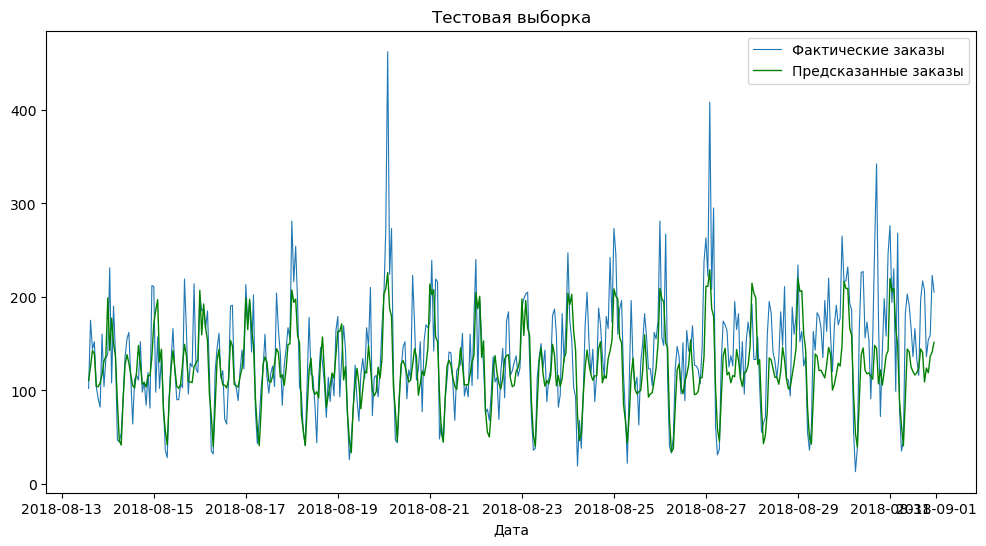

In [395]:
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, lw=0.8) 
plt.plot(target_test.index, pd.Series(pred_test, index=target_test.index), color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Фактические заказы', 'Предсказанные заказы']);

В большем масштабе:

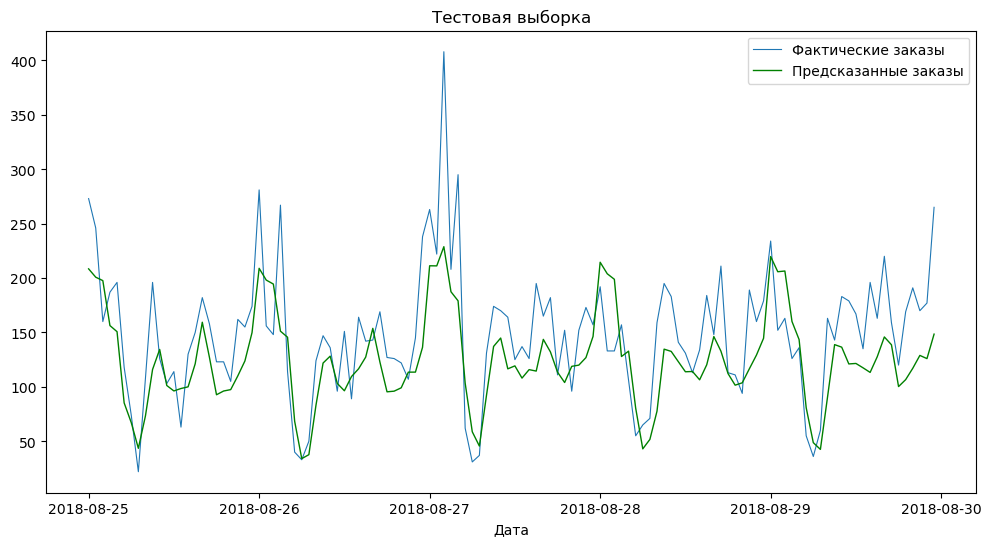

In [377]:
plt.figure(figsize=(12, 6))
plt.plot(target_test['2018-08-25':'2018-08-29'].index, target_test['2018-08-25':'2018-08-29'], lw=0.8) 
plt.plot(target_test['2018-08-25':'2018-08-29'].index, 
pd.Series(pred_test, index=target_test.index)['2018-08-25':'2018-08-29'], color='green', lw=1);
plt.title('Тестовая выборка'); plt.xlabel('Дата'); plt.legend(['Фактические заказы', 'Предсказанные заказы']);

In [379]:
final_test_rmse < 48

True

## Итоговый вывод

 - С целью выявить лучшую модель для предсказания количества заказов на следующий час были обучены модели машинного обучения: Линейная регрессия, Случайный лес, Градиентный бустинг (CatBoost и LightGBM).
 - В результате по критерию качества предсказания (`(train CV) RMSE`); была сведена итоговая таблица с результатами обученных моделей:

In [380]:
training_stats

(train CV) RMSE
Модель                             
LightGBM                      23.87
CatBoost                      24.15
Случайный лес                 24.27
Линейная регрессия            31.74

- Лучшей моделью по метрике RMSE оказалась:

In [381]:
best_model

'LightGBM'

- Тестирование модели показало следущие результаты:

In [382]:
print(f'RMSE модели {best_model} на тестовых данных составил {final_test_rmse:.2f} заказов такси.')

RMSE модели LightGBM на тестовых данных составил 42.25 заказов такси.


In [383]:
final_test_rmse < 48

True

- Можно заключить, что в рамках данного исследования удалось достичь показателя качества, установленного клиентом. Клиенту «Чётенькое такси»  можно рекомендовать применение данной модели для целей прогнозирования на час количетва заказов такси по историческим данным.